In [198]:
import glob
import json
import logging
import os
import re
from pathlib import Path
from typing import Dict, Any, Union, Tuple
from typing import List

import pandas as pd
from matplotlib import pyplot as plt
from numpy import ndarray
from pandas import DataFrame

In [199]:
# Configure logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s',
                    level=logging.DEBUG)

In [200]:
plot_sat_name: str = '<sat_name>'
plot_desc_data_name: str = '<data_name>'

In [201]:
from tabulate import tabulate
from scipy.stats import chi2_contingency, variation


def load_json_data(file_path: str) -> pd.DataFrame:
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")

    with open(file_path, 'r') as f:
        data = json.load(f)

    # Assuming that all items in the JSON file have the same structure
    keys: List[str] = list(data[0].keys())
    filtered_data: List[Dict[str, Any]] = [{key: item[key] for key in keys} for
                                           item in data]

    df: pd.DataFrame = pd.DataFrame(filtered_data)

    return df


def convert_to_universal_time_format(df: pd.DataFrame,
                                     to_period: str = 'D') -> pd.DataFrame:
    # Identify columns that match a regular expression pattern for "time"
    time_columns: List[str] = [col for col in df.columns if
                               re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.',
                                        col)]

    # Convert identified columns to datetime format and extract year and month
    for col in time_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col] = df[col].dt.to_period(to_period)

    # Group by year and month, and calculate the median of each group
    for col in time_columns:
        df = df.groupby(col).median().reset_index()

    return df


def rename_time_columns_to_universal_format(df: pd.DataFrame) -> pd.DataFrame:
    # Find time columns in the dataframe
    time_cols: List[str] = [col for col in df.columns if
                            re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.', col)]

    if len(time_cols) == 1:
        df.rename(columns={time_cols[0]: 'time'}, inplace=True)

    # Handle multiple time indices
    if len(time_cols) > 1:
        for i, col in enumerate(time_cols[1:], start=1):
            df.rename(columns={col: f'time{i}'}, inplace=True)

    return df


def merge_dataframes_by_time(df1: pd.DataFrame,
                             df2: pd.DataFrame) -> pd.DataFrame:
    # Process time columns in both dataframes
    df1 = rename_time_columns_to_universal_format(df1)
    df2 = rename_time_columns_to_universal_format(df2)

    # Merge dataframes
    merged_df: pd.DataFrame = pd.merge(df1, df2, how='inner')

    return merged_df


def filter_by_years(df: pd.DataFrame,
                    years_to_analyze: List[int]) -> pd.DataFrame:
    # Find time columns in the dataframe
    time_cols: List[str] = [col for col in df.columns if
                            re.match(r'.*Time.*|.*Obsdate*.|.*time-tag*.', col)]

    filtered_df: DataFrame = DataFrame()

    for col in time_cols:
        filtered_df = df[df[col].dt.year.isin(years_to_analyze)]

    return filtered_df


def calculate_correlation(df: pd.DataFrame, col1: str, col2: str) -> Tuple[
    Union[float, DataFrame], float, float]:
    correlation: Union[float, DataFrame] = df[col1].corr(df[col2])
    kendal_tau = df[col1].corr(df[col2], method='kendall')
    spearman = df[col1].corr(df[col2], method='spearman')
    return correlation, kendal_tau, spearman


def plot_scatter_single_or_multiple(df: pd.DataFrame, x_col: str,
                                    y_cols: List[str]) -> None:
    assert isinstance(df, pd.DataFrame), "df must be a pandas DataFrame."
    assert isinstance(x_col, str), "x_col must be a string."
    assert isinstance(y_cols, list), "y_cols must be a list."
    assert all(isinstance(y_col, str) for y_col in
               y_cols), "All elements in y_cols must be strings."

    if x_col not in df.columns:
        raise ValueError(f"X column '{x_col}' does not exist in the dataframe.")

    if not pd.api.types.is_numeric_dtype(df[x_col]):
        raise TypeError(f"X column '{x_col}' is not numeric.")

    for y_col in y_cols:
        if y_col not in df.columns:
            raise ValueError(
                f"Y column '{y_col}' does not exist in the dataframe.")
        if not pd.api.types.is_numeric_dtype(df[y_col]):
            raise TypeError(f"Y column '{y_col}' is not numeric.")

    plt.figure(figsize=(10, 8))
    for y_col in y_cols:
        plt.scatter(df[x_col], df[y_col], label=y_col)
    plt.title(
        f'{plot_sat_name}: {x_col} aka [{plot_desc_data_name}] vs {"multiple Y-columns" if len(y_cols) > 1 else y_cols[0]}')
    plt.xlabel(x_col)
    plt.ylabel('Values')
    plt.legend()
    plt.show()


def calculate_correlations_and_plot(df: pd.DataFrame, col_list1: List[str],
                                    col_list2: List[str]) -> None:
    for col1 in col_list1:
        for col2 in col_list2:
            if col1 != col2:
                correlation, kendal_tau, spearman = calculate_correlation(df,
                                                                          col1,
                                                                          col2)
                # Calculate additional statistics for both columns
                stats_col1 = df[col1].describe().transpose()
                stats_col2 = df[col2].describe().transpose()

                # Combine statistics into a single DataFrame
                stats_table = pd.concat([stats_col1, stats_col2], axis=1,
                                        keys=[col1, col2])

                try:
                    # Additional statistical measures
                    chi2, p, _, _ = chi2_contingency(
                        pd.crosstab(df[col1].dropna(), df[col2].dropna()))

                    stats_table.loc['Chi2'] = [chi2, chi2]
                    stats_table.loc['P-value'] = [p, p]
                except Exception as e:
                    pass

                # Print the table with tabulate for a pretty output
                print(tabulate(stats_table, headers='keys', tablefmt='psql'))

                print(
                    f"Correlation [{col1}] vs [{col2}]: pearson=[{correlation}], spearman=[{spearman}], kendal_tau=[{kendal_tau}]")
            else:
                col_list2.remove(col1)
        plot_scatter_single_or_multiple(df, col1, col_list2)


def remove_non_numeric_data(df: pd.DataFrame) -> pd.DataFrame:
    # Ignore the first column
    cols_to_drop = []
    for col in df.columns[1:]:
        if df[col].dtype not in ['float64', 'int64']:
            cols_to_drop.append(col)

    return df.drop(cols_to_drop, axis=1)


def preprocess_solar_data(
        solar_data_file: Union[os.PathLike, str]) -> pd.DataFrame:
    df: DataFrame = load_json_data(solar_data_file)
    df = convert_to_universal_time_format(df)
    return df


def preprocess_satellite_data(satellite_data_file: Union[os.PathLike, str],
                              years_to_analyze: List[int]) -> pd.DataFrame:
    df: DataFrame = pd.read_csv(satellite_data_file)
    df = remove_non_numeric_data(df)
    df = convert_to_universal_time_format(df)
    filter_by_years(df, years_to_analyze)
    return df


def process(solar_data_file: Union[os.PathLike, str],
            satellite_data_file: Union[os.PathLike, str],
            years_to_analyze: List[int] = [2023, 2022, 2021, 2020, 2019,
                                           2014]) -> None:
    df_solar: DataFrame = preprocess_solar_data(solar_data_file)
    df_satellite: DataFrame = preprocess_satellite_data(satellite_data_file,
                                                        years_to_analyze)

    solar_column_names: List[str] = [col for col in df_solar.columns if
                                     not re.match(
                                         r'.*Time.*|.*Obsdate*.|.*time-tag*.',
                                         col)]
    satellite_column_names: List[str] = [col for col in df_satellite.columns if
                                         not re.match(
                                             r'.*Time.*|.*Obsdate*.|.*time-tag*.',
                                             col)]

    for satellite_column in satellite_column_names:
        column_variation: ndarray = variation(df_satellite[satellite_column])
        if column_variation <= 1e-13:
            logging.warning(
                f"Column '{satellite_column}' is nearly constant, skipping.")
            satellite_column_names.remove(satellite_column)

    df_solar_satellite_merged: DataFrame = merge_dataframes_by_time(df_solar,
                                                                    df_satellite)
    calculate_correlations_and_plot(df_solar_satellite_merged,
                                    satellite_column_names, solar_column_names)

In [202]:
def analyze_satellite(sat_name: str):
    global plot_sat_name
    plot_sat_name = sat_name

    observed_solar_cycle_data_path: Path = '../data/swpc_observed_ssn.json'
    sat_csv_data_files: List[str] = glob.glob(
        os.path.join(f"../data/{sat_name}", "*.csv"))

    if not sat_csv_data_files:
        logging.error(
            f"No CSV files found for satellite=[{sat_name}]. Path checked=[{observed_solar_cycle_data_path}]")
        return

    for sat_file in sat_csv_data_files:
        try:
            assert os.path.exists(
                sat_file), f"File does not exist: [{sat_file}]"
            logging.debug(f"Processing file: [{sat_file}]")

            global plot_desc_data_name
            plot_desc_data_name = os.path.basename(sat_file)
            plot_desc_data_name = re.sub(r'-\d.*$|\.\w+$', '',
                                         plot_desc_data_name,
                                         flags=re.IGNORECASE)
            assert plot_desc_data_name, f"Failed to extract plot description from filename: {sat_file}"

            process(solar_data_file=observed_solar_cycle_data_path,
                    satellite_data_file=os.path.abspath(sat_file))
        except AssertionError as e:
            logging.error(e)
        except Exception as ex:
            logging.exception(
                f"Unexpected error processing file=[{sat_file}] : {ex}")

2024-02-11 18:21:23,580 - DEBUG - Processing file: [../data/griffex/battery.csv]


+---------+----------------+----------------+
|         |        Battery |       swpc_ssn |
|---------+----------------+----------------|
| count   | 1418           | 1418           |
| mean    |    8.25282     |   60.9464      |
| std     |    0.111554    |   51.2837      |
| min     |    7.4         |    0           |
| 25%     |    8.3         |   14           |
| 50%     |    8.3         |   49           |
| 75%     |    8.3         |   99           |
| max     |    8.4         |  227           |
| Chi2    | 3149.82        | 3149.82        |
| P-value |    4.21142e-78 |    4.21142e-78 |
+---------+----------------+----------------+
Correlation [Battery] vs [swpc_ssn]: pearson=[-0.05633533230487771], spearman=[0.009183743692619008], kendal_tau=[0.0051619469492026875]


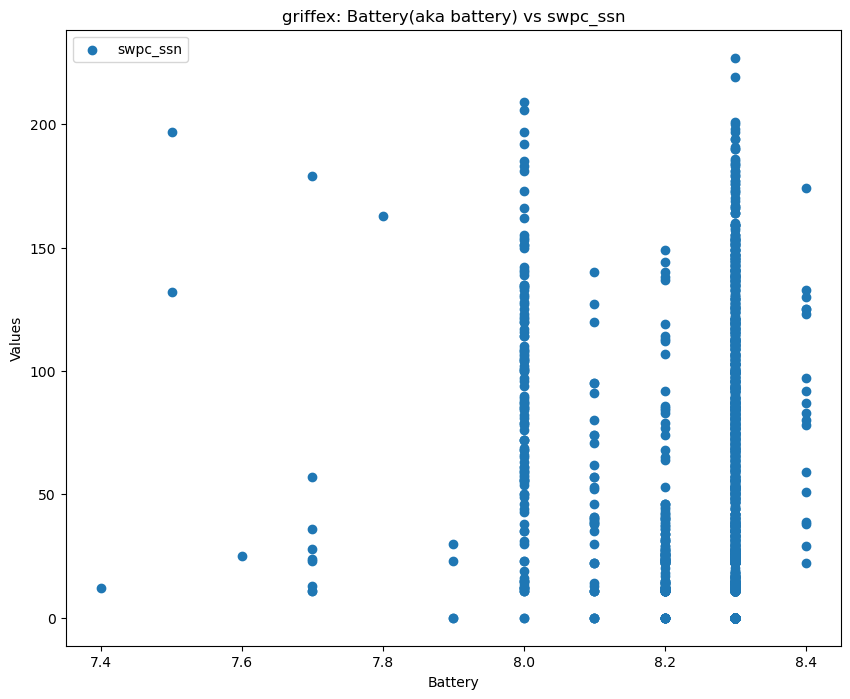

2024-02-11 18:21:23,750 - DEBUG - Processing file: [../data/griffex/battery_3v.csv]
2024-02-11 18:21:23,771 - WARNING - Column '3.3V' is nearly constant, skipping.
2024-02-11 18:21:23,774 - DEBUG - Processing file: [../data/griffex/battery_5v.csv]
2024-02-11 18:21:23,794 - WARNING - Column '5V' is nearly constant, skipping.
2024-02-11 18:21:23,796 - DEBUG - Processing file: [../data/griffex/bus_current.csv]


+---------+------------------+------------------+
|         |      Battery Bus |         swpc_ssn |
|---------+------------------+------------------|
| count   |  1418            |  1418            |
| mean    |     0.201327     |    60.9464       |
| std     |     0.274658     |    51.2837       |
| min     |     0.031        |     0            |
| 25%     |     0.033        |    14            |
| 50%     |     0.0555       |    49            |
| 75%     |     0.25         |    99            |
| max     |     1.4          |   227            |
| Chi2    | 34497.4          | 34497.4          |
| P-value |     4.98556e-140 |     4.98556e-140 |
+---------+------------------+------------------+
Correlation [Battery Bus] vs [swpc_ssn]: pearson=[0.13672412903702072], spearman=[0.39612621911017304], kendal_tau=[0.27477822293117526]


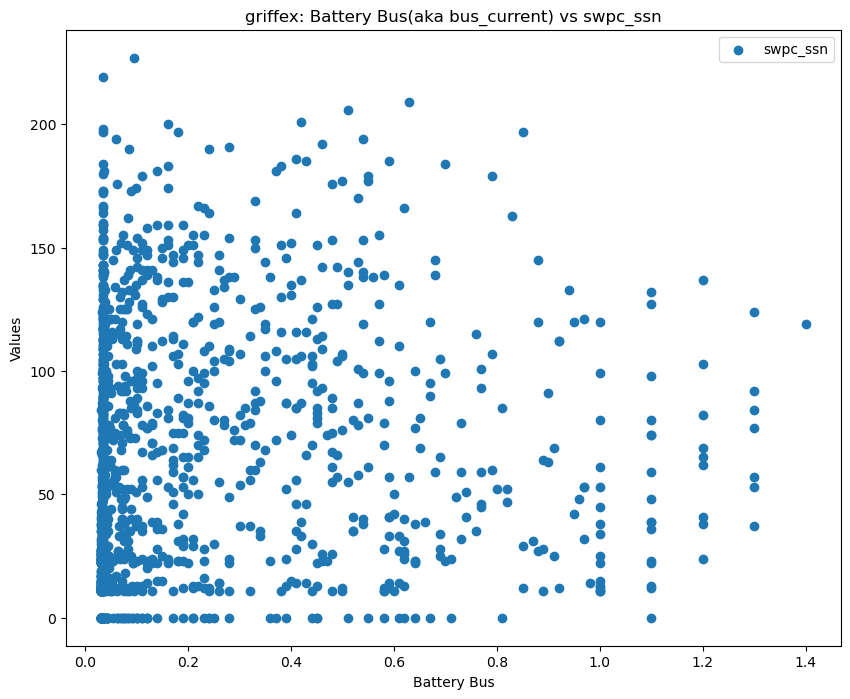

2024-02-11 18:21:23,985 - DEBUG - Processing file: [../data/griffex/bus_voltage.csv]


+---------+----------------+----------------+
|         |    Battery Bus |       swpc_ssn |
|---------+----------------+----------------|
| count   | 1418           | 1418           |
| mean    |    8.28188     |   60.9464      |
| std     |    0.116477    |   51.2837      |
| min     |    7.4         |    0           |
| 25%     |    8.3         |   14           |
| 50%     |    8.3         |   49           |
| 75%     |    8.3         |   99           |
| max     |    8.4         |  227           |
| Chi2    | 1789.93        | 1789.93        |
| P-value |    2.60546e-10 |    2.60546e-10 |
+---------+----------------+----------------+
Correlation [Battery Bus] vs [swpc_ssn]: pearson=[0.003239808274962762], spearman=[0.12023594381103614], kendal_tau=[0.09204306050681259]


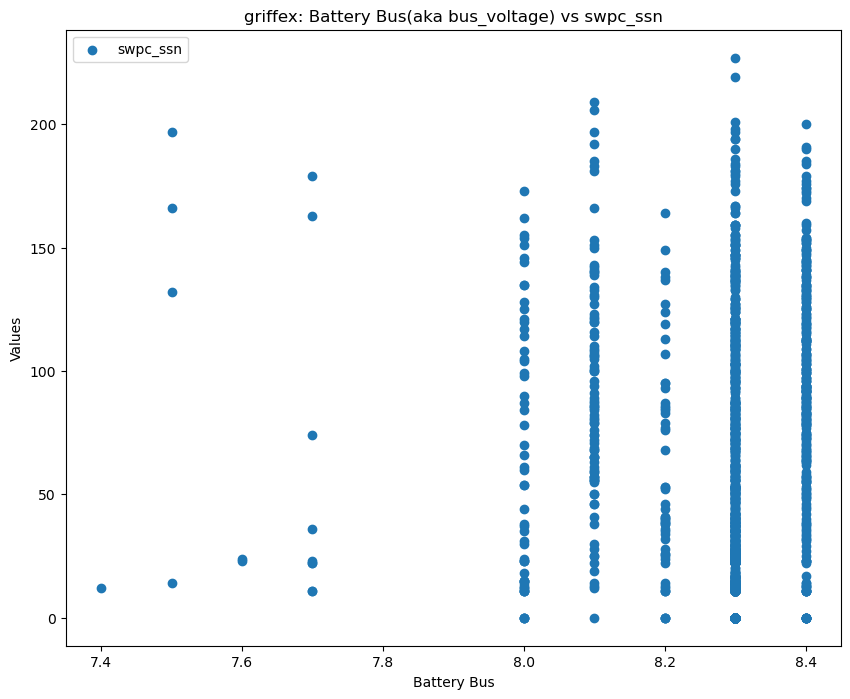

2024-02-11 18:21:24,153 - DEBUG - Processing file: [../data/griffex/data_mnt_usage.csv]


+---------+------------------+------------------+
|         |     40379.median |         swpc_ssn |
|---------+------------------+------------------|
| count   |   1418           |   1418           |
| mean    | 479867           |     60.8505      |
| std     |  32335.5         |     51.2461      |
| min     | 395649           |      0           |
| 25%     | 484053           |     14           |
| 50%     | 493385           |     49           |
| 75%     | 498567           |     99           |
| max     | 499679           |    227           |
| Chi2    | 171857           | 171857           |
| P-value |      1.7832e-129 |      1.7832e-129 |
+---------+------------------+------------------+
Correlation [40379.median] vs [swpc_ssn]: pearson=[0.46315355052211304], spearman=[0.4759659161682569], kendal_tau=[0.32450245018819246]


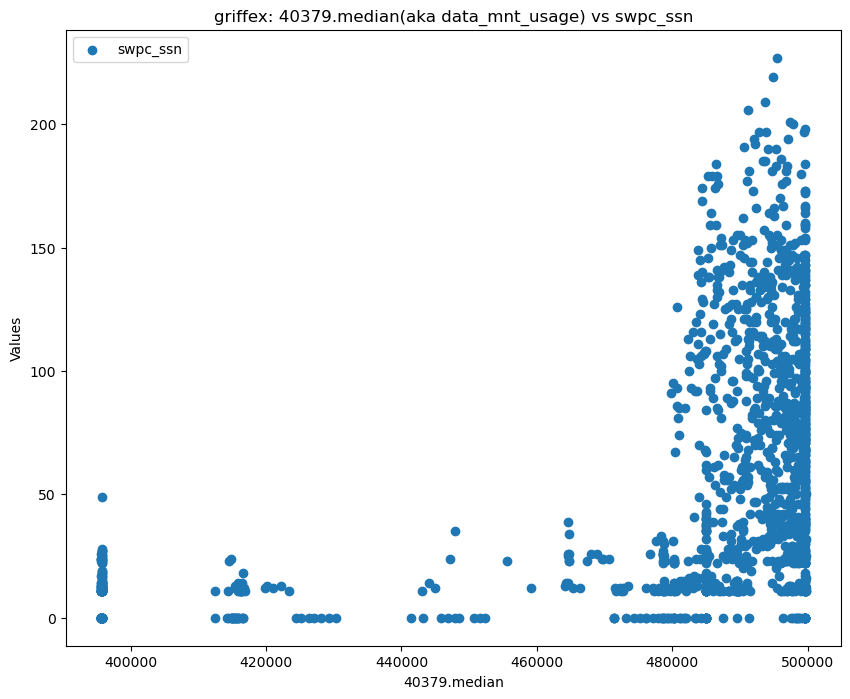

2024-02-11 18:21:24,335 - DEBUG - Processing file: [../data/griffex/memory_free_median.csv]


+---------+-----------------+-------------+
|         |   40379.freemem |    swpc_ssn |
|---------+-----------------+-------------|
| count   |      1422       |  1422       |
| mean    |         3.92844 |    60.8629  |
| std     |         2.68321 |    51.2549  |
| min     |         0.18    |     0       |
| 25%     |         0.585   |    14       |
| 50%     |         4.3     |    49       |
| 75%     |         6.7     |    99       |
| max     |        12       |   227       |
| Chi2    |     28481.8     | 28481.8     |
| P-value |         0.20023 |     0.20023 |
+---------+-----------------+-------------+
Correlation [40379.freemem] vs [swpc_ssn]: pearson=[-0.2553320454993292], spearman=[-0.28660957028269796], kendal_tau=[-0.19699078323395622]


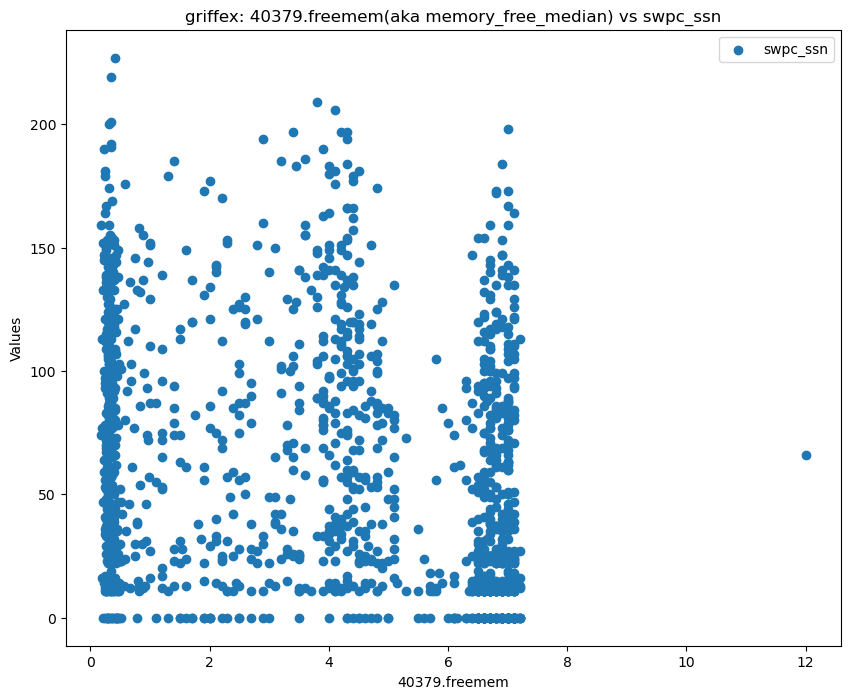

2024-02-11 18:21:25,050 - DEBUG - Processing file: [../data/griffex/memory_median.csv]


+---------+----------------+---------------+
|         |   40379.median |      swpc_ssn |
|---------+----------------+---------------|
| count   |  1421          | 1421          |
| mean    |     7.91499    |   60.9064     |
| std     |     0.325999   |   51.2468     |
| min     |     7.9        |    0          |
| 25%     |     7.9        |   14          |
| 50%     |     7.9        |   49          |
| 75%     |     7.9        |   99          |
| max     |    15          |  227          |
| Chi2    |   234.328      |  234.328      |
| P-value |     0.00344455 |    0.00344455 |
+---------+----------------+---------------+
Correlation [40379.median] vs [swpc_ssn]: pearson=[0.023727671689518597], spearman=[0.027255477433036954], kendal_tau=[0.022511671225207898]


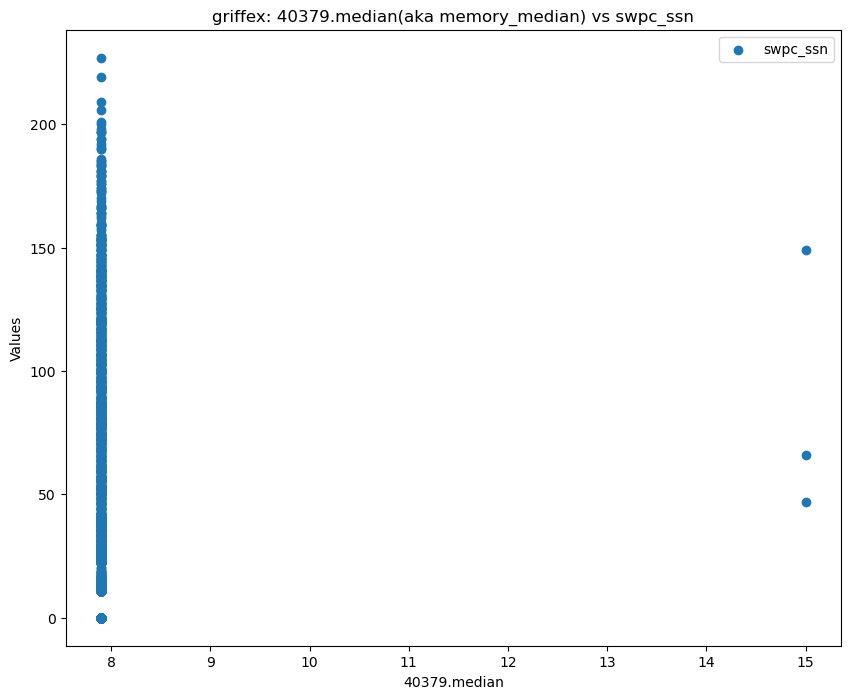

2024-02-11 18:21:25,223 - DEBUG - Processing file: [../data/griffex/resets.csv]


+---------+------------+-------------+
|         |     resets |    swpc_ssn |
|---------+------------+-------------|
| count   |   1421     |   1421      |
| mean    |   1065.66  |     60.9064 |
| std     |    621.888 |     51.2468 |
| min     |      0     |      0      |
| 25%     |    759     |     14      |
| 50%     |   1247     |     49      |
| 75%     |   1547     |     99      |
| max     |   4945     |    227      |
| Chi2    | 109307     | 109307      |
| P-value |      1     |      1      |
+---------+------------+-------------+
Correlation [resets] vs [swpc_ssn]: pearson=[0.17805007116349097], spearman=[0.3894670351522071], kendal_tau=[0.28077806323937066]


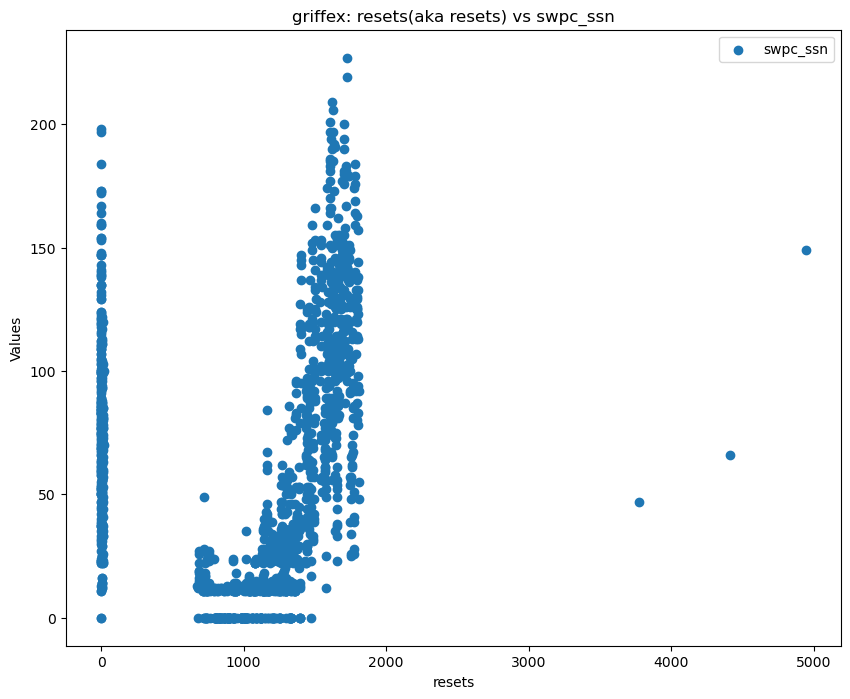

2024-02-11 18:21:25,431 - DEBUG - Processing file: [../data/griffex/rssi.csv]
2024-02-11 18:21:25,453 - WARNING - Column '40379.min' is nearly constant, skipping.


In [203]:
analyze_satellite('griffex')

2024-02-11 18:21:25,458 - DEBUG - Processing file: [../data/cas-5a/Power Supply Voltage-data-2024-02-11 02 21 52.csv]


+---------+---------------------+------------+
|         |   54684.mode_mode V |   swpc_ssn |
|---------+---------------------+------------|
| count   |           18        |  18        |
| mean    |           11.4661   | 109        |
| std     |            0.150612 |  34.8037   |
| min     |           11.3      |  33        |
| 25%     |           11.35     |  99.5      |
| 50%     |           11.46     | 106        |
| 75%     |           11.51     | 133.75     |
| max     |           11.91     | 166        |
| Chi2    |          173.25     | 173.25     |
| P-value |            0.314423 |   0.314423 |
+---------+---------------------+------------+
Correlation [54684.mode_mode V] vs [swpc_ssn]: pearson=[0.12142101001190515], spearman=[0.35361993001509145], kendal_tau=[0.23057339665182852]


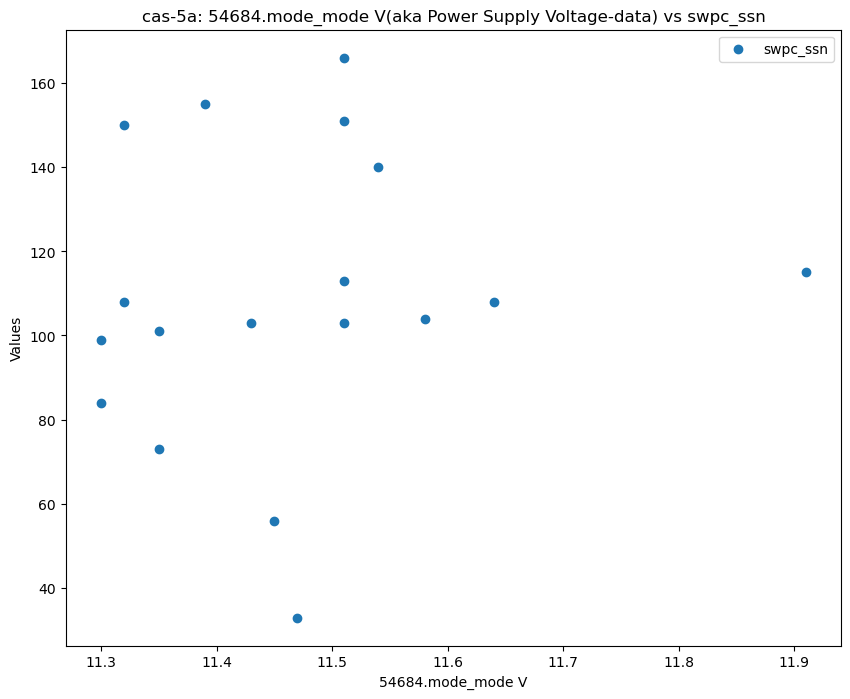

2024-02-11 18:21:25,608 - DEBUG - Processing file: [../data/cas-5a/RF Power-data-2024-02-11 02 22 25.csv]


+---------+--------------+-------------+
|         |   UHF1 Power |    swpc_ssn |
|---------+--------------+-------------|
| count   |   114        |  114        |
| mean    |  1407.48     |  117.395    |
| std     |   136.545    |   42.6178   |
| min     |  1092        |   23        |
| 25%     |  1263        |   87.25     |
| 50%     |  1476        |  110.5      |
| 75%     |  1512.25     |  140.75     |
| max     |  1578        |  209        |
| Chi2    |  5030.79     | 5030.79     |
| P-value |     0.438725 |    0.438725 |
+---------+--------------+-------------+
Correlation [UHF1 Power] vs [swpc_ssn]: pearson=[-0.15676750343342466], spearman=[-0.1927394646248011], kendal_tau=[-0.13246747181362192]


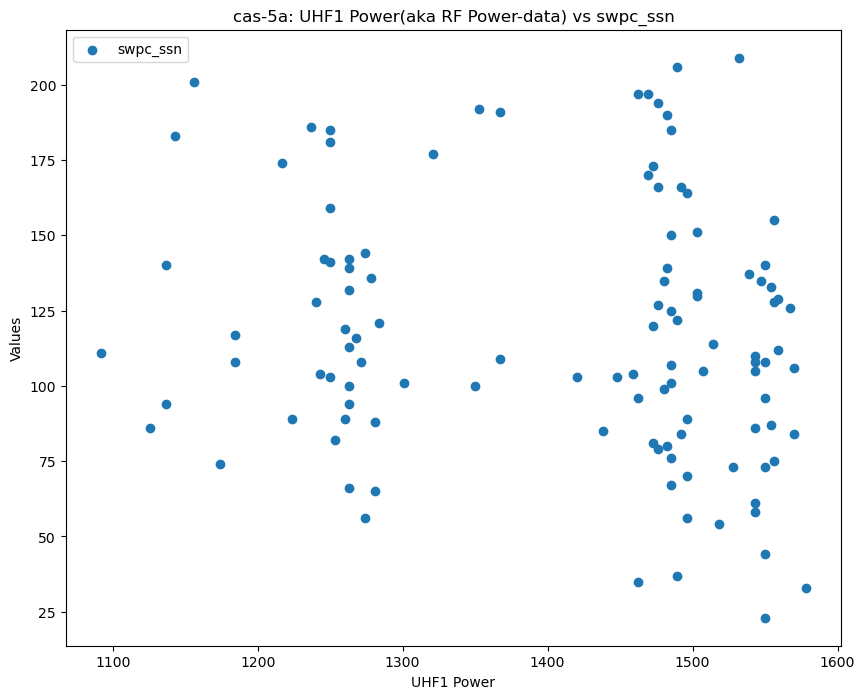

2024-02-11 18:21:25,779 - DEBUG - Processing file: [../data/cas-5a/System Currents-data-2024-02-11 02 22 13.csv]


+---------+-----------------------+---------------+
|         |   Primary Bus Current |      swpc_ssn |
|---------+-----------------------+---------------|
| count   |         114           | 114           |
| mean    |          25.0526      | 117.395       |
| std     |         157.189       |  42.6178      |
| min     |           0           |  23           |
| 25%     |           0           |  87.25        |
| 50%     |           0           | 110.5         |
| 75%     |           0           | 140.75        |
| max     |        1195           | 209           |
| Chi2    |         342           | 342           |
| P-value |           0.000854883 |   0.000854883 |
+---------+-----------------------+---------------+
Correlation [Primary Bus Current] vs [swpc_ssn]: pearson=[-0.10212962782413144], spearman=[-0.030105054109296783], kendal_tau=[-0.024528442570878228]


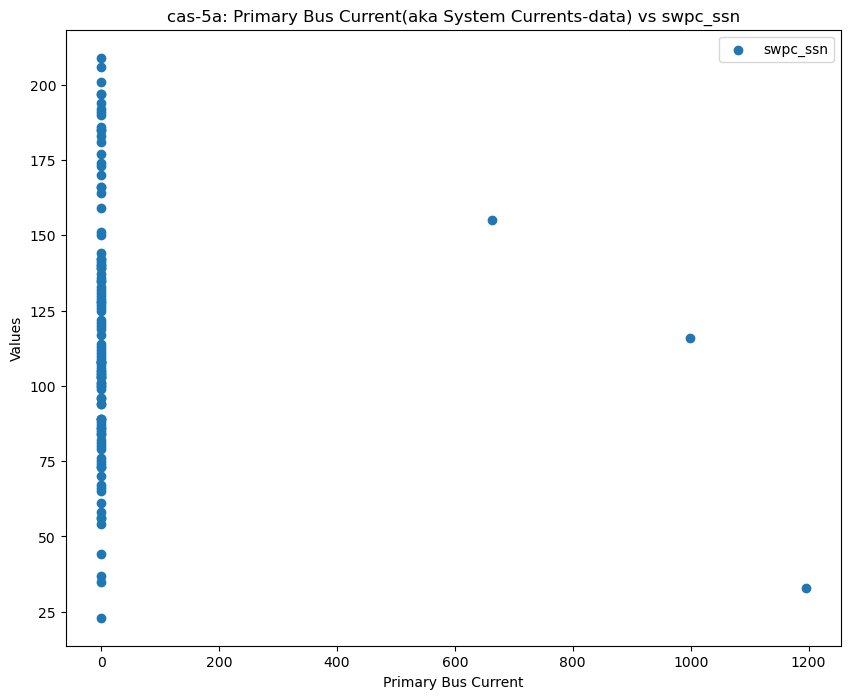

2024-02-11 18:21:25,946 - DEBUG - Processing file: [../data/cas-5a/System Temperatures (C)-data-2024-02-11 02 22 19.csv]


+---------+--------------+--------------+
|         |          IHU |     swpc_ssn |
|---------+--------------+--------------|
| count   |  114         |  114         |
| mean    |   16.5       |  117.395     |
| std     |    2.47197   |   42.6178    |
| min     |   13         |   23         |
| 25%     |   15         |   87.25      |
| 50%     |   16         |  110.5       |
| 75%     |   17         |  140.75      |
| max     |   26         |  209         |
| Chi2    | 1032.9       | 1032.9       |
| P-value |    0.0723609 |    0.0723609 |
+---------+--------------+--------------+
Correlation [IHU] vs [swpc_ssn]: pearson=[0.014742294538607096], spearman=[-0.008542958649201576], kendal_tau=[-0.009403302154266163]


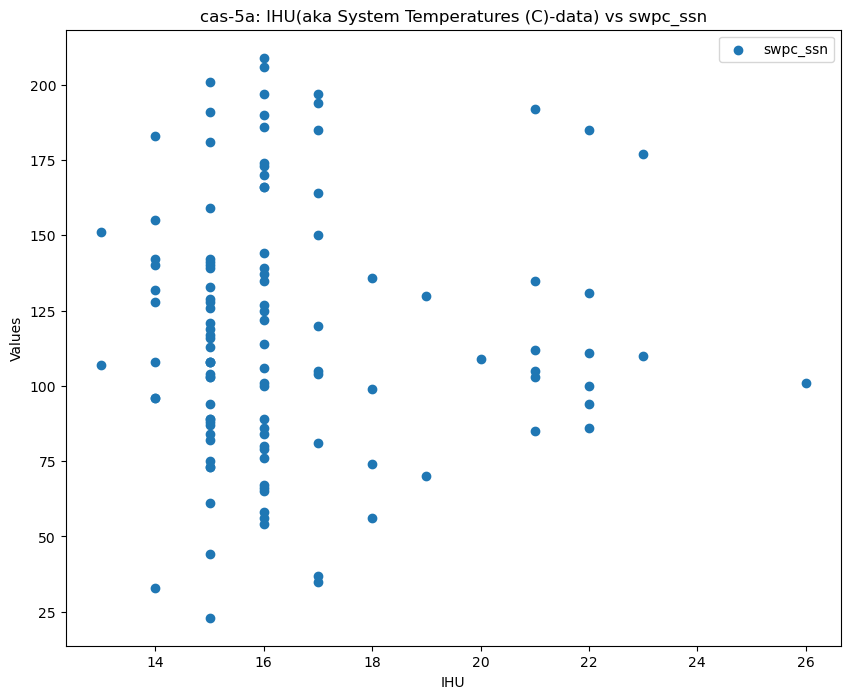

2024-02-11 18:21:26,107 - DEBUG - Processing file: [../data/cas-5a/Total Solar Array Current-data-2024-02-11 02 22 49.csv]


+---------+-----------------------------+--------------+
|         |   Total Solar Array Current |     swpc_ssn |
|---------+-----------------------------+--------------|
| count   |                114          | 114          |
| mean    |               2620.46       | 117.395      |
| std     |                 53.9164     |  42.6178     |
| min     |               2088          |  23          |
| 25%     |               2627          |  87.25       |
| 50%     |               2627          | 110.5        |
| 75%     |               2627          | 140.75       |
| max     |               2627          | 209          |
| Chi2    |                228          | 228          |
| P-value |                  0.00504798 |   0.00504798 |
+---------+-----------------------------+--------------+
Correlation [Total Solar Array Current] vs [swpc_ssn]: pearson=[0.1369086294587559], spearman=[0.040145991592160944], kendal_tau=[0.03247210626412327]


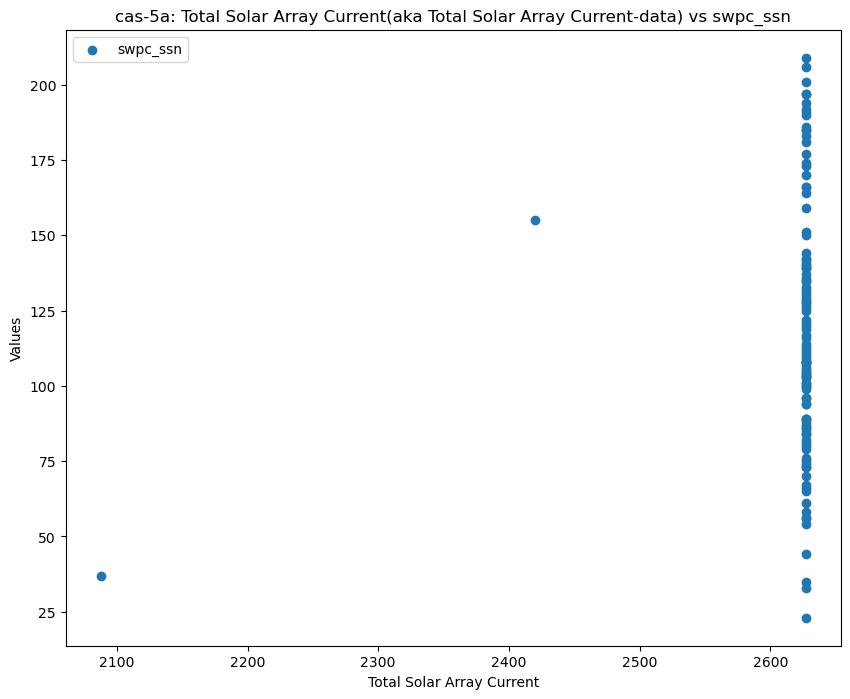

2024-02-11 18:21:26,271 - DEBUG - Processing file: [../data/cas-5a/Watchdog (48 hrs)-data-2024-02-11 02 23 13.csv]


+---------+-----------+------------+
|         |        YY |   swpc_ssn |
|---------+-----------+------------|
| count   | 116       |  116       |
| mean    |  22.5862  |  117.371   |
| std     |   2.15515 |   42.3202  |
| min     |   0       |   23       |
| 25%     |  23       |   87.75    |
| 50%     |  23       |  110.5     |
| 75%     |  23       |  140.25    |
| max     |  23       |  209       |
| Chi2    | 141.735   |  141.735   |
| P-value |   0.97906 |    0.97906 |
+---------+-----------+------------+
Correlation [YY] vs [swpc_ssn]: pearson=[-0.14398357831183856], spearman=[-0.04103790831221357], kendal_tau=[-0.034829311527713486]


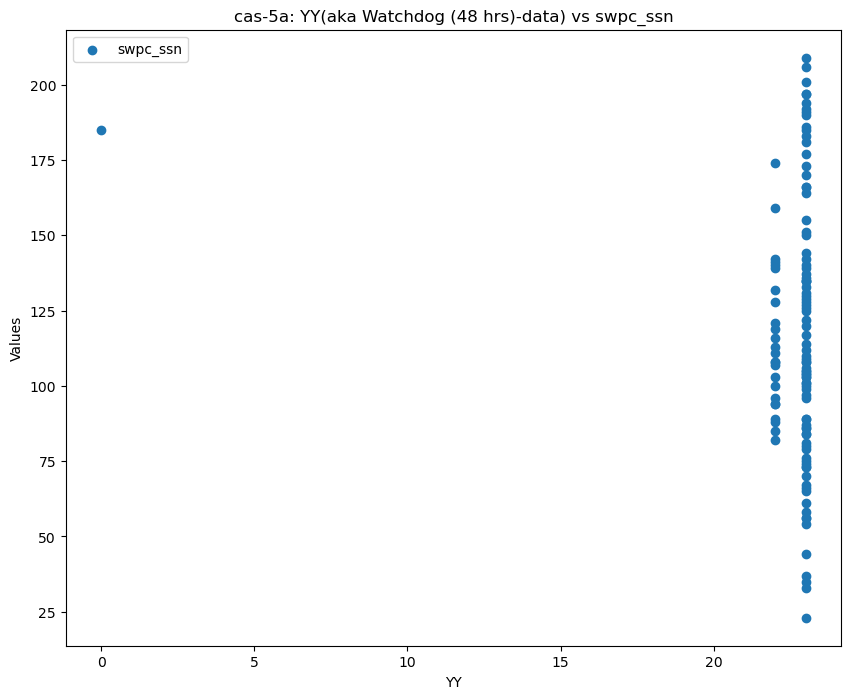

+---------+------------+------------+
|         |         MM |   swpc_ssn |
|---------+------------+------------|
| count   | 116        | 116        |
| mean    |   4.23276  | 117.371    |
| std     |   4.17312  |  42.3202   |
| min     |   0        |  23        |
| 25%     |   1.75     |  87.75     |
| 50%     |   3        | 110.5      |
| 75%     |   4        | 140.25     |
| max     |  12        | 209        |
| Chi2    | 426.165    | 426.165    |
| P-value |   0.731728 |   0.731728 |
+---------+------------+------------+
Correlation [MM] vs [swpc_ssn]: pearson=[-0.10782995308889555], spearman=[-0.24905700060777822], kendal_tau=[-0.18181700146162916]


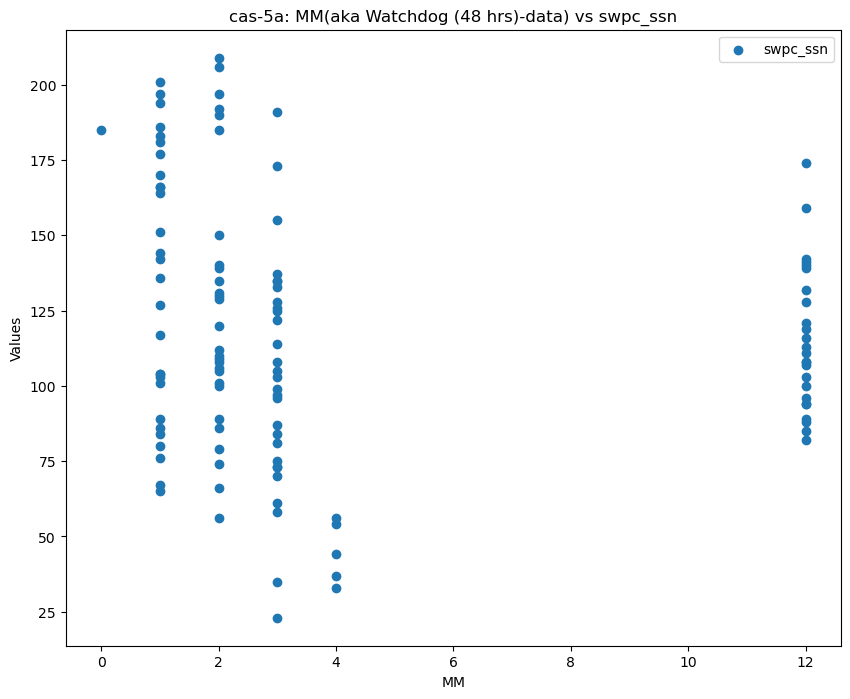

+---------+--------------+--------------+
|         |           DD |     swpc_ssn |
|---------+--------------+--------------|
| count   |  116         |  116         |
| mean    |   15.8103    |  117.371     |
| std     |    8.89251   |   42.3202    |
| min     |    0         |   23         |
| 25%     |    9         |   87.75      |
| 50%     |   15         |  110.5       |
| 75%     |   23.25      |  140.25      |
| max     |   31         |  209         |
| Chi2    | 2809.94      | 2809.94      |
| P-value |    0.0292714 |    0.0292714 |
+---------+--------------+--------------+
Correlation [DD] vs [swpc_ssn]: pearson=[-0.1289063012452791], spearman=[-0.14923357517709296], kendal_tau=[-0.11815398003289736]


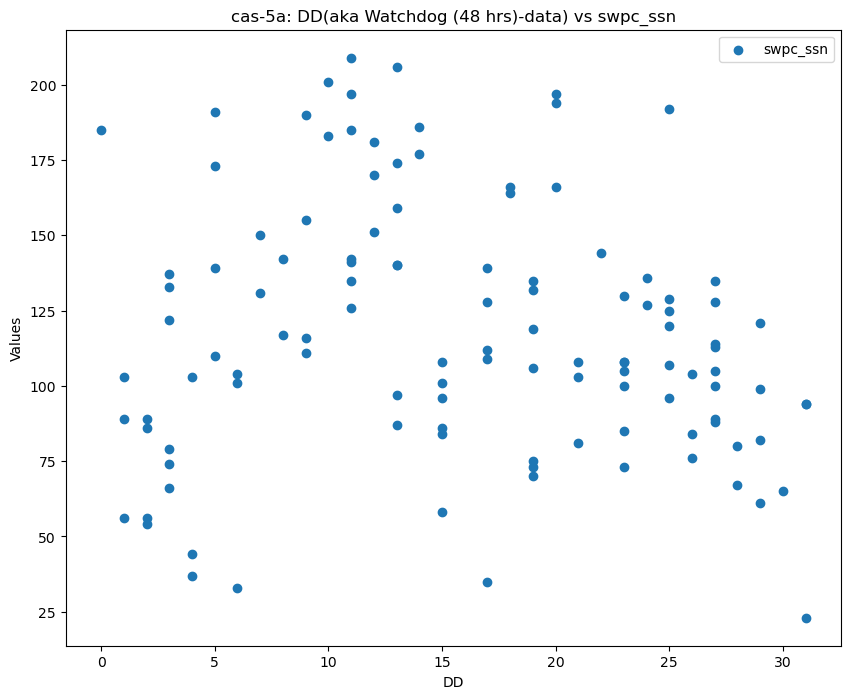

+---------+------------+------------+
|         |         hh |   swpc_ssn |
|---------+------------+------------|
| count   | 116        | 116        |
| mean    |  15.7931   | 117.371    |
| std     |   3.41485  |  42.3202   |
| min     |   0        |  23        |
| 25%     |  11        |  87.75     |
| 50%     |  18        | 110.5      |
| 75%     |  18        | 140.25     |
| max     |  18        | 209        |
| Chi2    | 245.13     | 245.13     |
| P-value |   0.827547 |   0.827547 |
+---------+------------+------------+
Correlation [hh] vs [swpc_ssn]: pearson=[-0.0882762728840715], spearman=[-0.0851267408255598], kendal_tau=[-0.06216459662208153]


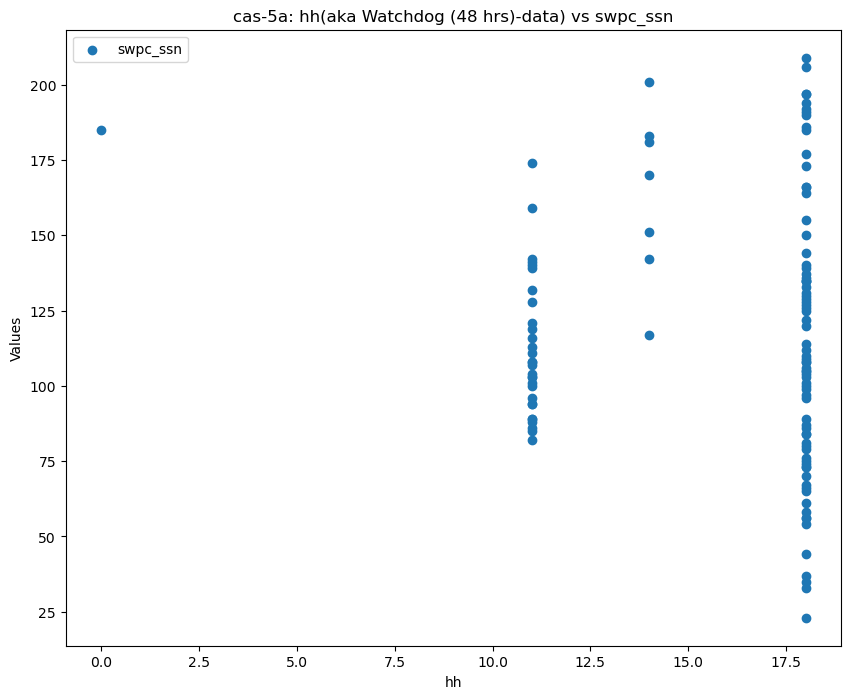

+---------+------------+------------+
|         |         mm |   swpc_ssn |
|---------+------------+------------|
| count   | 116        | 116        |
| mean    |  31.9397   | 117.371    |
| std     |  10.855    |  42.3202   |
| min     |   0        |  23        |
| 25%     |  25        |  87.75     |
| 50%     |  26        | 110.5      |
| 75%     |  47        | 140.25     |
| max     |  49        | 209        |
| Chi2    | 546.449    | 546.449    |
| P-value |   0.345175 |   0.345175 |
+---------+------------+------------+
Correlation [mm] vs [swpc_ssn]: pearson=[0.03374247709264224], spearman=[-0.07001613606469784], kendal_tau=[-0.0455067390483105]


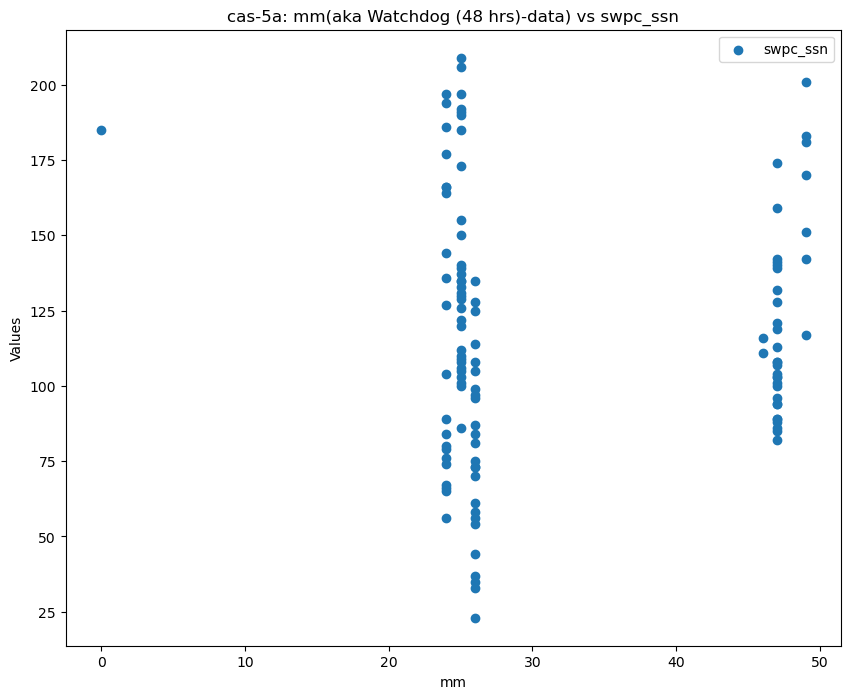

+---------+-------------+-------------+
|         |          ss |    swpc_ssn |
|---------+-------------+-------------|
| count   |  116        |  116        |
| mean    |   28.1293   |  117.371    |
| std     |   16.4208   |   42.3202   |
| min     |    0        |   23        |
| 25%     |   15        |   87.75     |
| 50%     |   30.5      |  110.5      |
| 75%     |   40        |  140.25     |
| max     |   59        |  209        |
| Chi2    | 2931.03     | 2931.03     |
| P-value |    0.136018 |    0.136018 |
+---------+-------------+-------------+
Correlation [ss] vs [swpc_ssn]: pearson=[-0.07445892879360048], spearman=[-0.057261542154608706], kendal_tau=[-0.04622082116393414]


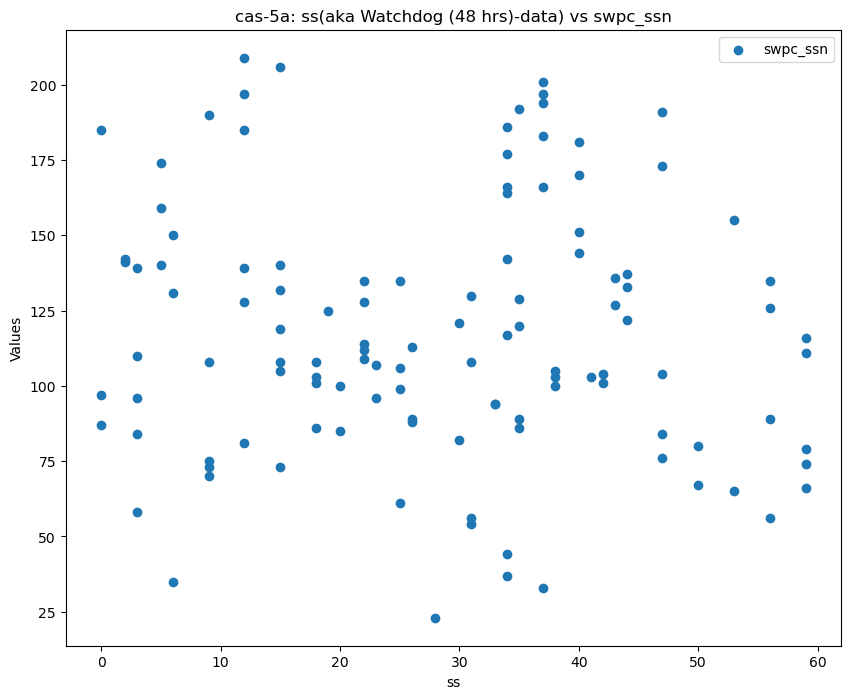

2024-02-11 18:21:27,299 - DEBUG - Processing file: [../data/cas-5a/AGC Levels-data-2024-02-11 02 22 35.csv]


+---------+------------+------------+
|         |    VHF AGC |   swpc_ssn |
|---------+------------+------------|
| count   | 114        | 114        |
| mean    |   1.47632  | 117.395    |
| std     |   0.107508 |  42.6178   |
| min     |   1        |  23        |
| 25%     |   1.4      |  87.25     |
| 50%     |   1.4      | 110.5      |
| 75%     |   1.6      | 140.75     |
| max     |   1.6      | 209        |
| Chi2    | 348.801    | 348.801    |
| P-value |   0.538153 |   0.538153 |
+---------+------------+------------+
Correlation [VHF AGC] vs [swpc_ssn]: pearson=[0.09824608531088937], spearman=[0.10999702789527843], kendal_tau=[0.09006864929746124]


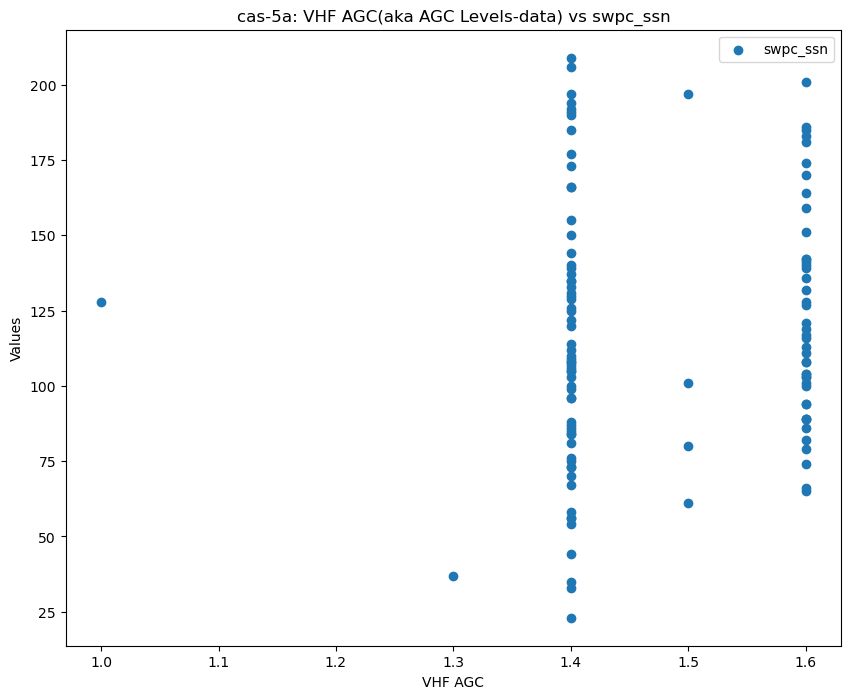

2024-02-11 18:21:27,458 - DEBUG - Processing file: [../data/cas-5a/Camera Photo Counters-data-2024-02-11 02 22 58.csv]


+---------+-------------+-------------+
|         |      Cam #1 |    swpc_ssn |
|---------+-------------+-------------|
| count   | 116         | 116         |
| mean    |  13.4741    | 117.371     |
| std     |   6.63254   |  42.3202    |
| min     |   3         |  23         |
| 25%     |   3         |  87.75      |
| 50%     |  18         | 110.5       |
| 75%     |  18         | 140.25      |
| max     |  18         | 209         |
| Chi2    | 640.703     | 640.703     |
| P-value |   0.0010009 |   0.0010009 |
+---------+-------------+-------------+
Correlation [Cam #1] vs [swpc_ssn]: pearson=[-0.03789992980533905], spearman=[-0.0862393269712509], kendal_tau=[-0.058294019738260705]


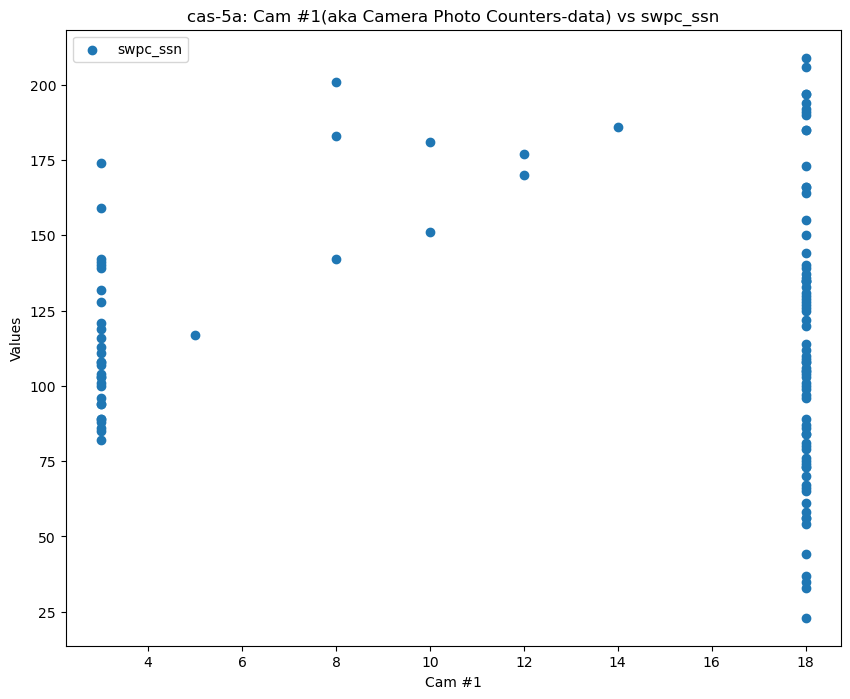

+---------+--------------+--------------+
|         |       Cam #2 |     swpc_ssn |
|---------+--------------+--------------|
| count   | 116          | 116          |
| mean    |  10.5948     | 117.371      |
| std     |   4.9396     |  42.3202     |
| min     |   3          |  23          |
| 25%     |   3          |  87.75       |
| 50%     |  14          | 110.5        |
| 75%     |  14          | 140.25       |
| max     |  14          | 209          |
| Chi2    | 525.556      | 525.556      |
| P-value |   0.00501743 |   0.00501743 |
+---------+--------------+--------------+
Correlation [Cam #2] vs [swpc_ssn]: pearson=[-0.05692881563169436], spearman=[-0.08752579264674691], kendal_tau=[-0.060705560584363896]


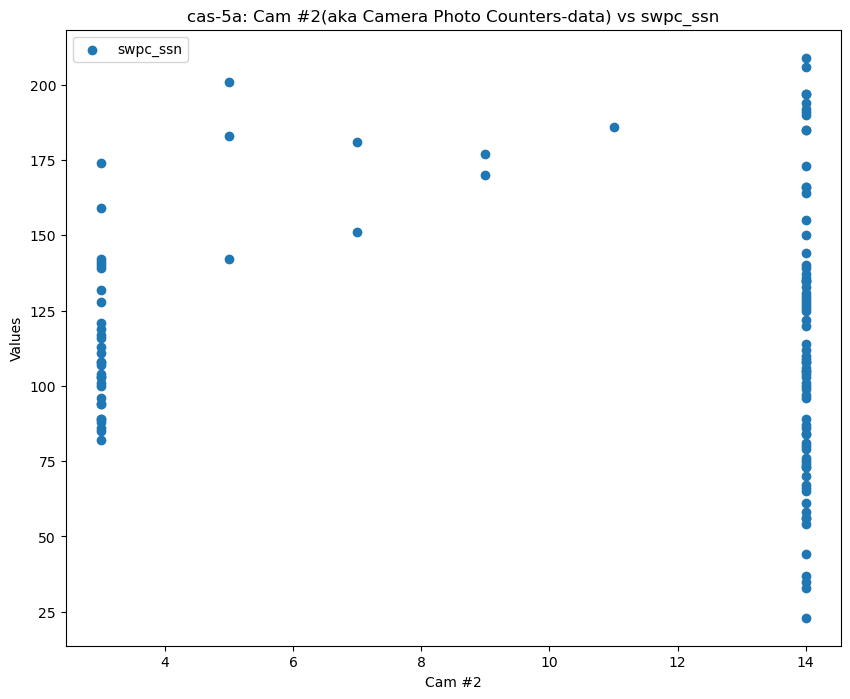

+---------+-------------+-------------+
|         |      Cam #3 |    swpc_ssn |
|---------+-------------+-------------|
| count   | 116         | 116         |
| mean    |  12.7414    | 117.371     |
| std     |   6.21096   |  42.3202    |
| min     |   3         |  23         |
| 25%     |   3         |  87.75      |
| 50%     |  17         | 110.5       |
| 75%     |  17         | 140.25      |
| max     |  17         | 209         |
| Chi2    | 640.703     | 640.703     |
| P-value |   0.0010009 |   0.0010009 |
+---------+-------------+-------------+
Correlation [Cam #3] vs [swpc_ssn]: pearson=[-0.04541799929267759], spearman=[-0.0862393269712509], kendal_tau=[-0.058294019738260705]


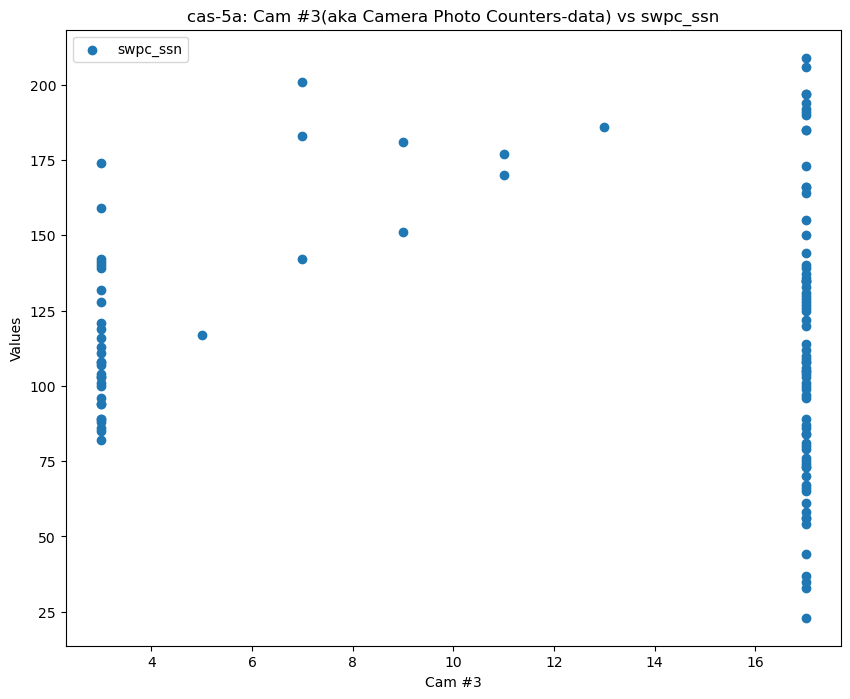

2024-02-11 18:21:27,988 - DEBUG - Processing file: [../data/cas-5a/Camera Status-data-2024-02-11 02 23 01.csv]
2024-02-11 18:21:28,011 - DEBUG - Processing file: [../data/cas-5a/Image Data-data-2024-02-11 02 22 41.csv]


+---------+------------+------------+
|         |       Year |   swpc_ssn |
|---------+------------+------------|
| count   |  32        |  32        |
| mean    |  27.5      |  99.0938   |
| std     |  26.3708   |  39.7454   |
| min     |  22        |  23        |
| 25%     |  23        |  72.25     |
| 50%     |  23        |  99.5      |
| 75%     |  23        | 126.5      |
| max     | 172        | 191        |
| Chi2    |  60.1846   |  60.1846   |
| P-value |   0.326848 |   0.326848 |
+---------+------------+------------+
Correlation [Year] vs [swpc_ssn]: pearson=[0.006047697802733397], spearman=[0.0958021232327667], kendal_tau=[0.08518729813651077]


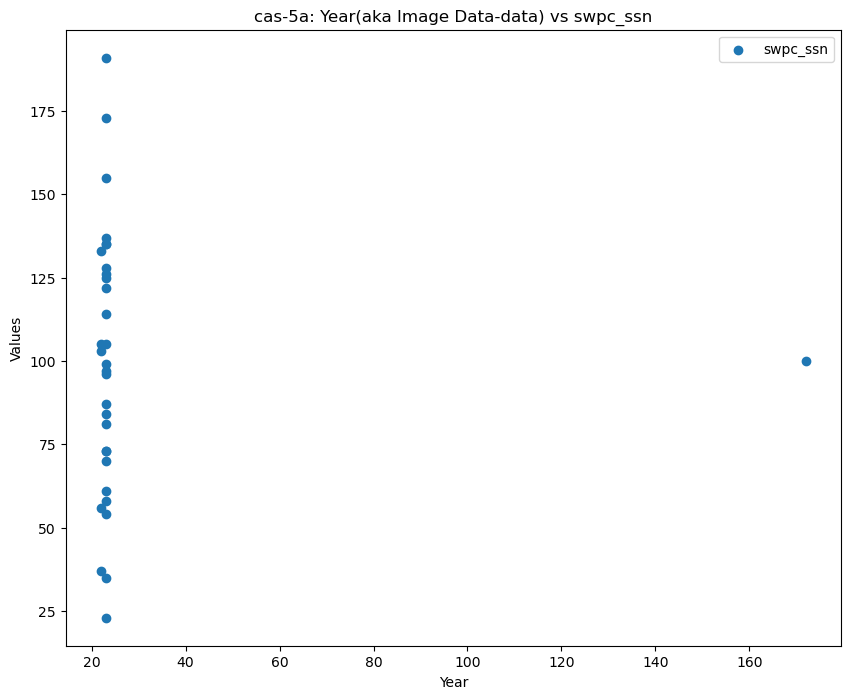

+---------+------------+------------+
|         |      Month |   swpc_ssn |
|---------+------------+------------|
| count   |  32        |  32        |
| mean    |   5.84375  |  99.0938   |
| std     |  17.8291   |  39.7454   |
| min     |   1        |  23        |
| 25%     |   1        |  72.25     |
| 50%     |   1        |  99.5      |
| 75%     |   1        | 126.5      |
| max     | 101        | 191        |
| Chi2    |  60.1846   |  60.1846   |
| P-value |   0.326848 |   0.326848 |
+---------+------------+------------+
Correlation [Month] vs [swpc_ssn]: pearson=[-0.026654512259354883], spearman=[-0.0871542587942659], kendal_tau=[-0.07808835662513489]


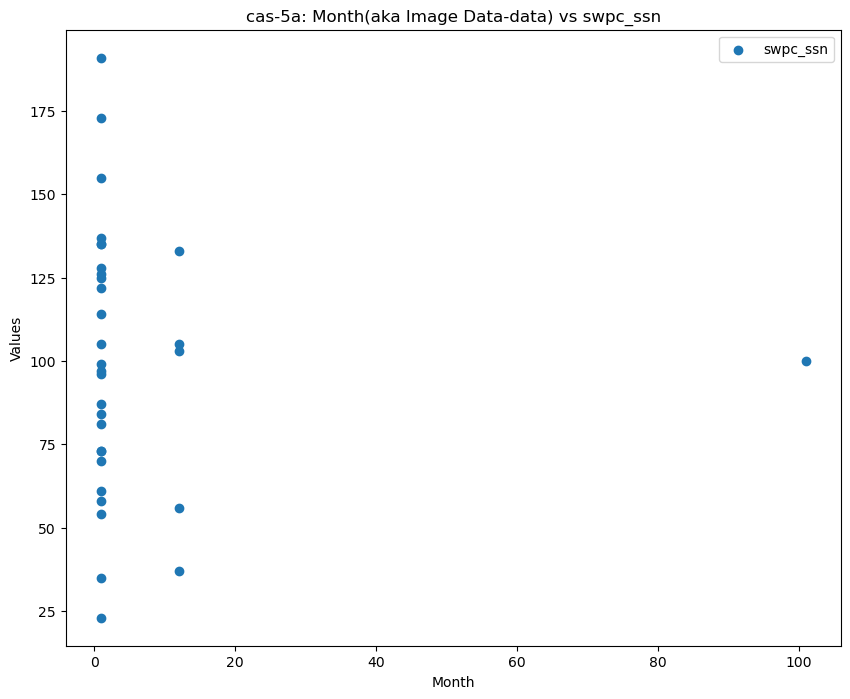

+---------+------------+------------+
|         |        Day |   swpc_ssn |
|---------+------------+------------|
| count   |  32        |  32        |
| mean    |  17.25     |  99.0938   |
| std     |  20.119    |  39.7454   |
| min     |   8        |  23        |
| 25%     |  11.25     |  72.25     |
| 50%     |  15        |  99.5      |
| 75%     |  17        | 126.5      |
| max     | 126        | 191        |
| Chi2    | 176.519    | 176.519    |
| P-value |   0.310875 |   0.310875 |
+---------+------------+------------+
Correlation [Day] vs [swpc_ssn]: pearson=[0.00025212999964088534], spearman=[-0.17115355479317643], kendal_tau=[-0.12354529289016038]


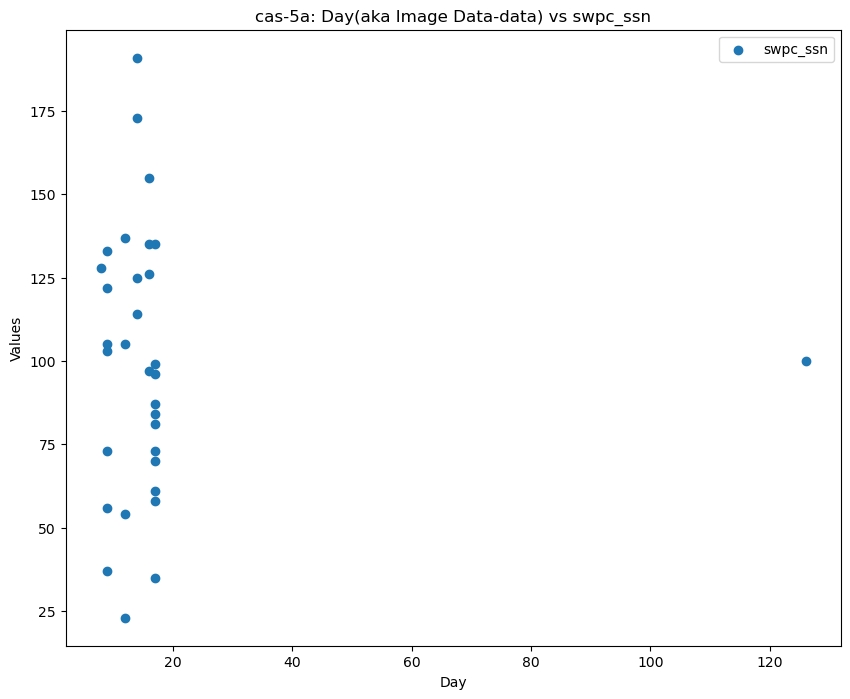

+---------+------------+------------+
|         |       Hour |   swpc_ssn |
|---------+------------+------------|
| count   |  32        |  32        |
| mean    |   7.40625  |  99.0938   |
| std     |  13.1047   |  39.7454   |
| min     |   1        |  23        |
| 25%     |   1        |  72.25     |
| 50%     |   3        |  99.5      |
| 75%     |  11        | 126.5      |
| max     |  73        | 191        |
| Chi2    | 259.733    | 259.733    |
| P-value |   0.355455 |   0.355455 |
+---------+------------+------------+
Correlation [Hour] vs [swpc_ssn]: pearson=[-0.024105600930706315], spearman=[0.11694020462269497], kendal_tau=[0.09658021523770026]


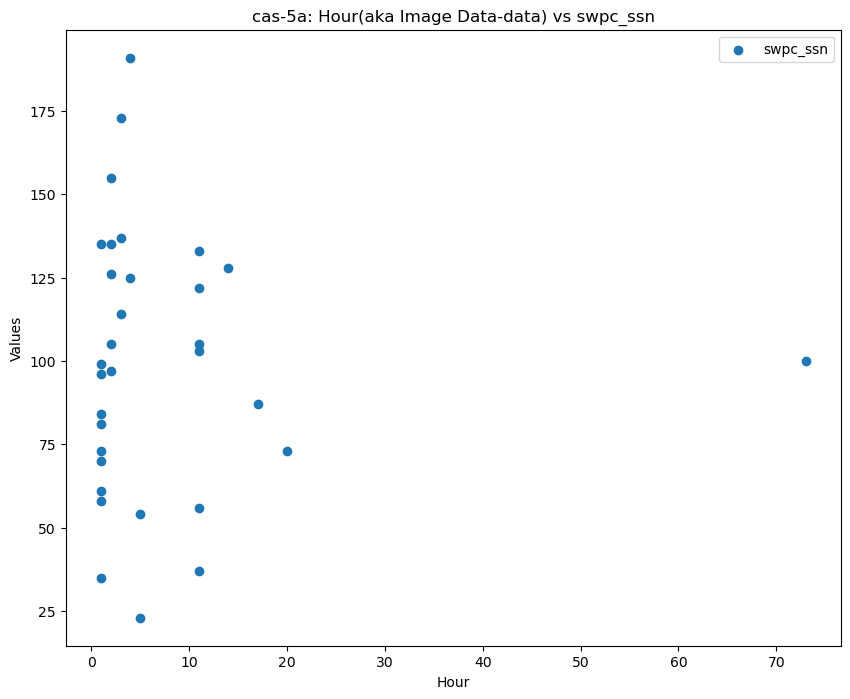

+---------+------------+------------+
|         |     Minute |   swpc_ssn |
|---------+------------+------------|
| count   |  32        |  32        |
| mean    |  36.2812   |  99.0938   |
| std     |  18.1876   |  39.7454   |
| min     |   1        |  23        |
| 25%     |  22.5      |  72.25     |
| 50%     |  45        |  99.5      |
| 75%     |  51.25     | 126.5      |
| max     |  56        | 191        |
| Chi2    | 621.333    | 621.333    |
| P-value |   0.165131 |   0.165131 |
+---------+------------+------------+
Correlation [Minute] vs [swpc_ssn]: pearson=[-0.3881385503930872], spearman=[-0.3526120201330666], kendal_tau=[-0.2500131233458113]


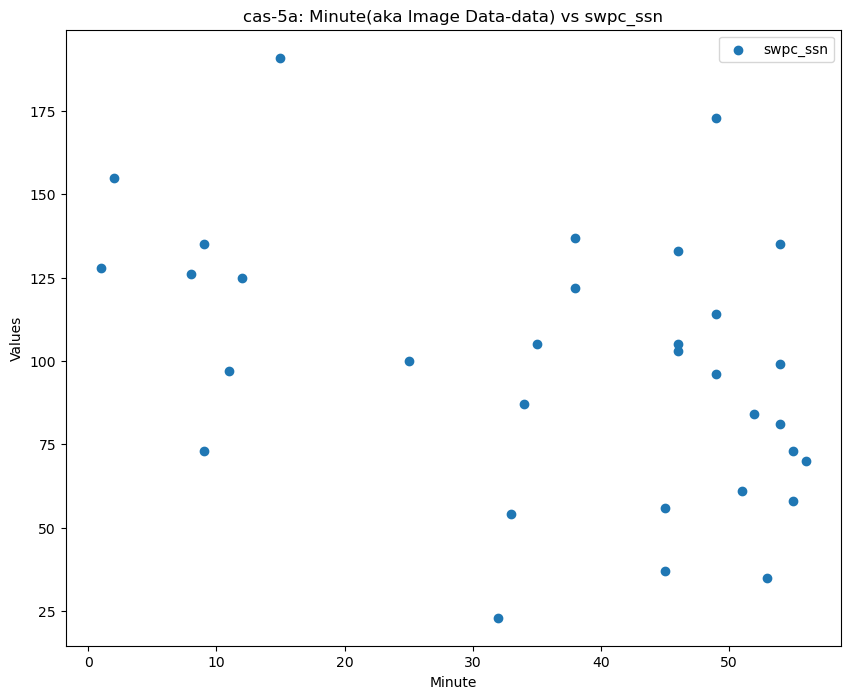

+---------+------------+------------+
|         |     Second |   swpc_ssn |
|---------+------------+------------|
| count   |  32        |  32        |
| mean    |  29.625    |  99.0938   |
| std     |  18.9936   |  39.7454   |
| min     |   4        |  23        |
| 25%     |  14.75     |  72.25     |
| 50%     |  27        |  99.5      |
| 75%     |  50        | 126.5      |
| max     |  59        | 191        |
| Chi2    | 618.667    | 618.667    |
| P-value |   0.184452 |   0.184452 |
+---------+------------+------------+
Correlation [Second] vs [swpc_ssn]: pearson=[-0.4251252145785767], spearman=[-0.3605988063219696], kendal_tau=[-0.245914547553257]


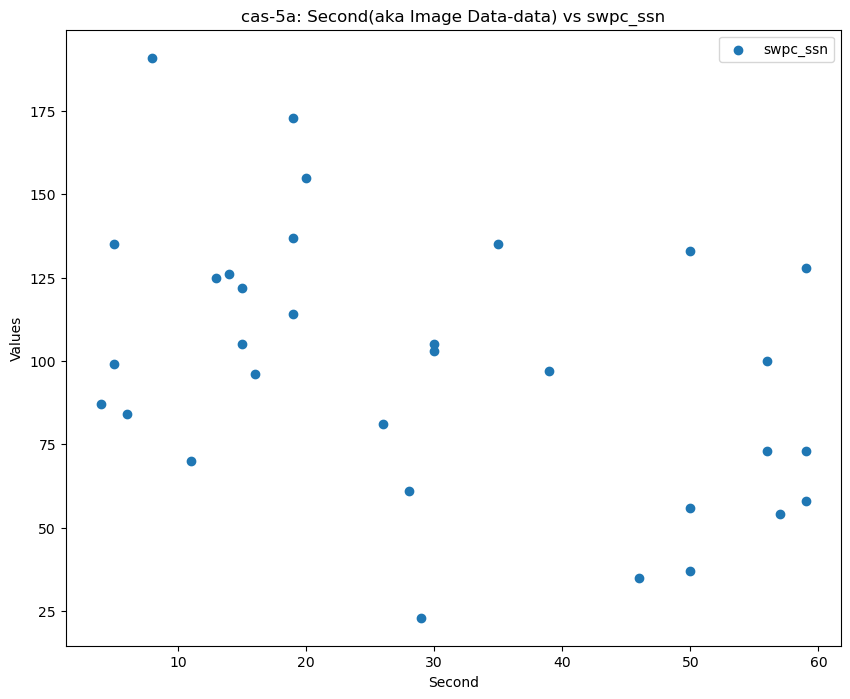

+---------+-----------+------------+
|         |     CAM # |   swpc_ssn |
|---------+-----------+------------|
| count   | 32        |  32        |
| mean    |  2.28125  |  99.0938   |
| std     |  4.20625  |  39.7454   |
| min     |  1        |  23        |
| 25%     |  1        |  72.25     |
| 50%     |  1        |  99.5      |
| 75%     |  2        | 126.5      |
| max     | 25        | 191        |
| Chi2    | 93.3333   |  93.3333   |
| P-value |  0.227827 |   0.227827 |
+---------+-----------+------------+
Correlation [CAM #] vs [swpc_ssn]: pearson=[0.023570647283331712], spearman=[0.0546746088293006], kendal_tau=[0.0623023652108739]


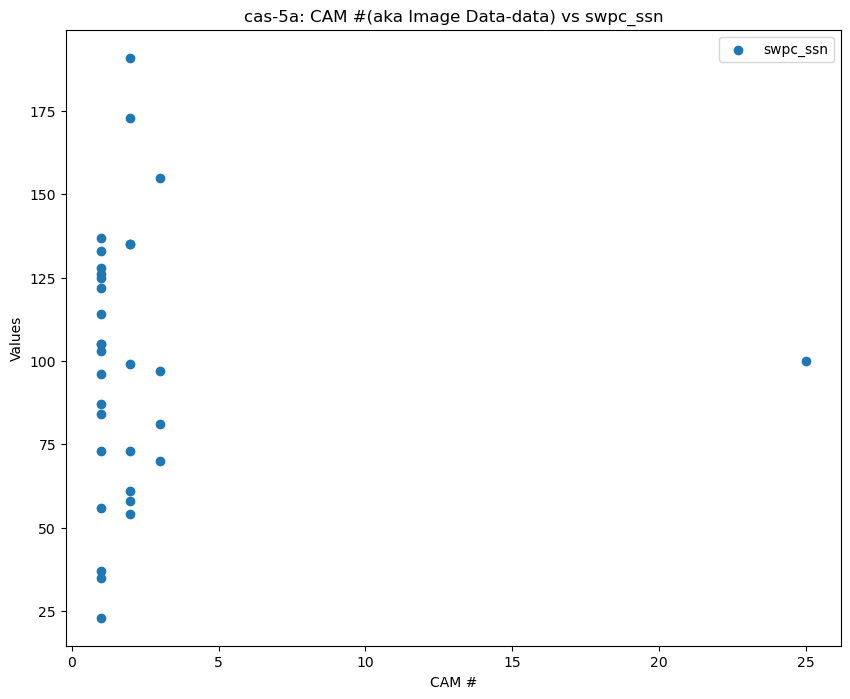

+---------+------------+------------+
|         |    Photo # |   swpc_ssn |
|---------+------------+------------|
| count   |  32        |  32        |
| mean    |  46.375    |  99.0938   |
| std     |  96.6856   |  39.7454   |
| min     |   5        |  23        |
| 25%     |  20.5      |  72.25     |
| 50%     |  33        |  99.5      |
| 75%     |  42.25     | 126.5      |
| max     | 571        | 191        |
| Chi2    | 784        | 784        |
| P-value |   0.233162 |   0.233162 |
+---------+------------+------------+
Correlation [Photo #] vs [swpc_ssn]: pearson=[-0.0008488822918718363], spearman=[-0.14342044993818462], kendal_tau=[-0.09543152126132898]


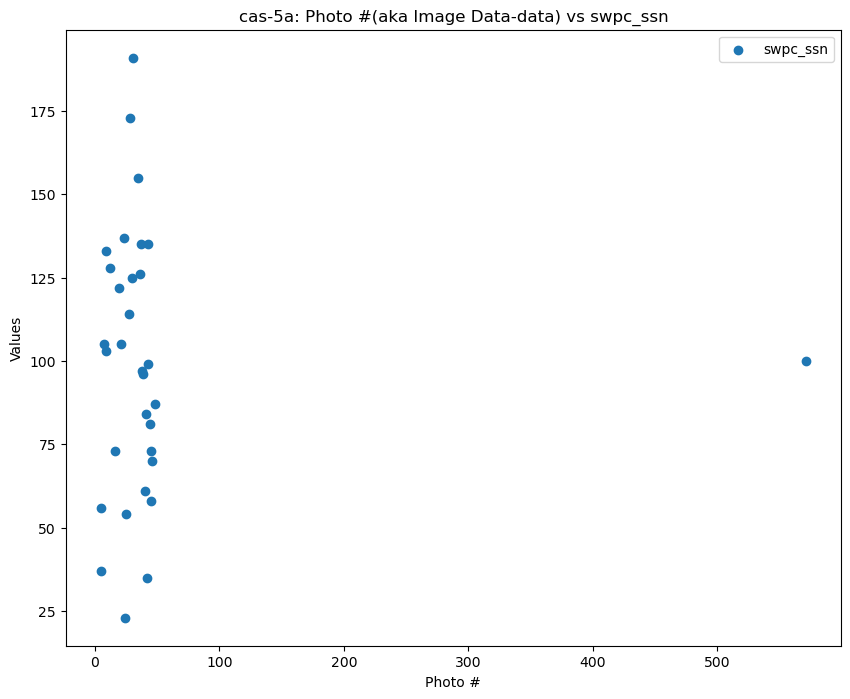

+---------+-------------+------------+
|         |     Frm Len |   swpc_ssn |
|---------+-------------+------------|
| count   |   32        |  32        |
| mean    |  473.562    |  99.0938   |
| std     | 1230.72     |  39.7454   |
| min     |  256        |  23        |
| 25%     |  256        |  72.25     |
| 50%     |  256        |  99.5      |
| 75%     |  256        | 126.5      |
| max     | 7218        | 191        |
| Chi2    |   32        |  32        |
| P-value |    0.274511 |   0.274511 |
+---------+-------------+------------+
Correlation [Frm Len] vs [swpc_ssn]: pearson=[0.004160772043172696], spearman=[0.009728847493313403], kendal_tau=[0.008089015981310748]


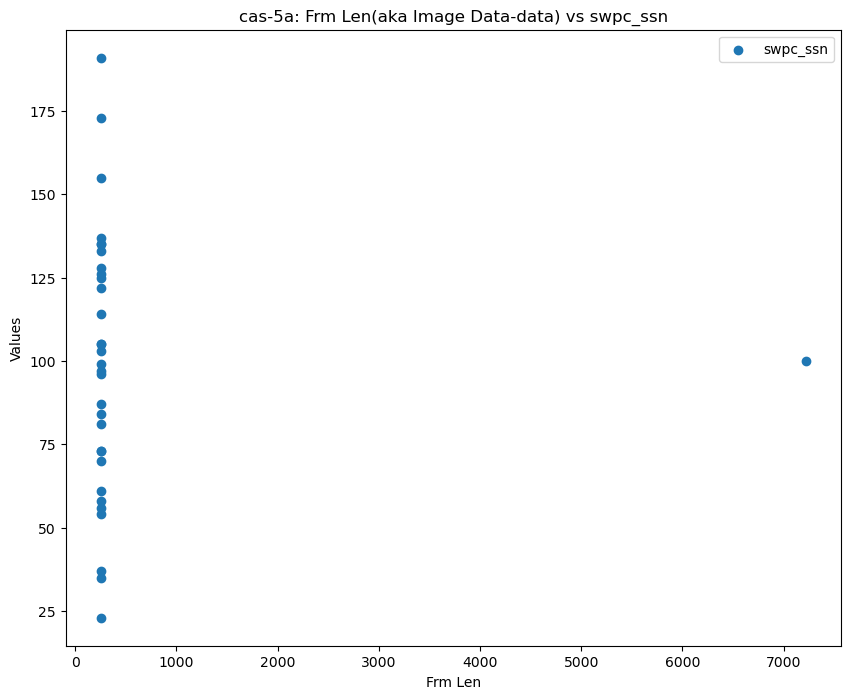

+---------+--------------+------------+
|         |   Frm Seq Nr |   swpc_ssn |
|---------+--------------+------------|
| count   |    32        |  32        |
| mean    |  1824.12     |  99.0938   |
| std     |  8744.21     |  39.7454   |
| min     |    53        |  23        |
| 25%     |   207.125    |  72.25     |
| 50%     |   271.75     |  99.5      |
| 75%     |   332.5      | 126.5      |
| max     | 49739        | 191        |
| Chi2    |   864        | 864        |
| P-value |     0.275493 |   0.275493 |
+---------+--------------+------------+
Correlation [Frm Seq Nr] vs [swpc_ssn]: pearson=[0.006504439175418133], spearman=[0.14191419380456588], kendal_tau=[0.08502041711162331]


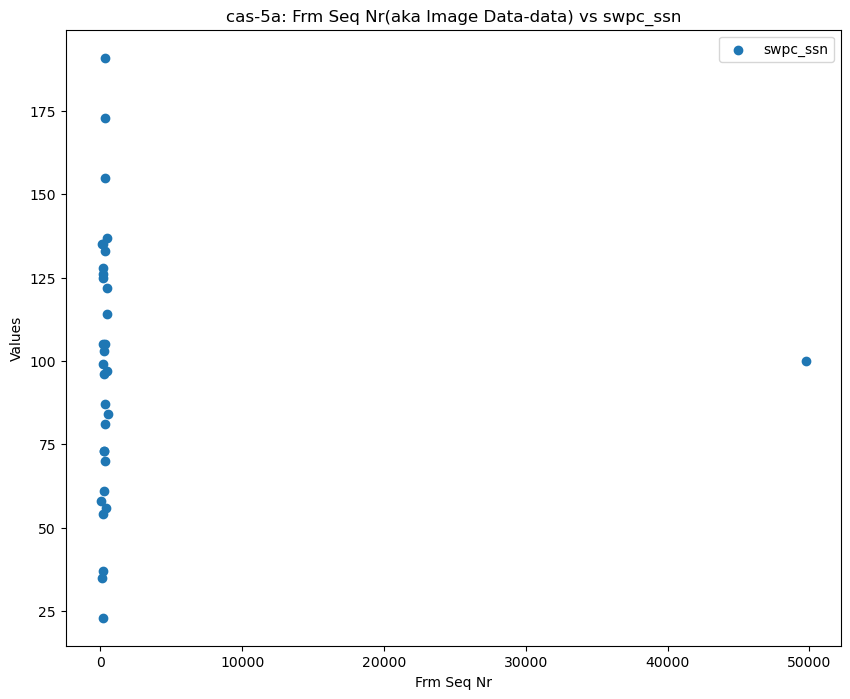

+---------+--------------+------------+
|         |        Total |   swpc_ssn |
|---------+--------------+------------|
| count   |    32        |  32        |
| mean    |  1423.69     |  99.0938   |
| std     |  4479.42     |  39.7454   |
| min     |   243        |  23        |
| 25%     |   456.25     |  72.25     |
| 50%     |   579        |  99.5      |
| 75%     |   744.25     | 126.5      |
| max     | 25928        | 191        |
| Chi2    |   666.667    | 666.667    |
| P-value |     0.260163 |   0.260163 |
+---------+--------------+------------+
Correlation [Total] vs [swpc_ssn]: pearson=[0.011064596270161164], spearman=[0.16331776925627284], kendal_tau=[0.11836956546454111]


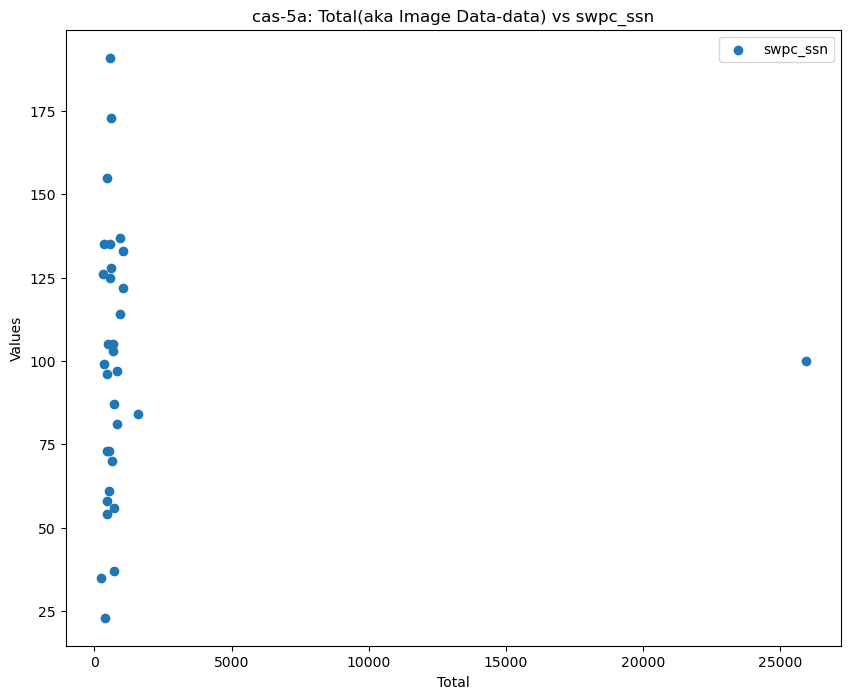

2024-02-11 18:21:29,751 - DEBUG - Processing file: [../data/cas-5a/Last Frame Rcvd By-data-2024-02-11 02 22 06.csv]


+---------+------------------------------------+------------+
|         |   observer where 0 is DK3WN-JN49lr |   swpc_ssn |
|---------+------------------------------------+------------|
| count   |                                  1 |          1 |
| mean    |                                  0 |         33 |
| std     |                                nan |        nan |
| min     |                                  0 |         33 |
| 25%     |                                  0 |         33 |
| 50%     |                                  0 |         33 |
| 75%     |                                  0 |         33 |
| max     |                                  0 |         33 |
| Chi2    |                                  0 |          0 |
| P-value |                                  1 |          1 |
+---------+------------------------------------+------------+
Correlation [observer where 0 is DK3WN-JN49lr] vs [swpc_ssn]: pearson=[nan], spearman=[nan], kendal_tau=[nan]


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


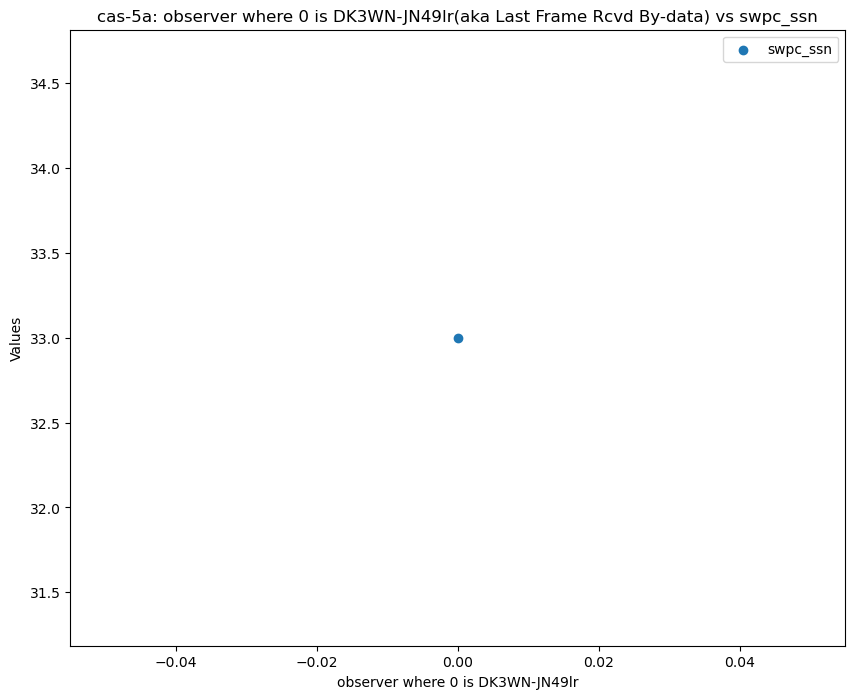

2024-02-11 18:21:29,896 - DEBUG - Processing file: [../data/cas-5a/Operating Mode-data-2024-02-11 02 23 19.csv]


In [204]:
analyze_satellite('cas-5a')

2024-02-11 18:21:30,097 - DEBUG - Processing file: [../data/cubebel-1/Solar Voltage-data-2024-02-11 02 19 56.csv]


+---------+------------------+---------------+
|         |   43666.distinct |      swpc_ssn |
|---------+------------------+---------------|
| count   |     118          |  118          |
| mean    |       4.80042    |   43.7203     |
| std     |       0.306796   |   45.0096     |
| min     |       3.1        |    0          |
| 25%     |       4.8        |   11          |
| 50%     |       4.9        |   25          |
| 75%     |       4.95       |   76.5        |
| max     |       5.05       |  176          |
| Chi2    |    1121.16       | 1121.16       |
| P-value |       1.2168e-05 |    1.2168e-05 |
+---------+------------------+---------------+
Correlation [43666.distinct] vs [swpc_ssn]: pearson=[0.18077471127101538], spearman=[0.265121452157792], kendal_tau=[0.19735697842488076]


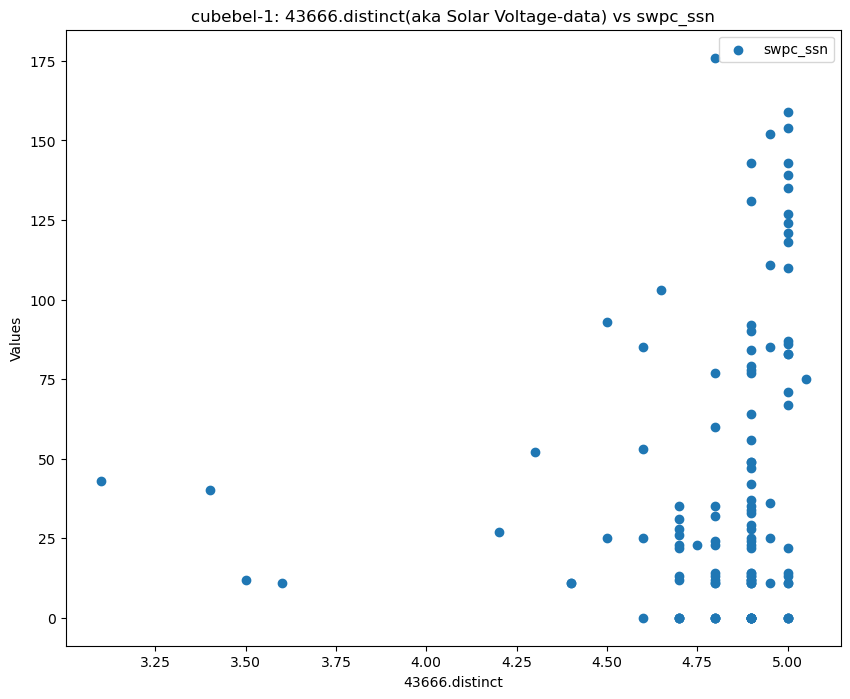

2024-02-11 18:21:30,286 - DEBUG - Processing file: [../data/cubebel-1/System 3.3V Voltage-data-2024-02-11 02 19 52.csv]


+---------+------------------+------------+
|         |   43666.distinct |   swpc_ssn |
|---------+------------------+------------|
| count   |       118        | 118        |
| mean    |         3.27627  |  43.7203   |
| std     |         0.306532 |  45.0096   |
| min     |         0        |   0        |
| 25%     |         3.3      |  11        |
| 50%     |         3.3      |  25        |
| 75%     |         3.3      |  76.5      |
| max     |         3.7      | 176        |
| Chi2    |       159.591    | 159.591    |
| P-value |         0.776024 |   0.776024 |
+---------+------------------+------------+
Correlation [43666.distinct] vs [swpc_ssn]: pearson=[-0.026503596099076522], spearman=[-0.10026909635421952], kendal_tau=[-0.08259265975656294]


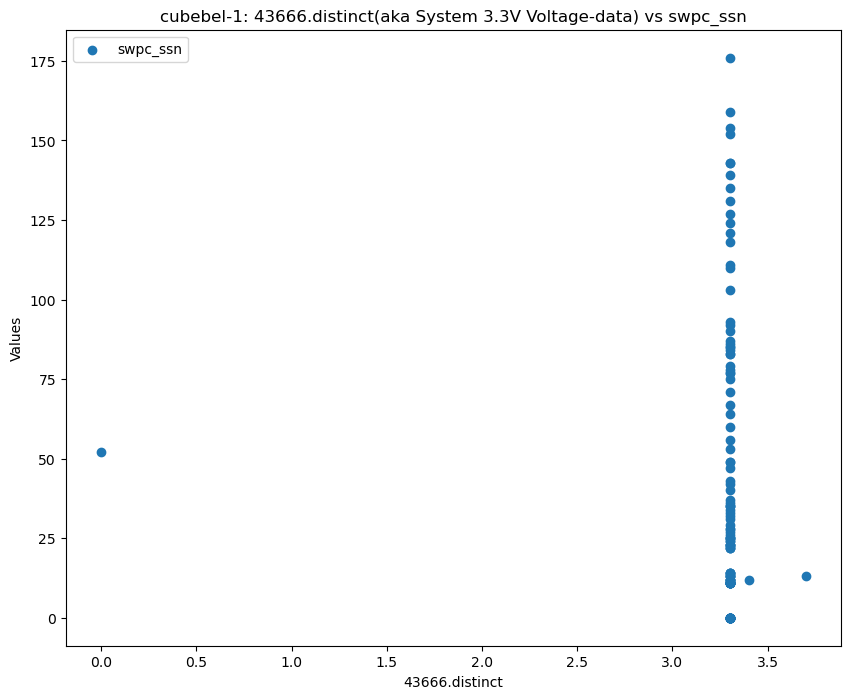

2024-02-11 18:21:30,479 - DEBUG - Processing file: [../data/cubebel-1/System 5V Voltage-data-2024-02-11 02 19 58.csv]


+---------+------------------+---------------+
|         |   43666.distinct |      swpc_ssn |
|---------+------------------+---------------|
| count   |    118           | 118           |
| mean    |      5.11318     |  43.7203      |
| std     |      0.472957    |  45.0096      |
| min     |      0.055       |   0           |
| 25%     |      5.1         |  11           |
| 50%     |      5.2         |  25           |
| 75%     |      5.2         |  76.5         |
| max     |      5.2         | 176           |
| Chi2    |    310.892       | 310.892       |
| P-value |      0.000412416 |   0.000412416 |
+---------+------------------+---------------+
Correlation [43666.distinct] vs [swpc_ssn]: pearson=[-0.010007486535809882], spearman=[0.05107073212261531], kendal_tau=[0.034547510107492956]


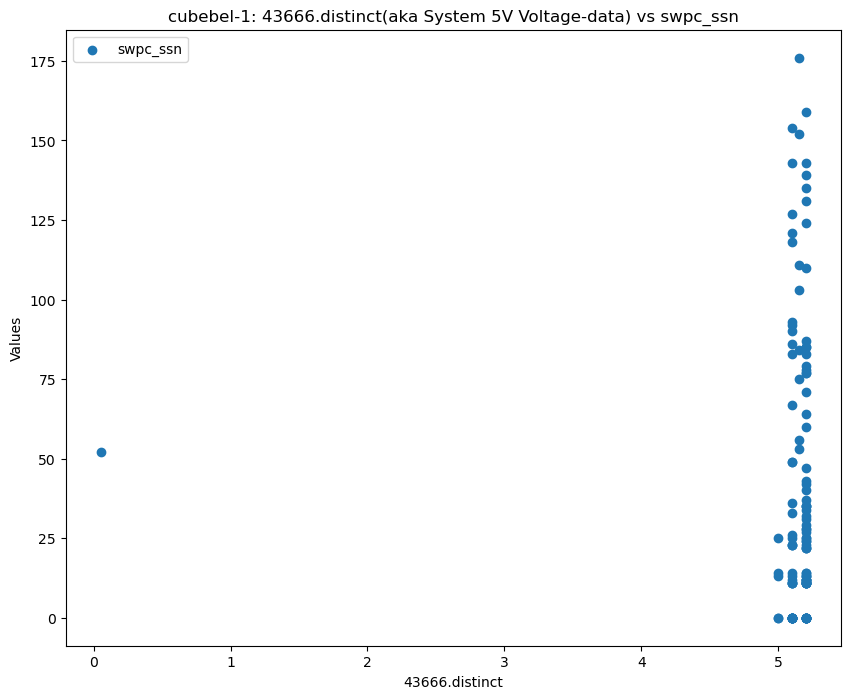

2024-02-11 18:21:30,641 - DEBUG - Processing file: [../data/cubebel-1/System Currents-data-2024-02-11 02 19 49.csv]


+---------+--------------------+-----------------+
|         |   After BQ Current |        swpc_ssn |
|---------+--------------------+-----------------|
| count   |      626           |   626           |
| mean    |      147.928       |    24.5767      |
| std     |       42.4223      |    29.9056      |
| min     |        1.7         |     0           |
| 25%     |      131.625       |    11           |
| 50%     |      141           |    14           |
| 75%     |      159.5         |    28.75        |
| max     |      683           |   176           |
| Chi2    |    18839.3         | 18839.3         |
| P-value |        5.36654e-24 |     5.36654e-24 |
+---------+--------------------+-----------------+
Correlation [After BQ Current] vs [swpc_ssn]: pearson=[-0.25236920606970487], spearman=[-0.2843878766329617], kendal_tau=[-0.20113822861732475]


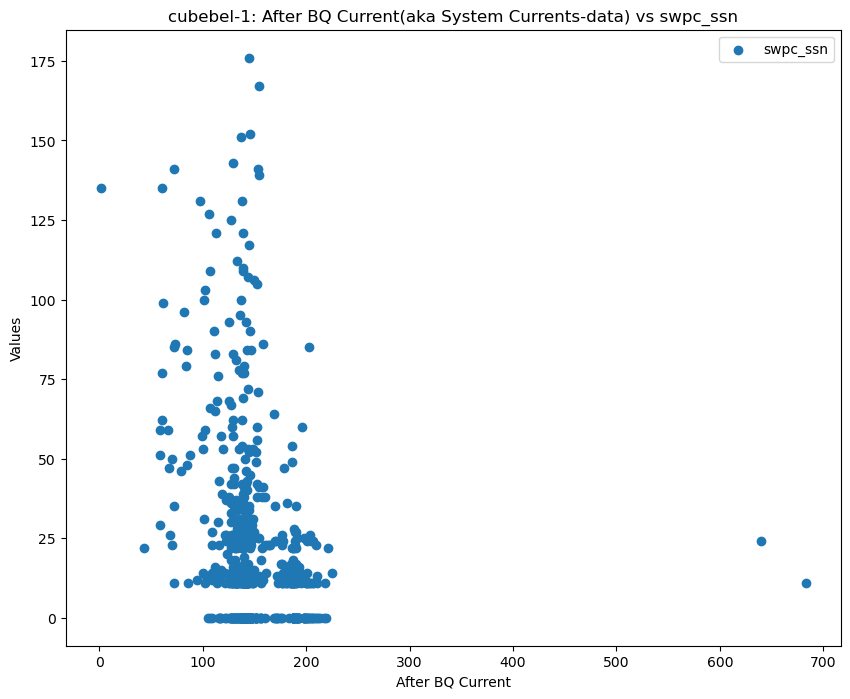

In [205]:
analyze_satellite('cubebel-1')

2024-02-11 18:21:30,830 - DEBUG - Processing file: [../data/cubebel-2/MB Reset Reason-data-2024-02-11 02 22 30.csv]
2024-02-11 18:21:30,849 - WARNING - Column 'last' is nearly constant, skipping.
2024-02-11 18:21:30,852 - DEBUG - Processing file: [../data/cubebel-2/Solar Panel Voltages-data-2024-02-11 02 21 48.csv]


+---------+----------------------------------+-------------+
|         |   tlm_mb_solarpanel_0_volt_pos V |    swpc_ssn |
|---------+----------------------------------+-------------|
| count   |                       224        |  224        |
| mean    |                         4.93581  |  115.875    |
| std     |                         0.726483 |   39.7821   |
| min     |                         0.0021   |   25        |
| 25%     |                         5        |   88.75     |
| 50%     |                         5.075    |  119        |
| 75%     |                         5.2      |  142.25     |
| max     |                         5.5      |  227        |
| Chi2    |                      3114.31     | 3114.31     |
| P-value |                         0.998913 |    0.998913 |
+---------+----------------------------------+-------------+
Correlation [tlm_mb_solarpanel_0_volt_pos V] vs [swpc_ssn]: pearson=[-0.022017819056829396], spearman=[0.12979653332133329], kendal_tau=[0.0949366

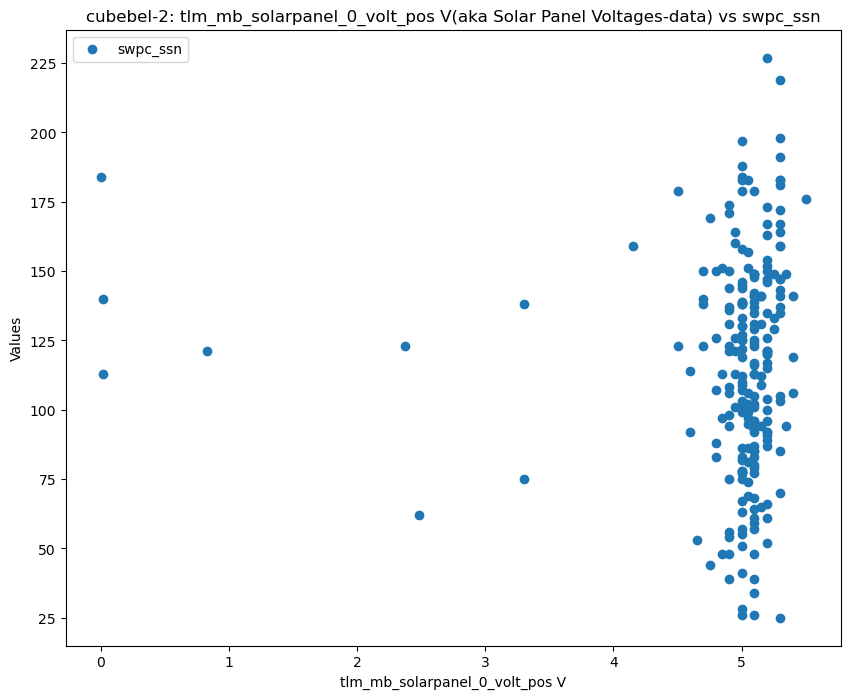

2024-02-11 18:21:31,019 - DEBUG - Processing file: [../data/cubebel-2/Solar Panels Current-data-2024-02-11 02 21 58.csv]


+---------+--------------------+------------+
|         |   57175.distinct A |   swpc_ssn |
|---------+--------------------+------------|
| count   |          34        |  34        |
| mean    |           0.264706 | 116.647    |
| std     |           0.120309 |  37.0216   |
| min     |           0        |  28        |
| 25%     |           0.2      |  95        |
| 50%     |           0.2      | 121        |
| 75%     |           0.375    | 138        |
| max     |           0.5      | 179        |
| Chi2    |          92.0318   |  92.0318   |
| P-value |           0.702517 |   0.702517 |
+---------+--------------------+------------+
Correlation [57175.distinct A] vs [swpc_ssn]: pearson=[0.3230075753530439], spearman=[0.30822504540385015], kendal_tau=[0.25260828562166626]


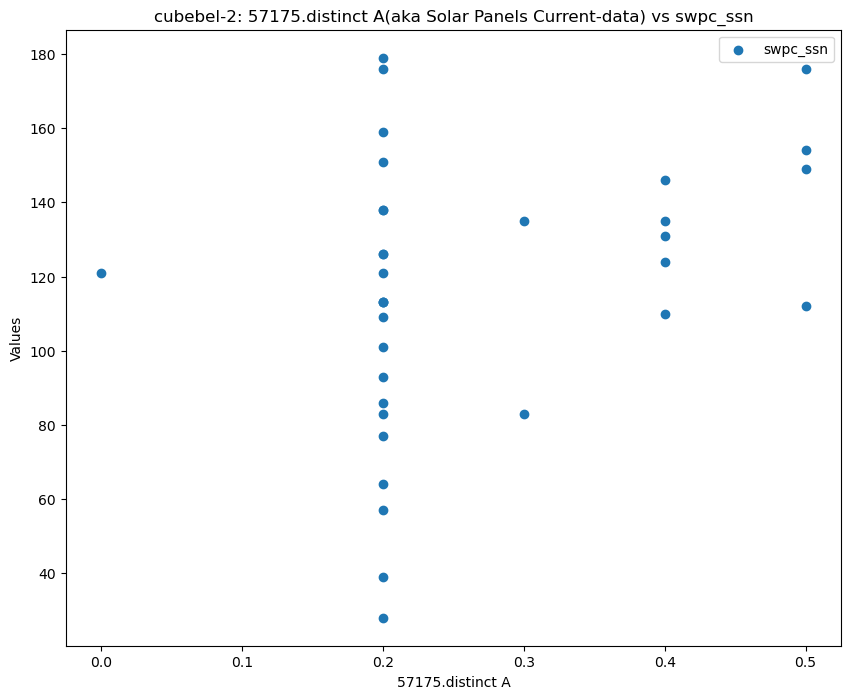

2024-02-11 18:21:31,187 - DEBUG - Processing file: [../data/cubebel-2/TRX Primary Current-data-2024-02-11 02 21 54.csv]


+---------+--------------------+------------+
|         |   57175.distinct A |   swpc_ssn |
|---------+--------------------+------------|
| count   |        34          |  34        |
| mean    |         0.0997059  | 116.647    |
| std     |         0.00171499 |  37.0216   |
| min     |         0.09       |  28        |
| 25%     |         0.1        |  95        |
| 50%     |         0.1        | 121        |
| 75%     |         0.1        | 138        |
| max     |         0.1        | 179        |
| Chi2    |        16.4848     |  16.4848   |
| P-value |         0.899624   |   0.899624 |
+---------+--------------------+------------+
Correlation [57175.distinct A] vs [swpc_ssn]: pearson=[-0.28327781844254746], spearman=[-0.2663581252763734], kendal_tau=[-0.2222771122371935]


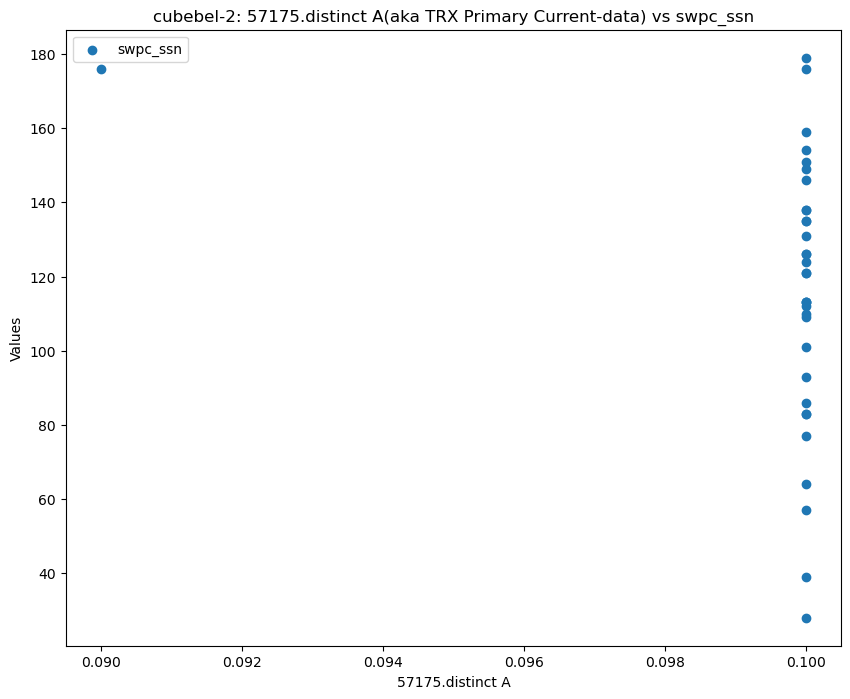

2024-02-11 18:21:31,369 - DEBUG - Processing file: [../data/cubebel-2/TRX Reset Reason-data-2024-02-11 02 22 32.csv]
2024-02-11 18:21:31,394 - WARNING - Column 'last' is nearly constant, skipping.
2024-02-11 18:21:31,397 - DEBUG - Processing file: [../data/cubebel-2/TRX Secondary Current-data-2024-02-11 02 21 52.csv]


+---------+--------------------+------------+
|         |   57175.distinct A |   swpc_ssn |
|---------+--------------------+------------|
| count   |        34          |  34        |
| mean    |         0.0983824  | 116.647    |
| std     |         0.00342021 |  37.0216   |
| min     |         0.09       |  28        |
| 25%     |         0.1        |  95        |
| 50%     |         0.1        | 121        |
| 75%     |         0.1        | 138        |
| max     |         0.1        | 179        |
| Chi2    |        44.966      |  44.966    |
| P-value |         0.675104   |   0.675104 |
+---------+--------------------+------------+
Correlation [57175.distinct A] vs [swpc_ssn]: pearson=[0.15091190530418408], spearman=[0.16597661479923714], kendal_tau=[0.1260903130077535]


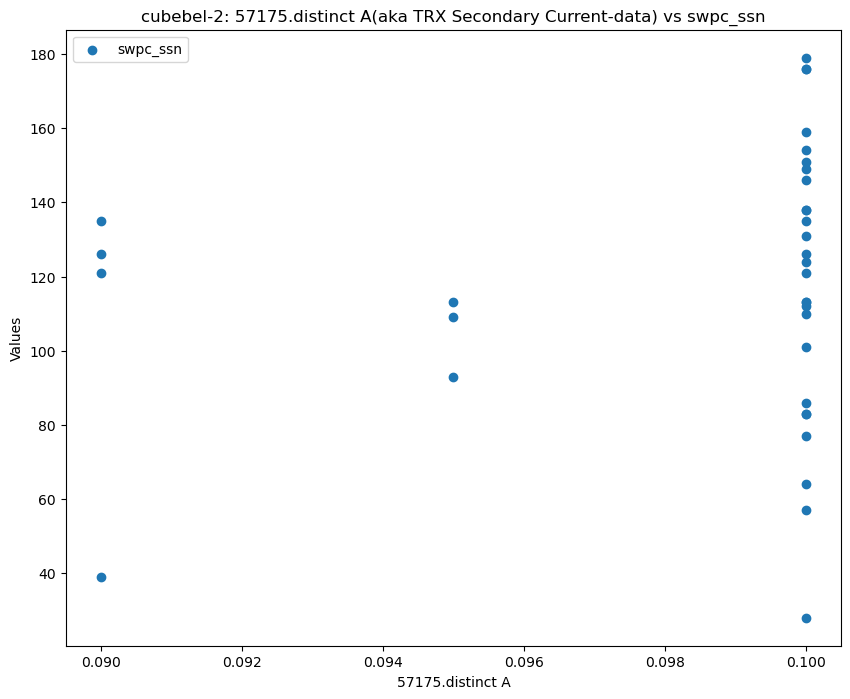

2024-02-11 18:21:31,585 - DEBUG - Processing file: [../data/cubebel-2/TRX Temperature-data-2024-02-11 02 22 07.csv]


+---------+-----------------------+------------+
|         |   57175.distinct (°C) |   swpc_ssn |
|---------+-----------------------+------------|
| count   |             35        |  35        |
| mean    |             21.7416   | 116.771    |
| std     |             39.5923   |  36.4805   |
| min     |             10.38     |  28        |
| 25%     |             12.625    |  97        |
| 50%     |             15.19     | 121        |
| 75%     |             16.22     | 138        |
| max     |            248.13     | 179        |
| Chi2    |            790.417    | 790.417    |
| P-value |              0.342399 |   0.342399 |
+---------+-----------------------+------------+
Correlation [57175.distinct (°C)] vs [swpc_ssn]: pearson=[0.2841065280256999], spearman=[0.03975043040790226], kendal_tau=[0.02891223361951317]


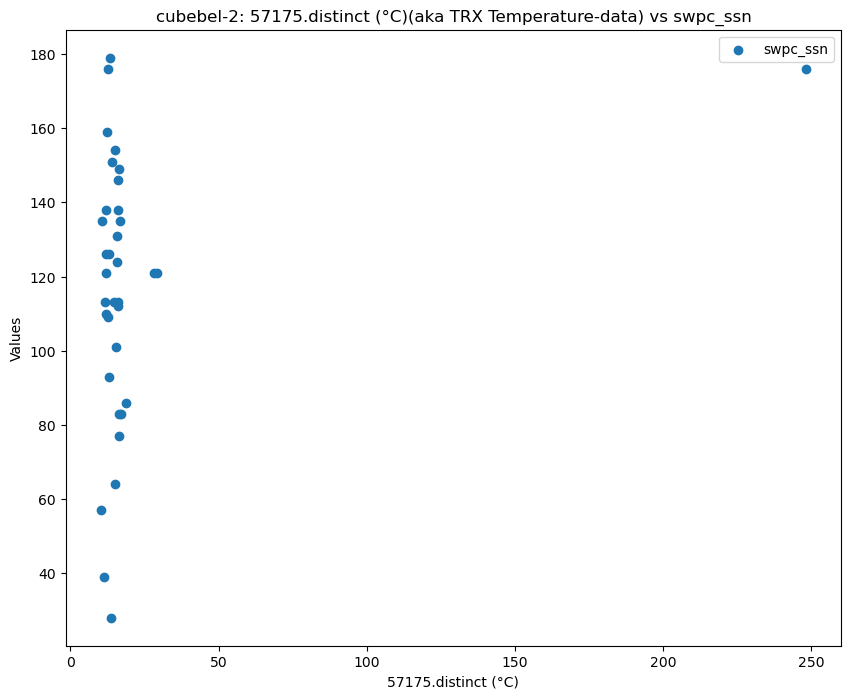

2024-02-11 18:21:31,776 - DEBUG - Processing file: [../data/cubebel-2/TRX Temperatures-data-2024-02-11 02 22 21.csv]


+---------+-----------------------------+-------------+
|         |   tlm_trx_cmn_mcu_temp (°C) |    swpc_ssn |
|---------+-----------------------------+-------------|
| count   |                  225        |  225        |
| mean    |                   11.6267   |  115.973    |
| std     |                    3.88544  |   39.7206   |
| min     |                   -0.5      |   25        |
| 25%     |                    9        |   89        |
| 50%     |                   12        |  119        |
| 75%     |                   14.5      |  142        |
| max     |                   28        |  227        |
| Chi2    |                 4462.29     | 4462.29     |
| P-value |                    0.403912 |    0.403912 |
+---------+-----------------------------+-------------+
Correlation [tlm_trx_cmn_mcu_temp (°C)] vs [swpc_ssn]: pearson=[-0.1335898597307741], spearman=[-0.1267867890514931], kendal_tau=[-0.08656788064704421]


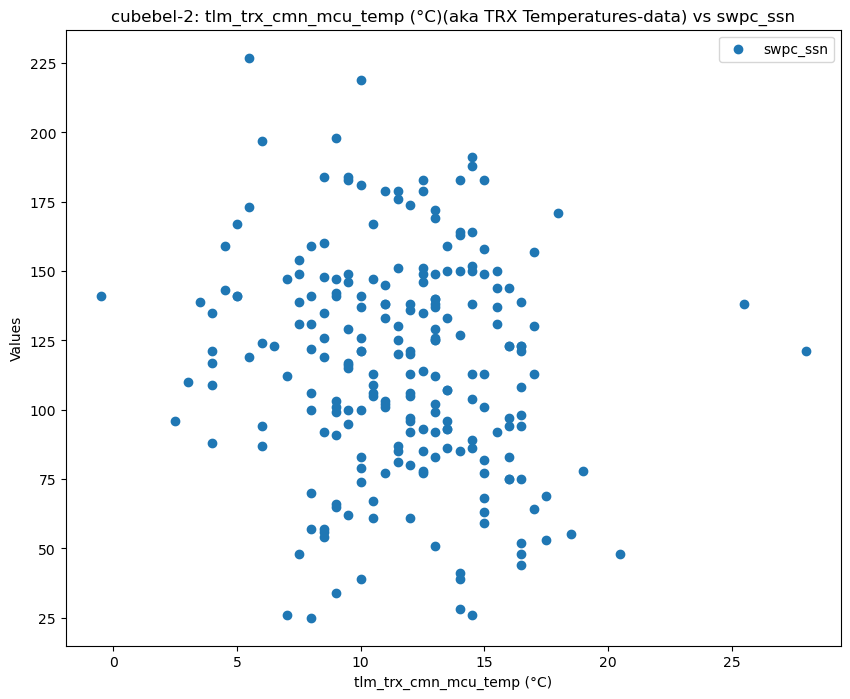

2024-02-11 18:21:31,975 - DEBUG - Processing file: [../data/cubebel-2/Voltages-data-2024-02-11 02 21 34.csv]


+---------+--------------------+------------+
|         |   tlm_mb_ant_1_v V |   swpc_ssn |
|---------+--------------------+------------|
| count   |      224           |   224      |
| mean    |        0.00827813  |   115.875  |
| std     |        0.000409215 |    39.7821 |
| min     |        0.0035      |    25      |
| 25%     |        0.0084      |    88.75   |
| 50%     |        0.0084      |   119      |
| 75%     |        0.0084      |   142.25   |
| max     |        0.0091      |   227      |
| Chi2    |      230.174       |   230.174  |
| P-value |        1           |     1      |
+---------+--------------------+------------+
Correlation [tlm_mb_ant_1_v V] vs [swpc_ssn]: pearson=[0.004844633466461593], spearman=[-0.0020850223016425323], kendal_tau=[-0.0016313239741044382]


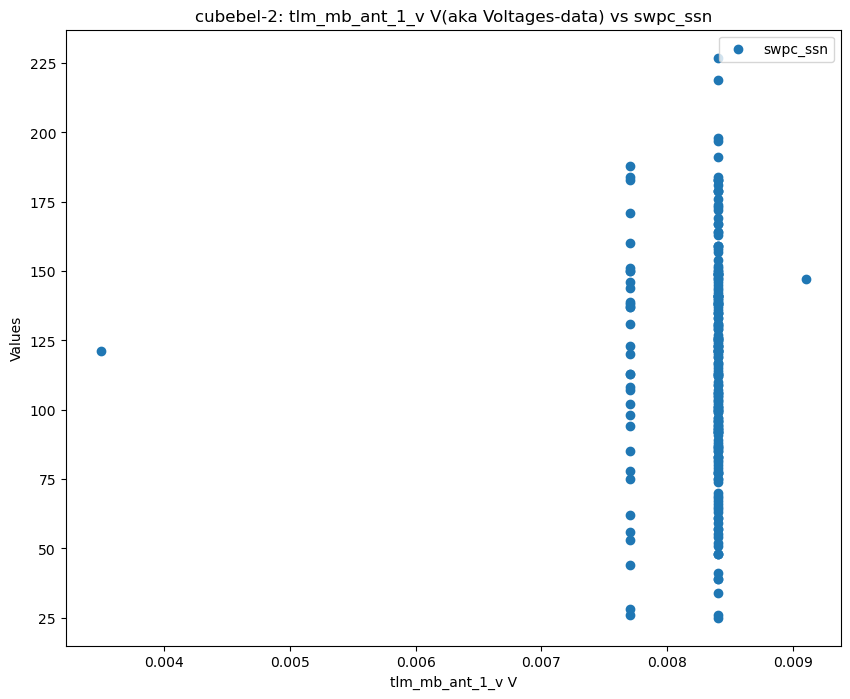

2024-02-11 18:21:32,170 - DEBUG - Processing file: [../data/cubebel-2/ADC Temperatures-data-2024-02-11 02 21 40.csv]


+---------+--------------------------+--------------+
|         |   tlm_mb_adc_temp_1 (°C) |     swpc_ssn |
|---------+--------------------------+--------------|
| count   |               224        |   224        |
| mean    |                21.331    |   115.875    |
| std     |                74.8435   |    39.7821   |
| min     |                 2.6      |    25        |
| 25%     |                 6.7      |    88.75     |
| 50%     |                 8.775    |   119        |
| 75%     |                11        |   142.25     |
| max     |               505        |   227        |
| Chi2    |             13119.4      | 13119.4      |
| P-value |                 0.402167 |     0.402167 |
+---------+--------------------------+--------------+
Correlation [tlm_mb_adc_temp_1 (°C)] vs [swpc_ssn]: pearson=[0.014152016835721211], spearman=[-0.10660823483144659], kendal_tau=[-0.07170476343404308]


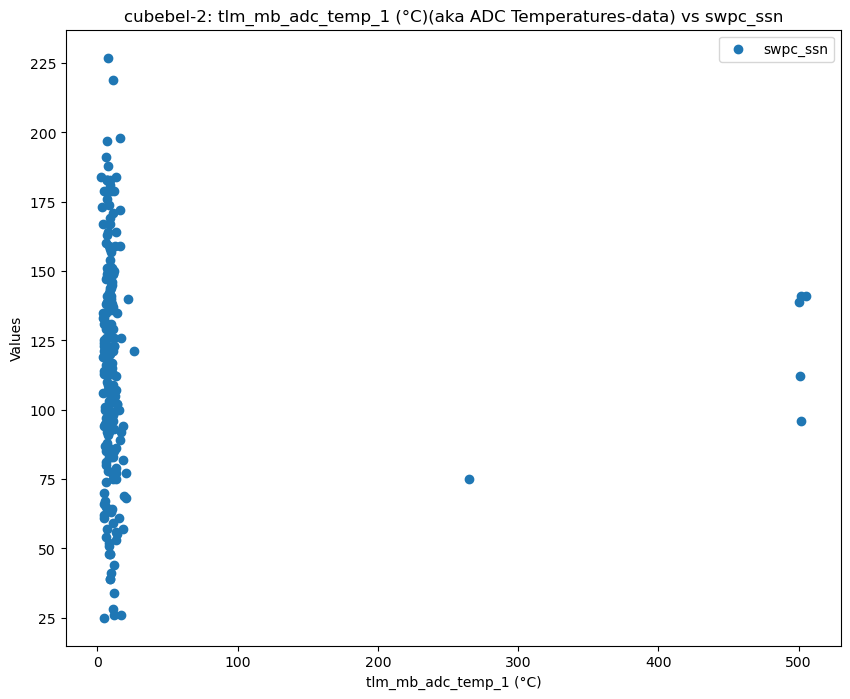

2024-02-11 18:21:32,367 - DEBUG - Processing file: [../data/cubebel-2/Battery 0 Temperature-data-2024-02-11 02 22 13.csv]


+---------+-----------------------+------------+
|         |   57175.distinct (°C) |   swpc_ssn |
|---------+-----------------------+------------|
| count   |             34        |  34        |
| mean    |             49.9857   | 116.647    |
| std     |             84.3248   |  37.0216   |
| min     |             25.85     |  28        |
| 25%     |             33.9862   |  95        |
| 50%     |             36.06     | 121        |
| 75%     |             37.4025   | 138        |
| max     |            527.01     | 179        |
| Chi2    |            850        | 850        |
| P-value |              0.265749 |   0.265749 |
+---------+-----------------------+------------+
Correlation [57175.distinct (°C)] vs [swpc_ssn]: pearson=[0.28264537697330594], spearman=[0.14495417080322923], kendal_tau=[0.09703821302589397]


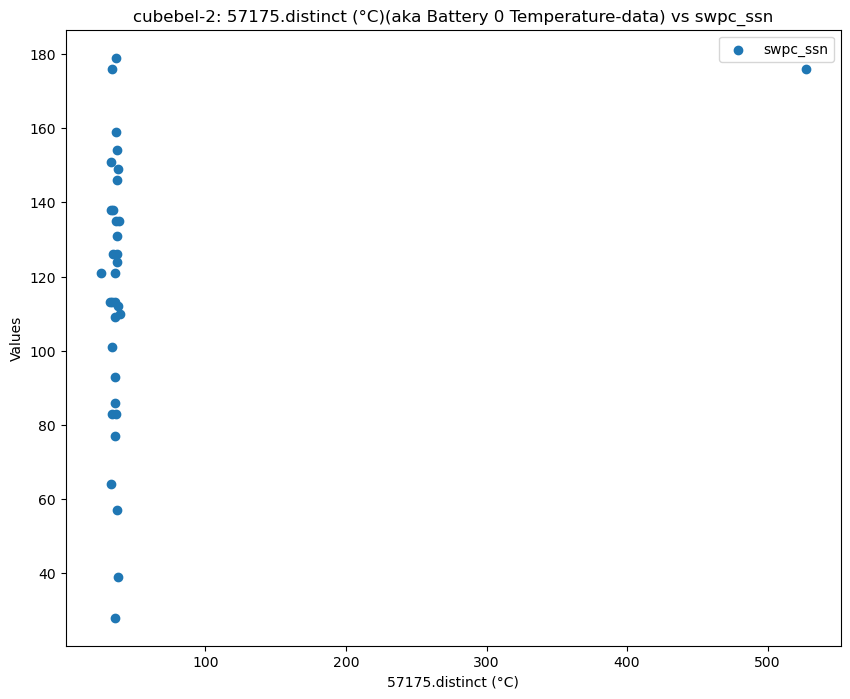

2024-02-11 18:21:32,519 - DEBUG - Processing file: [../data/cubebel-2/Battery 1 Temperature-data-2024-02-11 02 22 10.csv]


+---------+-----------------------+------------+
|         |   57175.distinct (°C) |   swpc_ssn |
|---------+-----------------------+------------|
| count   |             34        |  34        |
| mean    |             49.8893   | 116.647    |
| std     |             84.317    |  37.0216   |
| min     |             26.2      |  28        |
| 25%     |             33.8175   |  95        |
| 50%     |             35.8325   | 121        |
| 75%     |             37.85     | 138        |
| max     |            526.86     | 179        |
| Chi2    |            850        | 850        |
| P-value |              0.265749 |   0.265749 |
+---------+-----------------------+------------+
Correlation [57175.distinct (°C)] vs [swpc_ssn]: pearson=[0.284701678404755], spearman=[0.161467937097268], kendal_tau=[0.09344420513604605]


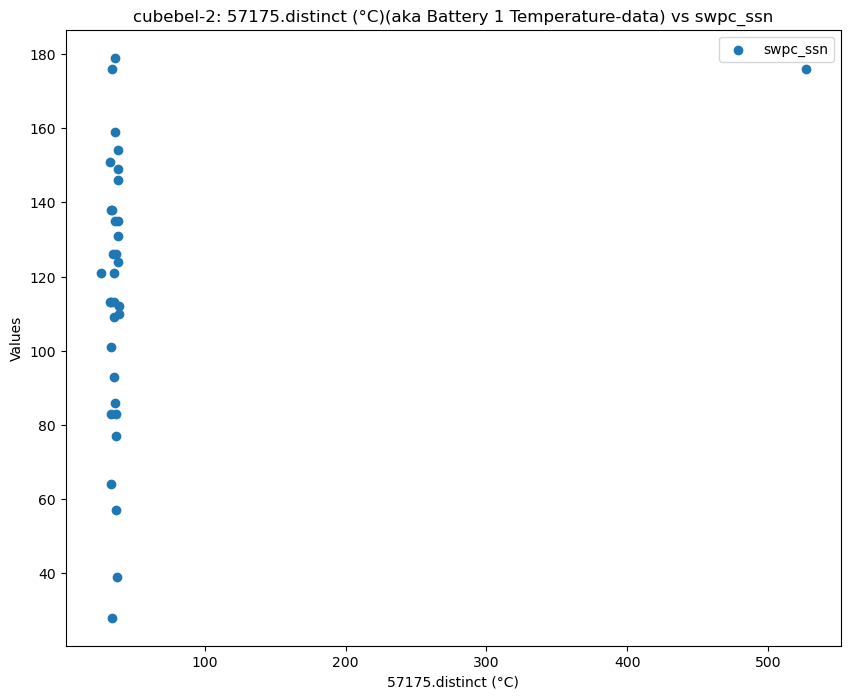

2024-02-11 18:21:32,668 - DEBUG - Processing file: [../data/cubebel-2/Battery Current-data-2024-02-11 02 21 43.csv]


+---------+----------------------------------------------+-------------+
|         |   tlm_mb_battpack_0_element_0_current mA (A) |    swpc_ssn |
|---------+----------------------------------------------+-------------|
| count   |                                   224        |  224        |
| mean    |                                    57.0886   |  115.875    |
| std     |                                    15.9207   |   39.7821   |
| min     |                                    38        |   25        |
| 25%     |                                    52.4      |   88.75     |
| 50%     |                                    52.4      |  119        |
| 75%     |                                    52.4      |  142.25     |
| max     |                                   237.5      |  227        |
| Chi2    |                                  7184.46     | 7184.46     |
| P-value |                                     0.999035 |    0.999035 |
+---------+----------------------------------------

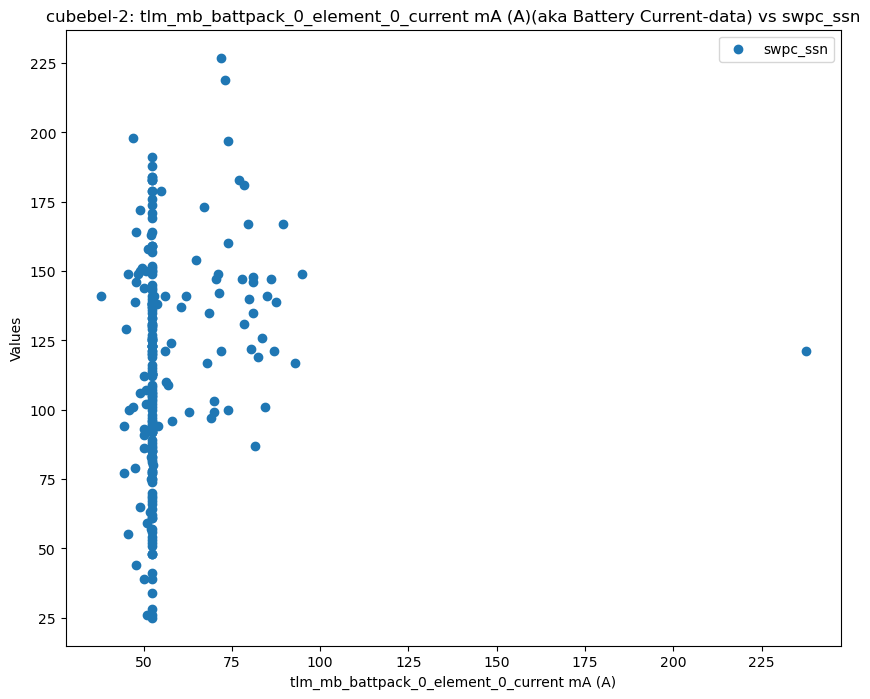

2024-02-11 18:21:32,843 - DEBUG - Processing file: [../data/cubebel-2/Battery Current-data-2024-02-11 02 22 15.csv]


+---------+--------------------+------------+
|         |   57175.distinct A |   swpc_ssn |
|---------+--------------------+------------|
| count   |         34         |  34        |
| mean    |          0.0820588 | 116.647    |
| std     |          0.0362675 |  37.0216   |
| min     |          0.06      |  28        |
| 25%     |          0.06      |  95        |
| 50%     |          0.07      | 121        |
| 75%     |          0.09      | 138        |
| max     |          0.26      | 179        |
| Chi2    |        212.743     | 212.743    |
| P-value |          0.255507  |   0.255507 |
+---------+--------------------+------------+
Correlation [57175.distinct A] vs [swpc_ssn]: pearson=[0.16271631093093558], spearman=[0.2202238104883648], kendal_tau=[0.16324806816797902]


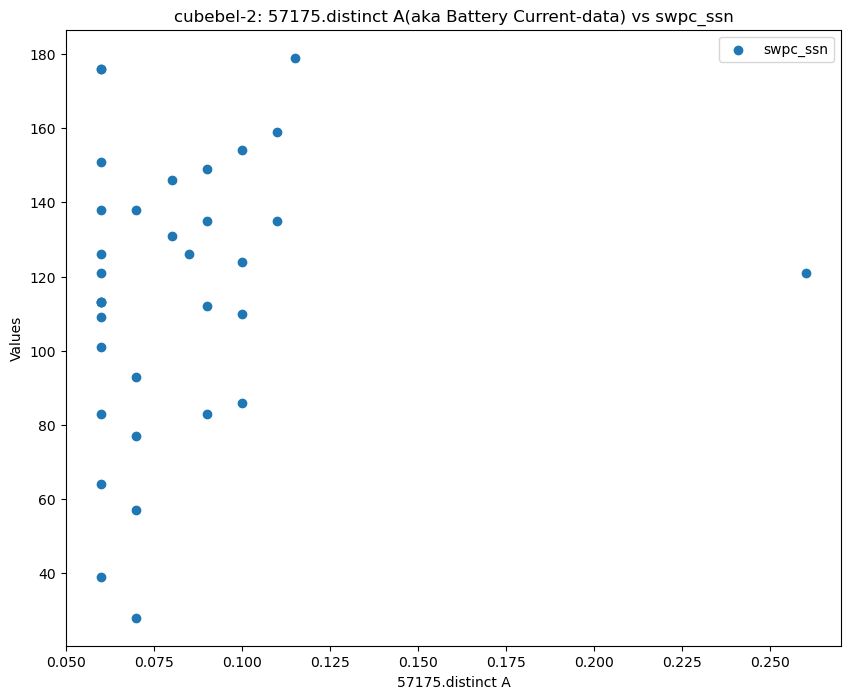

2024-02-11 18:21:33,002 - DEBUG - Processing file: [../data/cubebel-2/Battery Voltage-data-2024-02-11 02 21 49.csv]


+---------+--------------------+------------+
|         |   57175.distinct V |   swpc_ssn |
|---------+--------------------+------------|
| count   |          35        |  35        |
| mean    |           4.82371  | 116.771    |
| std     |           0.1873   |  36.4805   |
| min     |           3.885    |  28        |
| 25%     |           4.825    |  97        |
| 50%     |           4.88     | 121        |
| 75%     |           4.885    | 138        |
| max     |           4.905    | 179        |
| Chi2    |         289.722    | 289.722    |
| P-value |           0.654382 |   0.654382 |
+---------+--------------------+------------+
Correlation [57175.distinct V] vs [swpc_ssn]: pearson=[-0.08447683572570787], spearman=[-0.326314095680748], kendal_tau=[-0.24234588591919806]


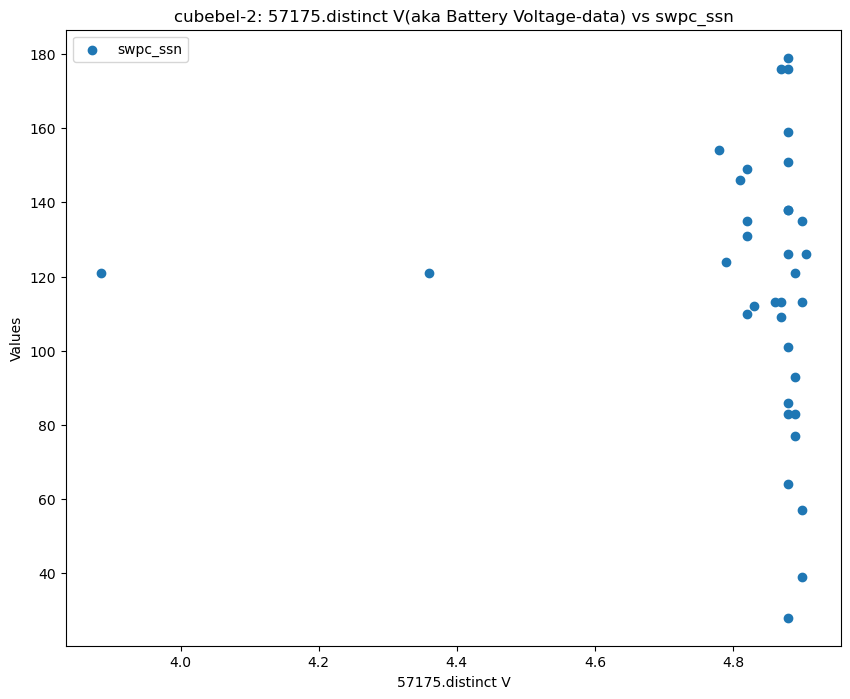

2024-02-11 18:21:33,208 - DEBUG - Processing file: [../data/cubebel-2/Digipeater -data-2024-02-11 02 22 48.csv]
2024-02-11 18:21:33,228 - DEBUG - Processing file: [../data/cubebel-2/Ground Stations Leaderboard By Observed Frames-data-2024-02-11 02 21 28.csv]


+---------+------------+------------+
|         |      9V1KG |   swpc_ssn |
|---------+------------+------------|
| count   |  1449      |  1449      |
| mean    |    14.0242 |    62.7481 |
| std     |    42.9915 |    52.0369 |
| min     |     0      |     0      |
| 25%     |     0      |    14      |
| 50%     |     0      |    52      |
| 75%     |     0      |   101      |
| max     |   230      |   227      |
| Chi2    | 26171.5    | 26171.5    |
| P-value |     0      |     0      |
+---------+------------+------------+
Correlation [9V1KG] vs [swpc_ssn]: pearson=[0.314838698950454], spearman=[0.4074446470220524], kendal_tau=[0.32326963017393173]


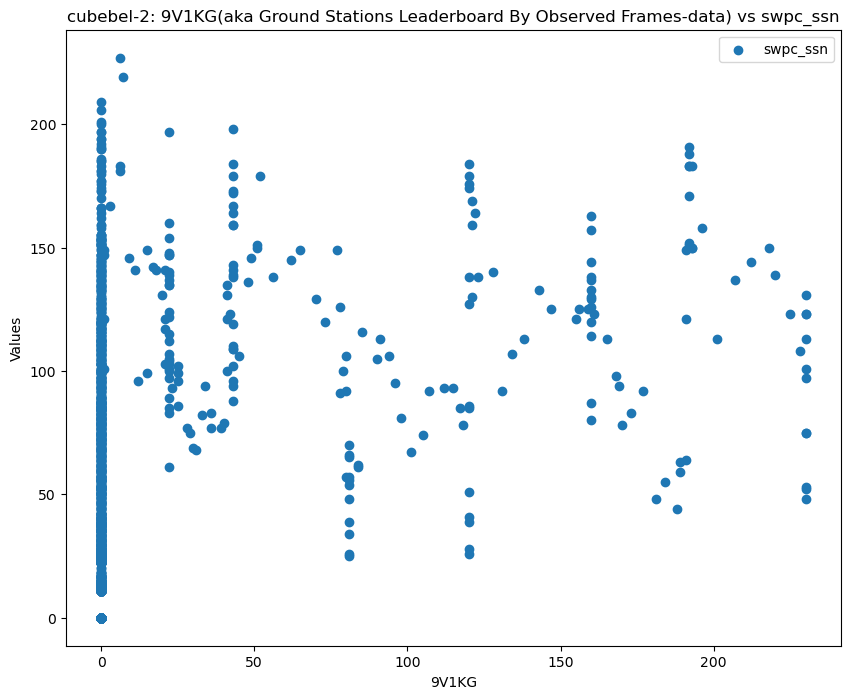

2024-02-11 18:21:33,414 - DEBUG - Processing file: [../data/cubebel-2/Last Frame Rcvd By-data-2024-02-11 02 21 23.csv]


+-------+-----------------------------------------+------------+
|       |   observer where 0 is VK5KJP-UHF-PF95gd |   swpc_ssn |
|-------+-----------------------------------------+------------|
| count |                                       0 |          0 |
| mean  |                                     nan |        nan |
| std   |                                     nan |        nan |
| min   |                                     nan |        nan |
| 25%   |                                     nan |        nan |
| 50%   |                                     nan |        nan |
| 75%   |                                     nan |        nan |
| max   |                                     nan |        nan |
+-------+-----------------------------------------+------------+
Correlation [observer where 0 is VK5KJP-UHF-PF95gd] vs [swpc_ssn]: pearson=[nan], spearman=[nan], kendal_tau=[nan]


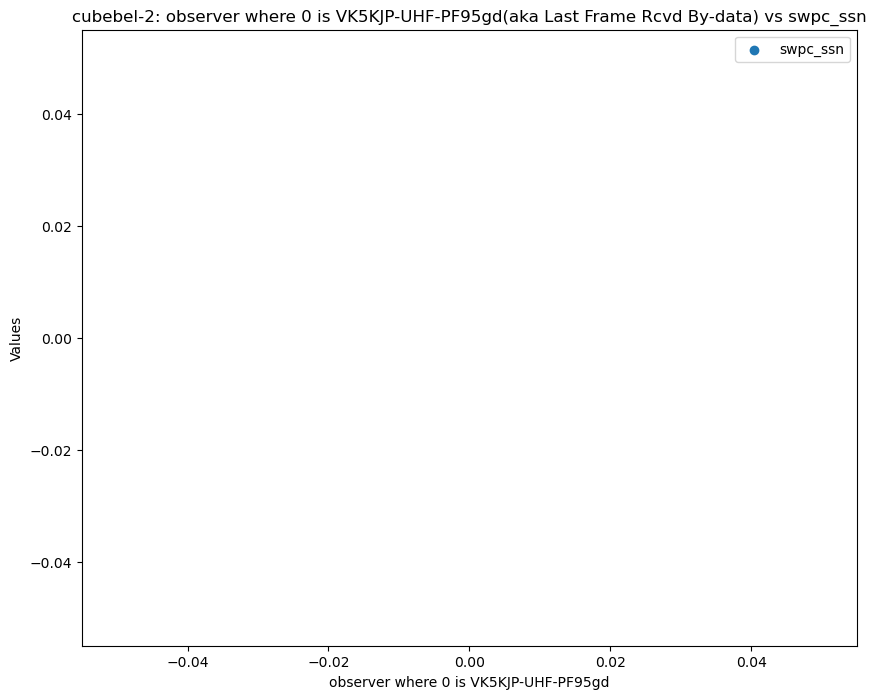

2024-02-11 18:21:33,549 - DEBUG - Processing file: [../data/cubebel-2/Last Frame Time-data-2024-02-11 02 22 52.csv]
2024-02-11 18:21:33,587 - WARNING - Column '57175.ctl' is nearly constant, skipping.
2024-02-11 18:21:33,590 - DEBUG - Processing file: [../data/cubebel-2/Last Message-data-2024-02-11 02 22 16.csv]
2024-02-11 18:21:33,609 - DEBUG - Processing file: [../data/cubebel-2/MB Uptime-data-2024-02-11 02 22 39.csv]


+---------+---------------------+--------------+
|         |   57175.tlm_mb_time |     swpc_ssn |
|---------+---------------------+--------------|
| count   |          224        |   224        |
| mean    |        33303        |   115.875    |
| std     |        12234.4      |    39.7821   |
| min     |          570        |    25        |
| 25%     |        25776.2      |    88.75     |
| 50%     |        34071.2      |   119        |
| 75%     |        40542.5      |   142.25     |
| max     |        60800        |   227        |
| Chi2    |        26801.6      | 26801.6      |
| P-value |            0.241472 |     0.241472 |
+---------+---------------------+--------------+
Correlation [57175.tlm_mb_time] vs [swpc_ssn]: pearson=[-0.03920938837919507], spearman=[-0.0218143563391009], kendal_tau=[-0.016273330110514843]


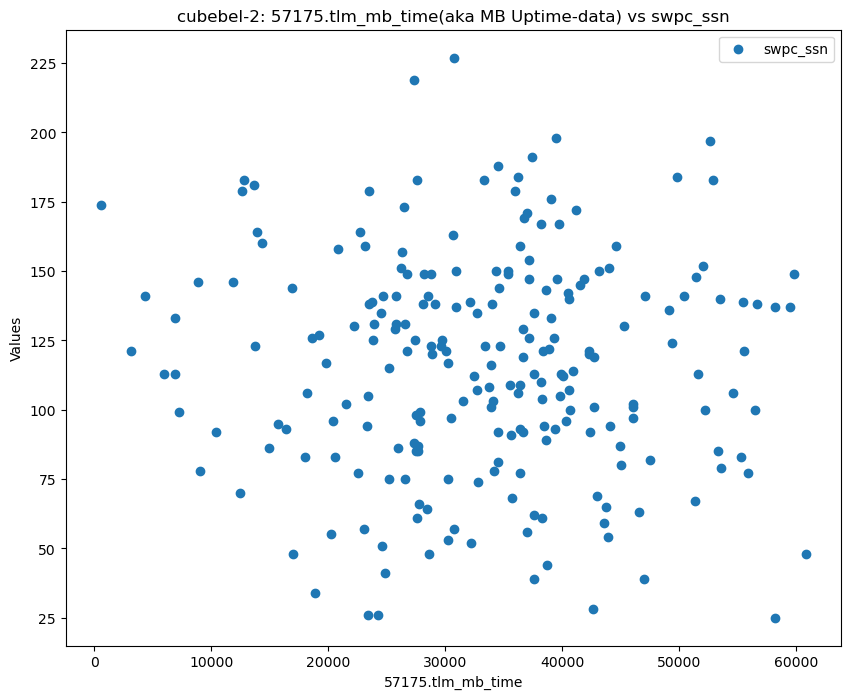

2024-02-11 18:21:33,783 - DEBUG - Processing file: [../data/cubebel-2/Resets-data-2024-02-11 02 22 26.csv]


+---------+--------------------------+--------------+
|         |   beacon_reset_total_cnt |     swpc_ssn |
|---------+--------------------------+--------------|
| count   |               225        |   225        |
| mean    |               127.207    |   115.973    |
| std     |                43.5454   |    39.7206   |
| min     |                22.5      |    25        |
| 25%     |                93        |    89        |
| 50%     |               131        |   119        |
| 75%     |               159.5      |   142        |
| max     |               218        |   227        |
| Chi2    |             17325.6      | 17325.6      |
| P-value |                 0.850524 |     0.850524 |
+---------+--------------------------+--------------+
Correlation [beacon_reset_total_cnt] vs [swpc_ssn]: pearson=[0.06291851285053665], spearman=[0.048072551536734835], kendal_tau=[0.0319259705060527]


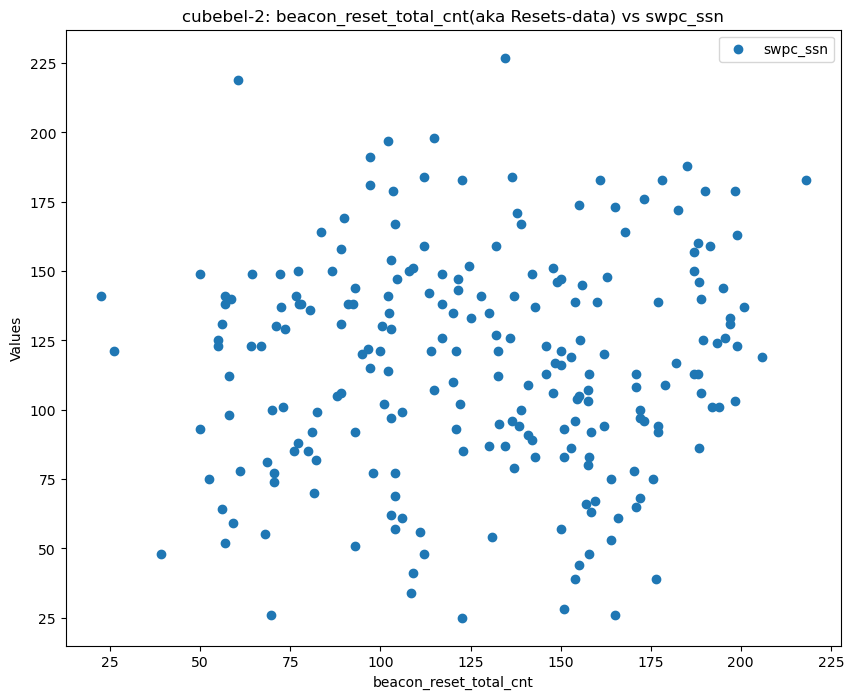

2024-02-11 18:21:34,004 - DEBUG - Processing file: [../data/cubebel-2/Sat Time-data-2024-02-11 02 22 43.csv]


+---------+----------------------------------+--------------+
|         |   57175.tlm_trx_cmn_rtc_unixtime |     swpc_ssn |
|---------+----------------------------------+--------------|
| count   |                    225           |   225        |
| mean    |                      1.69403e+12 |   115.973    |
| std     |                      3.22324e+09 |    39.7206   |
| min     |                      1.68429e+12 |    25        |
| 25%     |                      1.69194e+12 |    89        |
| 50%     |                      1.69433e+12 |   119        |
| 75%     |                      1.69664e+12 |   142        |
| max     |                      1.69907e+12 |   227        |
| Chi2    |                  27000           | 27000        |
| P-value |                      0.301652    |     0.301652 |
+---------+----------------------------------+--------------+
Correlation [57175.tlm_trx_cmn_rtc_unixtime] vs [swpc_ssn]: pearson=[-0.13889752612342934], spearman=[-0.09706790264121769], kendal_

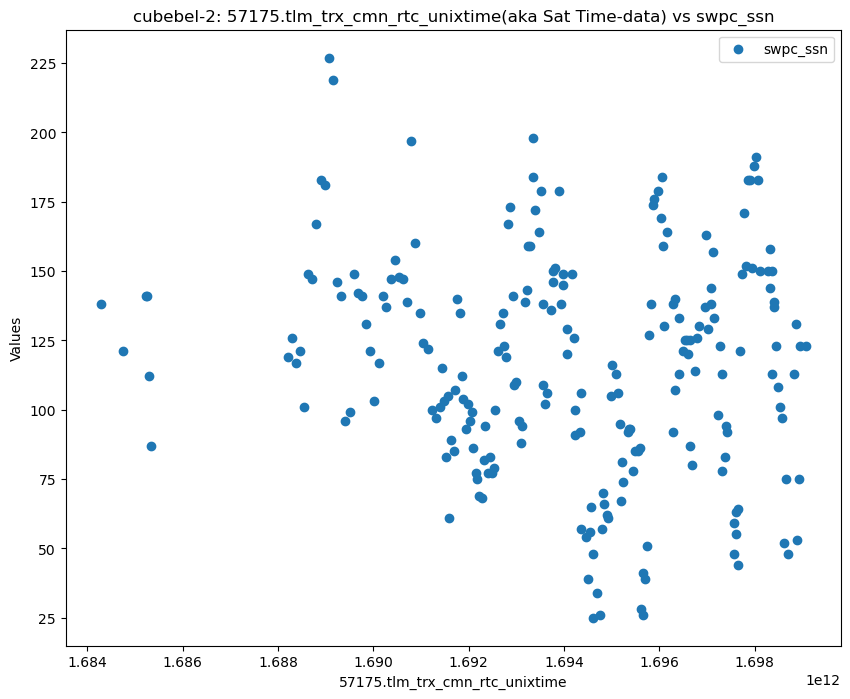

2024-02-11 18:21:34,211 - DEBUG - Processing file: [../data/cubebel-2/Solar Panel Current-data-2024-02-11 02 22 37.csv]


+---------+--------------------------------------+--------------+
|         |   tlm_mb_solarpanel_1_current(mA) mA |     swpc_ssn |
|---------+--------------------------------------+--------------|
| count   |                           224        |   224        |
| mean    |                            88.733    |   115.875    |
| std     |                           108.417    |    39.7821   |
| min     |                             2.4      |    25        |
| 25%     |                            20        |    88.75     |
| 50%     |                            30        |   119        |
| 75%     |                           125.875    |   142.25     |
| max     |                           460        |   227        |
| Chi2    |                         15657.9      | 15657.9      |
| P-value |                             0.635742 |     0.635742 |
+---------+--------------------------------------+--------------+
Correlation [tlm_mb_solarpanel_1_current(mA) mA] vs [swpc_ssn]: pearson=[0.2

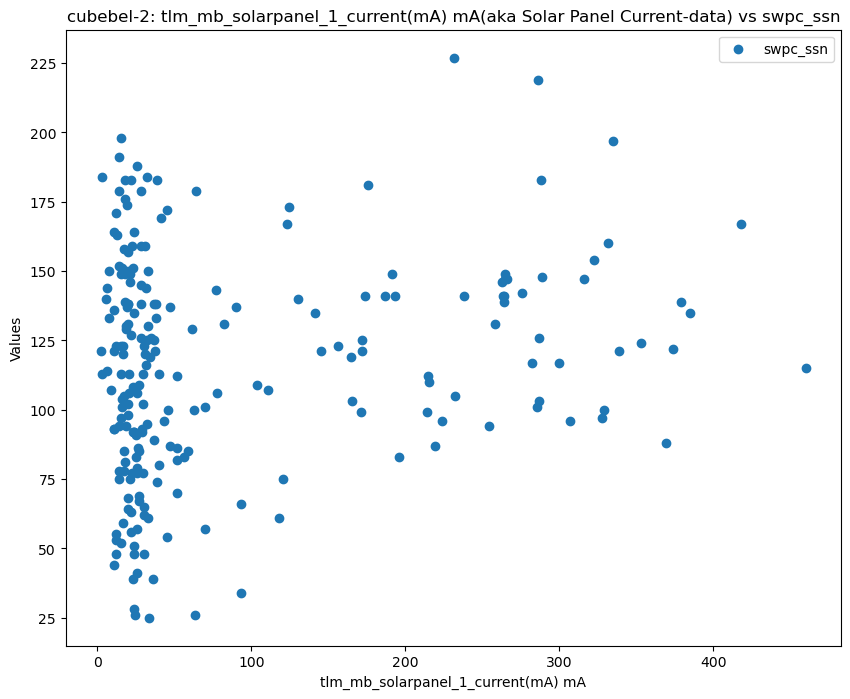

2024-02-11 18:21:34,410 - DEBUG - Processing file: [../data/cubebel-2/Solar Panel Temperatures-data-2024-02-11 02 22 03.csv]


+---------+----------------------------------+--------------+
|         |   tlm_mb_solartemp_0_temp_0 (°C) |     swpc_ssn |
|---------+----------------------------------+--------------|
| count   |                       224        |   224        |
| mean    |                        13.2554   |   115.875    |
| std     |                        27.681    |    39.7821   |
| min     |                         3.9      |    25        |
| 25%     |                         8.075    |    88.75     |
| 50%     |                         9.9      |   119        |
| 75%     |                        12        |   142.25     |
| max     |                       251        |   227        |
| Chi2    |                     11152.9      | 11152.9      |
| P-value |                         0.223198 |     0.223198 |
+---------+----------------------------------+--------------+
Correlation [tlm_mb_solartemp_0_temp_0 (°C)] vs [swpc_ssn]: pearson=[0.03439559144282096], spearman=[-0.06737836516699401], kendal_t

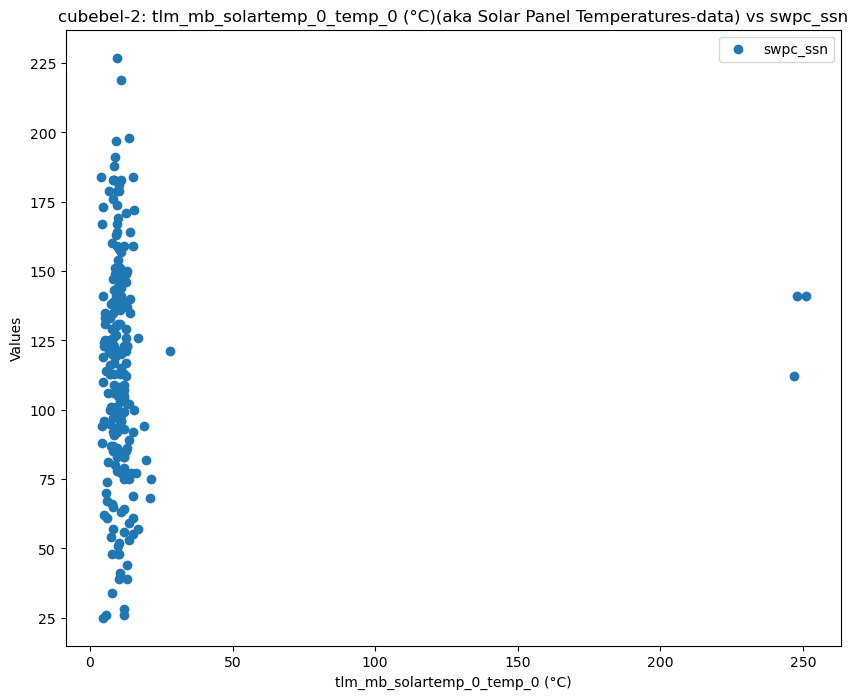

In [206]:
analyze_satellite('cubebel-2')

2024-02-11 18:21:34,605 - DEBUG - Processing file: [../data/delfi-pq/Currents-data-2024-02-11 02 21 52.csv]


+---------+-------------+-------------+
|         |     Current |    swpc_ssn |
|---------+-------------+-------------|
| count   |  706        |  706        |
| mean    |   40.6091   |   99.2663   |
| std     |    8.41967  |   41.7192   |
| min     |   30        |    0        |
| 25%     |   33        |   68.25     |
| 50%     |   38        |   97        |
| 75%     |   52        |  129        |
| max     |   64        |  227        |
| Chi2    | 3007.58     | 3007.58     |
| P-value |    0.747084 |    0.747084 |
+---------+-------------+-------------+
Correlation [Current] vs [swpc_ssn]: pearson=[-0.04249925894302116], spearman=[-0.0580247347444164], kendal_tau=[-0.039862636061729]


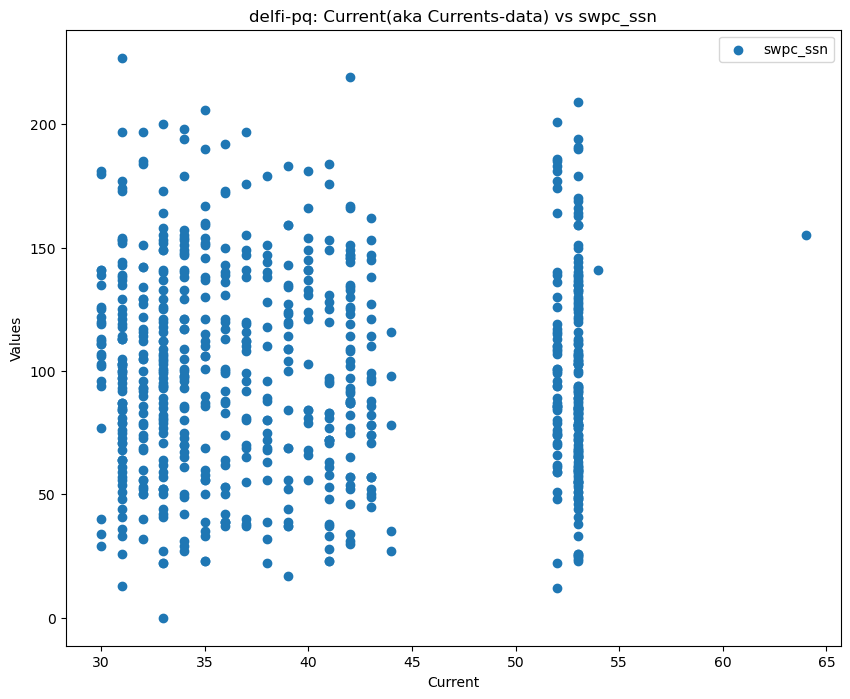

2024-02-11 18:21:34,781 - DEBUG - Processing file: [../data/delfi-pq/Last Frame Rcvd By-data-2024-02-11 02 21 45.csv]
/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


+---------+-----------------------------------------+------------+
|         |   observer where 0 is VK4JBE-UHF-QG62mm |   swpc_ssn |
|---------+-----------------------------------------+------------|
| count   |                                       1 |          1 |
| mean    |                                       0 |        149 |
| std     |                                     nan |        nan |
| min     |                                       0 |        149 |
| 25%     |                                       0 |        149 |
| 50%     |                                       0 |        149 |
| 75%     |                                       0 |        149 |
| max     |                                       0 |        149 |
| Chi2    |                                       0 |          0 |
| P-value |                                       1 |          1 |
+---------+-----------------------------------------+------------+
Correlation [observer where 0 is VK4JBE-UHF-QG62mm] vs [swpc_s

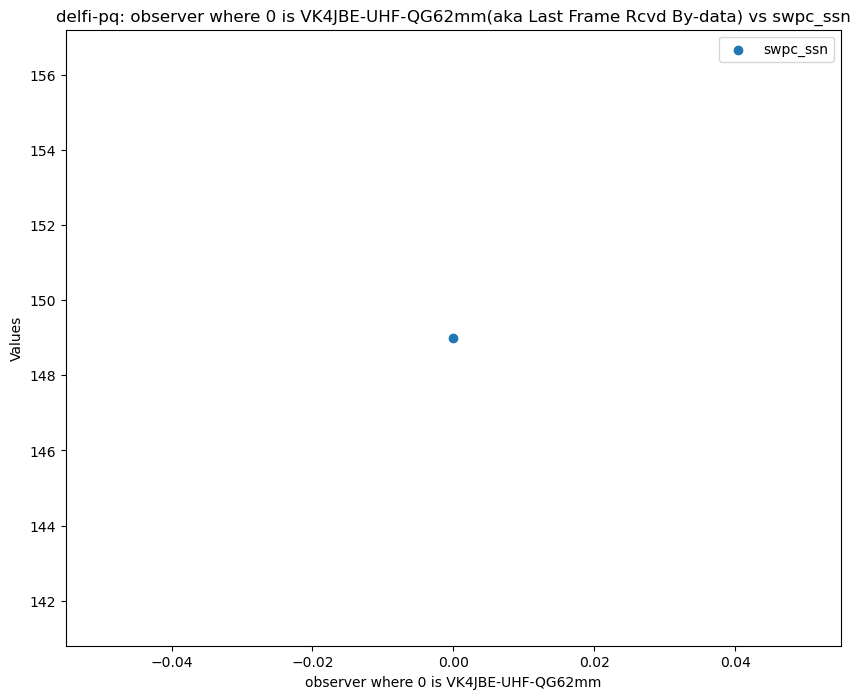

2024-02-11 18:21:34,928 - DEBUG - Processing file: [../data/delfi-pq/Solar Panel Currents-data-2024-02-11 02 22 09.csv]


+---------+-------------+-------------+
|         |     Cell Xm |    swpc_ssn |
|---------+-------------+-------------|
| count   |  689        |  689        |
| mean    |    5.83454  |  100.161    |
| std     |    8.85437  |   41.5395   |
| min     |    0        |    0        |
| 25%     |    0        |   69        |
| 50%     |    4        |   98        |
| 75%     |    6        |  130        |
| max     |   96        |  227        |
| Chi2    | 6133.36     | 6133.36     |
| P-value |    0.995063 |    0.995063 |
+---------+-------------+-------------+
Correlation [Cell Xm] vs [swpc_ssn]: pearson=[0.09008220346801377], spearman=[0.052047479334271826], kendal_tau=[0.03794476984513911]


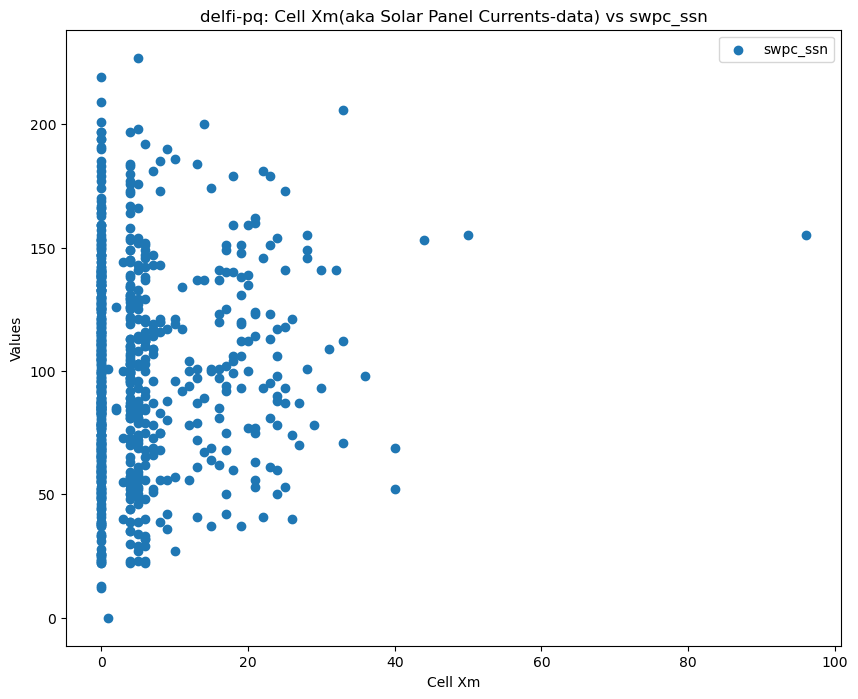

2024-02-11 18:21:35,091 - DEBUG - Processing file: [../data/delfi-pq/Solar Panel Voltages-data-2024-02-11 02 22 03.csv]


+---------+-----------------+--------------+
|         |   Cell Xp V (m) |     swpc_ssn |
|---------+-----------------+--------------|
| count   |      689        |   689        |
| mean    |      125.039    |   100.161    |
| std     |      189.481    |    41.5395   |
| min     |        0        |     0        |
| 25%     |        2.663    |    69        |
| 50%     |        2.837    |    98        |
| 75%     |      288        |   130        |
| max     |      703        |   227        |
| Chi2    |    62339.7      | 62339.7      |
| P-value |        0.999946 |     0.999946 |
+---------+-----------------+--------------+
Correlation [Cell Xp V (m)] vs [swpc_ssn]: pearson=[-0.03633990530352432], spearman=[0.016694089927088453], kendal_tau=[0.01117614978022468]


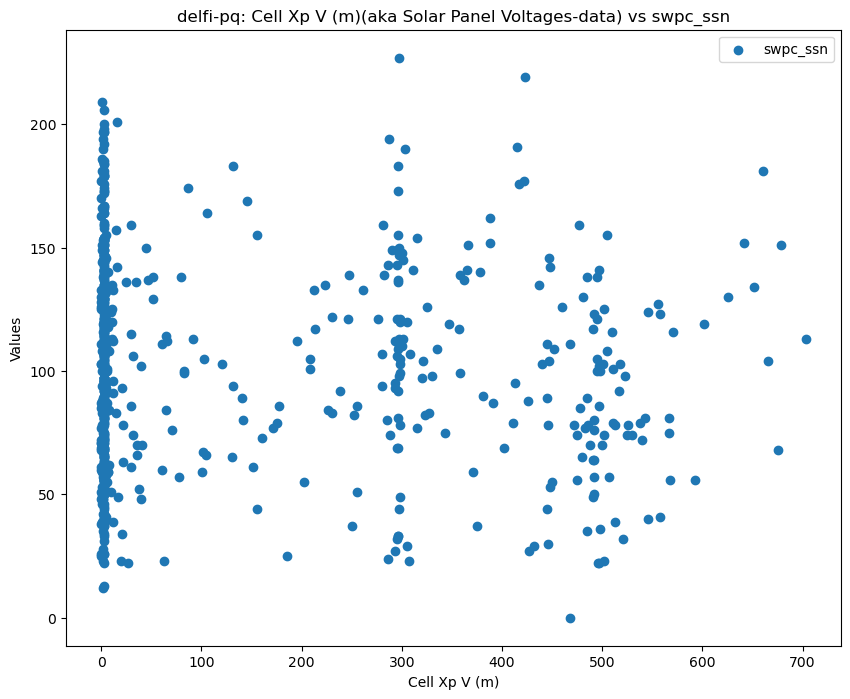

2024-02-11 18:21:35,260 - DEBUG - Processing file: [../data/delfi-pq/System Temperatures (C)-data-2024-02-11 02 21 56.csv]
2024-02-11 18:21:35,279 - WARNING - Column 'Temp' is nearly constant, skipping.


In [207]:
analyze_satellite('delfi-pq')

2024-02-11 18:21:35,285 - DEBUG - Processing file: [../data/dhabisat/Altitude-data-2024-02-11 02 22 19.csv]


+---------+------------+------------+
|         |   Altitute |   swpc_ssn |
|---------+------------+------------|
| count   |        813 |   813      |
| mean    |          0 |    85.7737 |
| std     |          0 |    46.1452 |
| min     |          0 |     0      |
| 25%     |          0 |    50      |
| 50%     |          0 |    83      |
| 75%     |          0 |   118      |
| max     |          0 |   227      |
| Chi2    |          0 |     0      |
| P-value |          1 |     1      |
+---------+------------+------------+
Correlation [Altitute] vs [swpc_ssn]: pearson=[nan], spearman=[nan], kendal_tau=[nan]


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


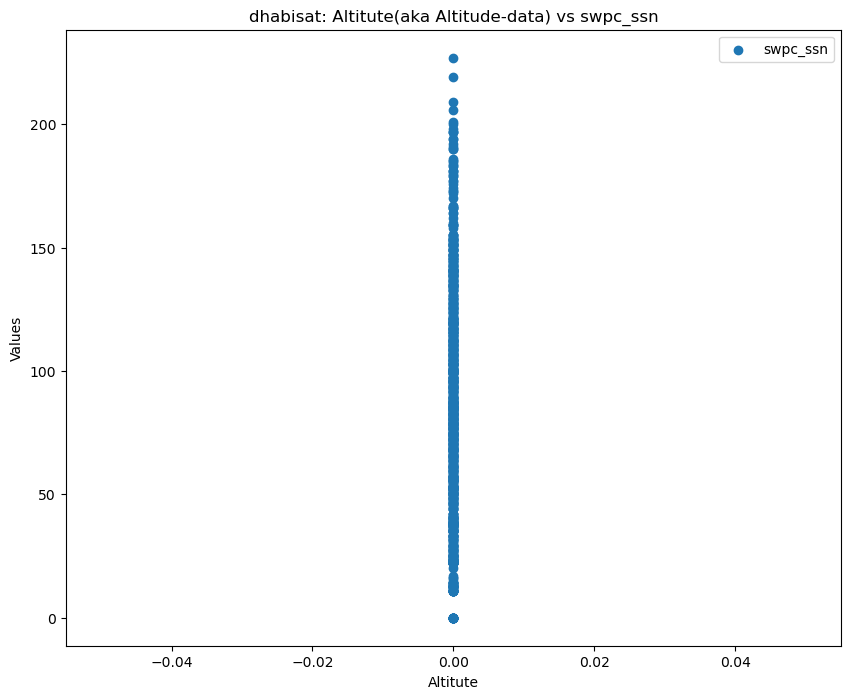

2024-02-11 18:21:35,450 - DEBUG - Processing file: [../data/dhabisat/ECEF Position-data-2024-02-11 02 22 26.csv]
/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


+---------+-------------------+------------+
|         |   ECEF Position X |   swpc_ssn |
|---------+-------------------+------------|
| count   |               813 |   813      |
| mean    |                 0 |    85.7737 |
| std     |                 0 |    46.1452 |
| min     |                 0 |     0      |
| 25%     |                 0 |    50      |
| 50%     |                 0 |    83      |
| 75%     |                 0 |   118      |
| max     |                 0 |   227      |
| Chi2    |                 0 |     0      |
| P-value |                 1 |     1      |
+---------+-------------------+------------+
Correlation [ECEF Position X] vs [swpc_ssn]: pearson=[nan], spearman=[nan], kendal_tau=[nan]


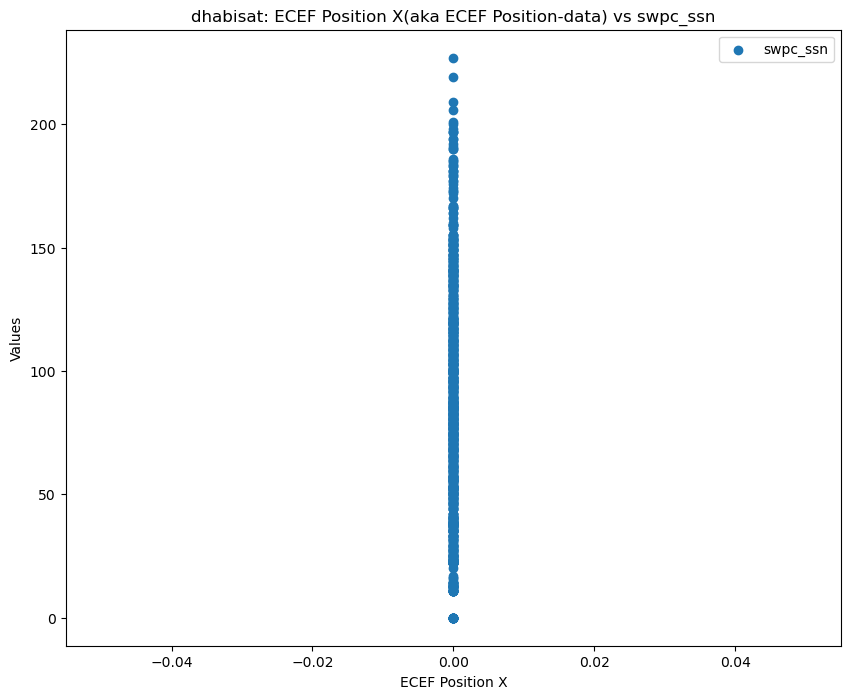

2024-02-11 18:21:35,641 - DEBUG - Processing file: [../data/dhabisat/Estimated Angular Rates-data-2024-02-11 02 21 39.csv]


+---------+----------------------------+------------+
|         |   Estimated X Angular Rate |   swpc_ssn |
|---------+----------------------------+------------|
| count   |              813           | 813        |
| mean    |                0.000418204 |  85.7737   |
| std     |                0.00848483  |  46.1452   |
| min     |                0           |   0        |
| 25%     |                0           |  50        |
| 50%     |                0           |  83        |
| 75%     |                0           | 118        |
| max     |                0.19        | 227        |
| Chi2    |              296.463       | 296.463    |
| P-value |                0.974749    |   0.974749 |
+---------+----------------------------+------------+
Correlation [Estimated X Angular Rate] vs [swpc_ssn]: pearson=[-0.039515661439522766], spearman=[-0.04143452771262478], kendal_tau=[-0.03398200601136489]


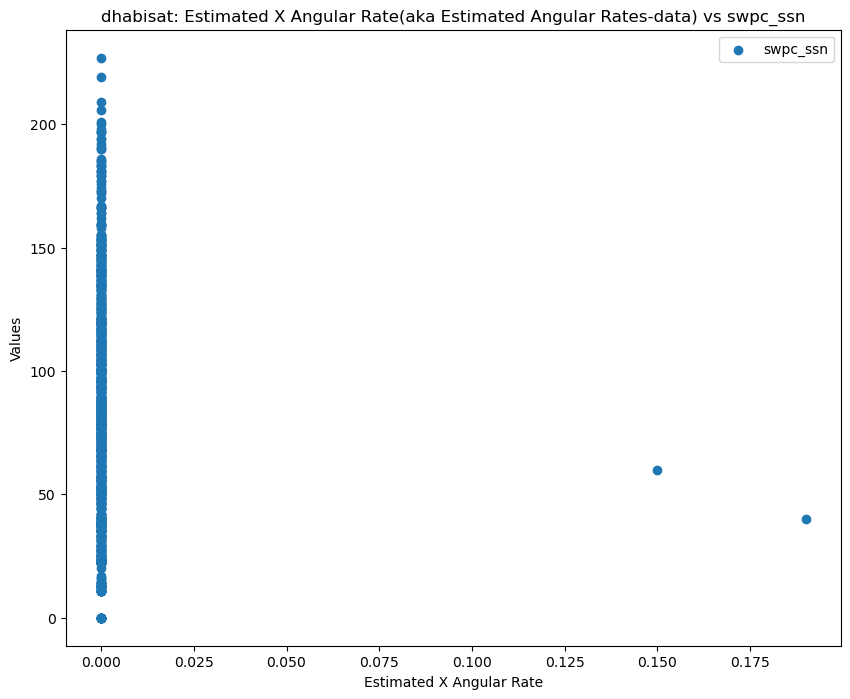

2024-02-11 18:21:35,842 - DEBUG - Processing file: [../data/dhabisat/Estimated Quaternions-data-2024-02-11 02 21 45.csv]
2024-02-11 18:21:35,911 - WARNING - Column 'Estimated Q1' is nearly constant, skipping.
2024-02-11 18:21:35,914 - DEBUG - Processing file: [../data/dhabisat/Estimated Roll_Pitch_Yaw-data-2024-02-11 02 21 49.csv]
2024-02-11 18:21:35,935 - WARNING - Column 'Estimated Roll Angle' is nearly constant, skipping.
2024-02-11 18:21:35,938 - DEBUG - Processing file: [../data/dhabisat/Latitude _ Longitude-data-2024-02-11 02 22 08.csv]
2024-02-11 18:21:35,960 - WARNING - Column 'Latitude' is nearly constant, skipping.
2024-02-11 18:21:35,962 - DEBUG - Processing file: [../data/dhabisat/Position-data-2024-02-11 02 22 03.csv]
2024-02-11 18:21:35,980 - WARNING - Column 'X Position' is nearly constant, skipping.
2024-02-11 18:21:35,983 - DEBUG - Processing file: [../data/dhabisat/Power-data-2024-02-11 02 21 51.csv]


+-------+-----------------------+------------+
|       |   49016.mode OFF (ON) |   swpc_ssn |
|-------+-----------------------+------------|
| count |                     0 |          0 |
| mean  |                   nan |        nan |
| std   |                   nan |        nan |
| min   |                   nan |        nan |
| 25%   |                   nan |        nan |
| 50%   |                   nan |        nan |
| 75%   |                   nan |        nan |
| max   |                   nan |        nan |
+-------+-----------------------+------------+
Correlation [49016.mode OFF (ON)] vs [swpc_ssn]: pearson=[nan], spearman=[nan], kendal_tau=[nan]


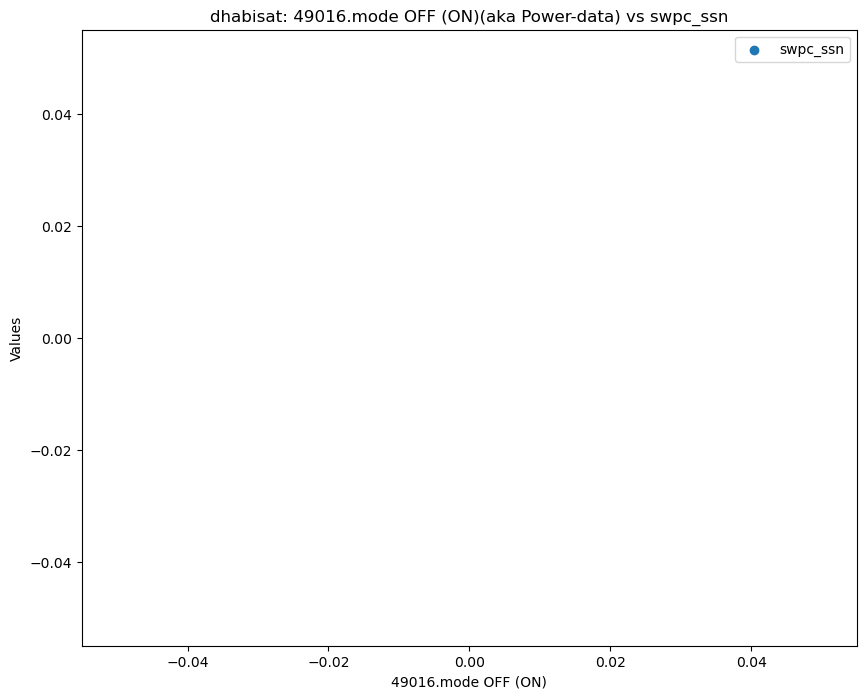

2024-02-11 18:21:36,121 - DEBUG - Processing file: [../data/dhabisat/Velocity-data-2024-02-11 02 22 12.csv]
2024-02-11 18:21:36,140 - WARNING - Column 'X Velocity' is nearly constant, skipping.
2024-02-11 18:21:36,143 - DEBUG - Processing file: [../data/dhabisat/Wheel Speeds-data-2024-02-11 02 21 57.csv]
2024-02-11 18:21:36,161 - WARNING - Column 'X Wheel Speed' is nearly constant, skipping.


In [208]:
analyze_satellite('dhabisat')

2024-02-11 18:21:36,168 - DEBUG - Processing file: [../data/geoscan-edelveis/-data-2024-02-11 02 21 37.csv]


+---------+-------------------------+--------------+
|         |   Batteries Voltage.1 V |     swpc_ssn |
|---------+-------------------------+--------------|
| count   |              448        |   448        |
| mean    |                5.4981   |   115.52     |
| std     |                3.49636  |    40.1737   |
| min     |                0.03     |    12        |
| 25%     |                0.033    |    87        |
| 50%     |                7.3855   |   114        |
| 75%     |                8.059    |   142        |
| max     |                8.3595   |   227        |
| Chi2    |            33508.3      | 33508.3      |
| P-value |                0.995527 |     0.995527 |
+---------+-------------------------+--------------+
Correlation [Batteries Voltage.1 V] vs [swpc_ssn]: pearson=[0.036143361932609225], spearman=[0.030006195647520932], kendal_tau=[0.020395238659781757]


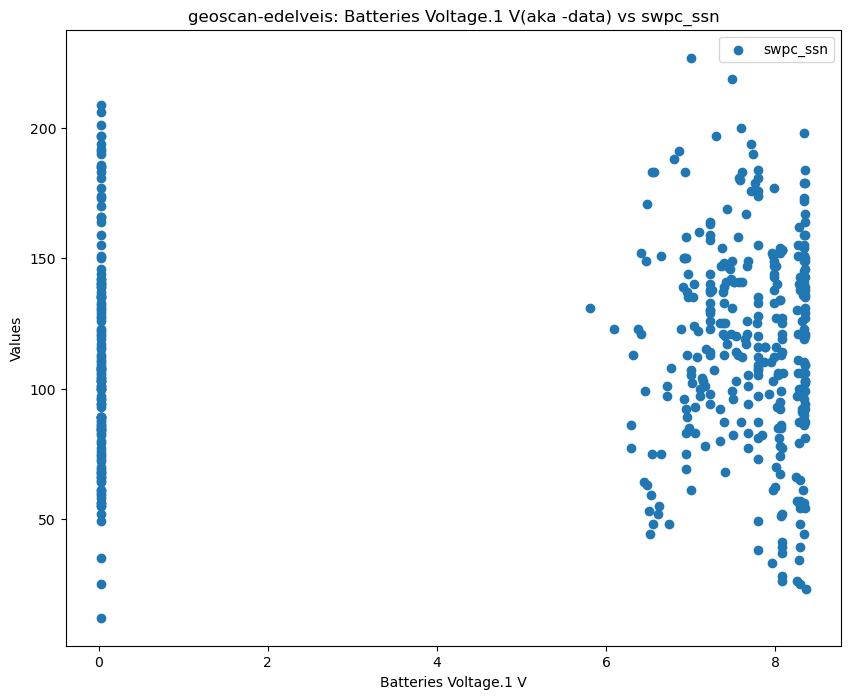

2024-02-11 18:21:36,354 - DEBUG - Processing file: [../data/geoscan-edelveis/Callsign-data-2024-02-11 02 21 40.csv]
2024-02-11 18:21:36,401 - DEBUG - Processing file: [../data/geoscan-edelveis/Msg Type-data-2024-02-11 02 21 43.csv]
2024-02-11 18:21:36,419 - DEBUG - Processing file: [../data/geoscan-edelveis/Voltage of all Batteries-data-2024-02-11 02 21 34.csv]


+---------+---------------------+------------+
|         |   Battery Voltage V |   swpc_ssn |
|---------+---------------------+------------|
| count   |          128        | 128        |
| mean    |            8.20781  | 112.844    |
| std     |            0.155533 |  43.0099   |
| min     |            7.8      |  12        |
| 25%     |            8.1      |  82.75     |
| 50%     |            8.3      | 107        |
| 75%     |            8.3      | 139.25     |
| max     |            8.3      | 209        |
| Chi2    |          449.139    | 449.139    |
| P-value |            0.876882 |   0.876882 |
+---------+---------------------+------------+
Correlation [Battery Voltage V] vs [swpc_ssn]: pearson=[0.07410456193200565], spearman=[0.013035490718406977], kendal_tau=[0.011758153411808678]


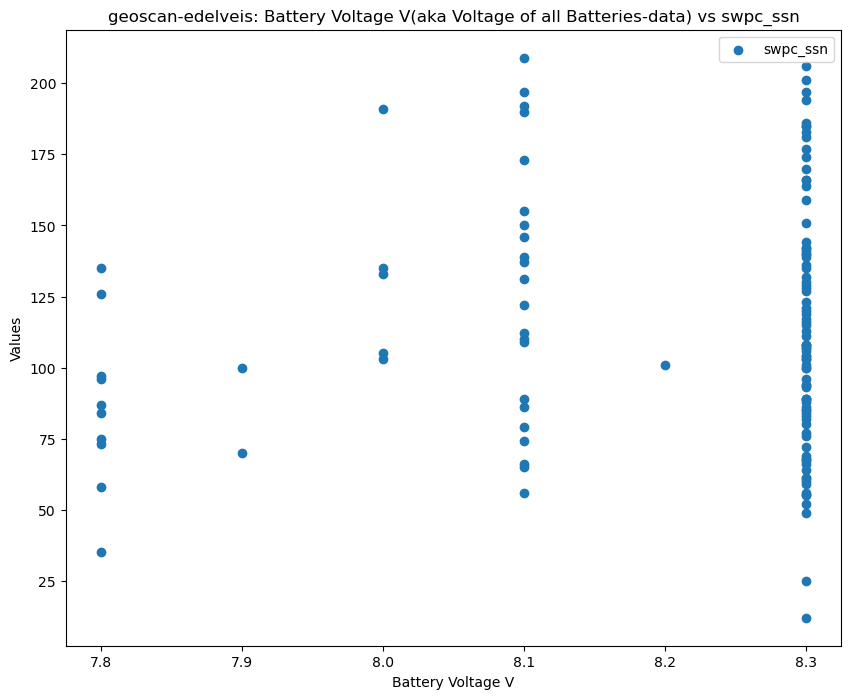

In [209]:
analyze_satellite('geoscan-edelveis')

2024-02-11 18:21:36,593 - DEBUG - Processing file: [../data/grbalpha/COM MCU temperature in °C-data-2024-02-11 02 23 54.csv]


+---------+------------------+------------+
|         |   47959.temp_cpu |   swpc_ssn |
|---------+------------------+------------|
| count   |        879       |  879       |
| mean    |         16.6726  |   79.2673  |
| std     |          4.08236 |   46.0523  |
| min     |          2.9     |    0       |
| 25%     |         15       |   40       |
| 50%     |         17       |   77       |
| 75%     |         18       |  112       |
| max     |         42       |  209       |
| Chi2    |       9080.87    | 9080.87    |
| P-value |          0.15311 |    0.15311 |
+---------+------------------+------------+
Correlation [47959.temp_cpu] vs [swpc_ssn]: pearson=[0.19583528814101045], spearman=[0.11874665779294377], kendal_tau=[0.08426372624567413]


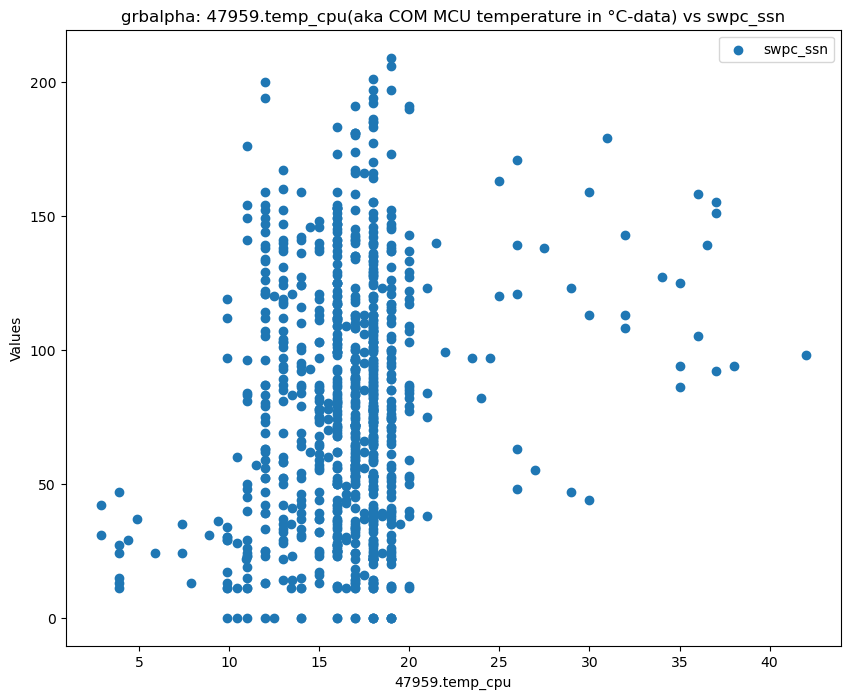

2024-02-11 18:21:36,824 - DEBUG - Processing file: [../data/grbalpha/COM RF received-data-2024-02-11 02 23 14.csv]


+---------+-----------------------------+------------------+
|         |   47959.rf_packets_received |         swpc_ssn |
|---------+-----------------------------+------------------|
| count   |               879           |    879           |
| mean    |             23988.6         |     79.2673      |
| std     |             14579.6         |     46.0523      |
| min     |              3885           |      0           |
| 25%     |              6566.5         |     40           |
| 50%     |             26861           |     77           |
| 75%     |             37127.5         |    112           |
| max     |             46873           |    209           |
| Chi2    |            136849           | 136849           |
| P-value |                 6.95073e-07 |      6.95073e-07 |
+---------+-----------------------------+------------------+
Correlation [47959.rf_packets_received] vs [swpc_ssn]: pearson=[0.6552103398456955], spearman=[0.6812939707841996], kendal_tau=[0.4828091311396872

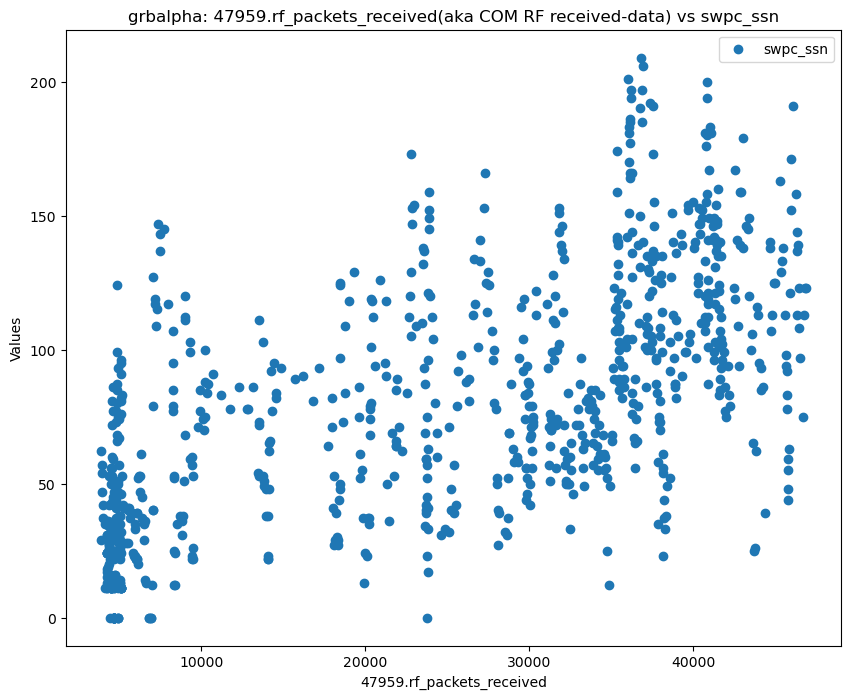

2024-02-11 18:21:37,046 - DEBUG - Processing file: [../data/grbalpha/COM RF transmitted-data-2024-02-11 02 23 35.csv]


+---------+--------------------------------+---------------+
|         |   47959.rf_packets_transmitted |      swpc_ssn |
|---------+--------------------------------+---------------|
| count   |                  879           |    879        |
| mean    |                    1.95549e+06 |     79.2673   |
| std     |                    1.16048e+06 |     46.0523   |
| min     |               148470           |      0        |
| 25%     |                    1.03562e+06 |     40        |
| 50%     |                    1.63671e+06 |     77        |
| 75%     |                    2.7571e+06  |    112        |
| max     |                    4.8328e+06  |    209        |
| Chi2    |               151188           | 151188        |
| P-value |                    0.376736    |      0.376736 |
+---------+--------------------------------+---------------+
Correlation [47959.rf_packets_transmitted] vs [swpc_ssn]: pearson=[0.6278741335227254], spearman=[0.6812807774305079], kendal_tau=[0.4826457920364

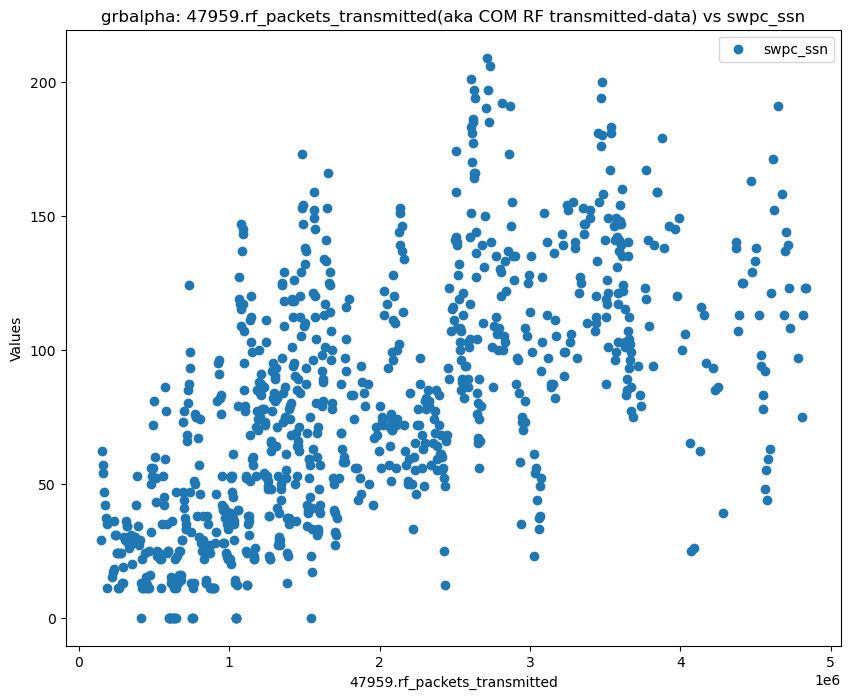

2024-02-11 18:21:37,262 - DEBUG - Processing file: [../data/grbalpha/Frame count-data-2024-02-11 02 24 54.csv]
2024-02-11 18:21:37,281 - WARNING - Column '47959.count' is nearly constant, skipping.
2024-02-11 18:21:37,284 - DEBUG - Processing file: [../data/grbalpha/OBC 9DOF temperature in °C-data-2024-02-11 02 25 27.csv]


+---------+----------------------+------------+
|         |   47959.obc_mpu_temp |   swpc_ssn |
|---------+----------------------+------------|
| count   |           1012       |  1012      |
| mean    |             10.8191  |    84.3458 |
| std     |              9.54471 |    47.5542 |
| min     |              0       |     0      |
| 25%     |              0       |    46      |
| 50%     |             15       |    82      |
| 75%     |             20       |   119.25   |
| max     |             28       |   227      |
| Chi2    |           4855.96    |  4855.96   |
| P-value |              1       |     1      |
+---------+----------------------+------------+
Correlation [47959.obc_mpu_temp] vs [swpc_ssn]: pearson=[0.013497454471777425], spearman=[0.0407576844159037], kendal_tau=[0.028140507841988457]


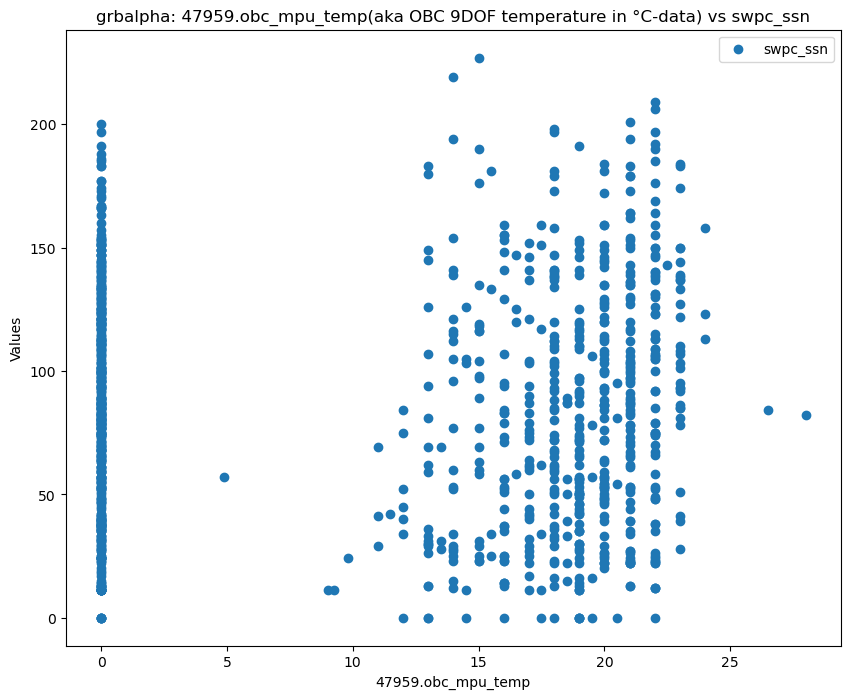

2024-02-11 18:21:37,493 - DEBUG - Processing file: [../data/grbalpha/OBC MCU temperature in °C-data-2024-02-11 02 25 11.csv]


+---------+------------------+------------+
|         |   47959.obc_temp |   swpc_ssn |
|---------+------------------+------------|
| count   |       1012       |  1012      |
| mean    |         16.5183  |    84.3458 |
| std     |          2.87335 |    47.5542 |
| min     |          7.7     |     0      |
| 25%     |         15       |    46      |
| 50%     |         17       |    82      |
| 75%     |         19       |   119.25   |
| max     |         25       |   227      |
| Chi2    |       5667.97    |  5667.97   |
| P-value |          1       |     1      |
+---------+------------------+------------+
Correlation [47959.obc_temp] vs [swpc_ssn]: pearson=[0.13629544895903378], spearman=[0.13094092761767348], kendal_tau=[0.09183994173997309]


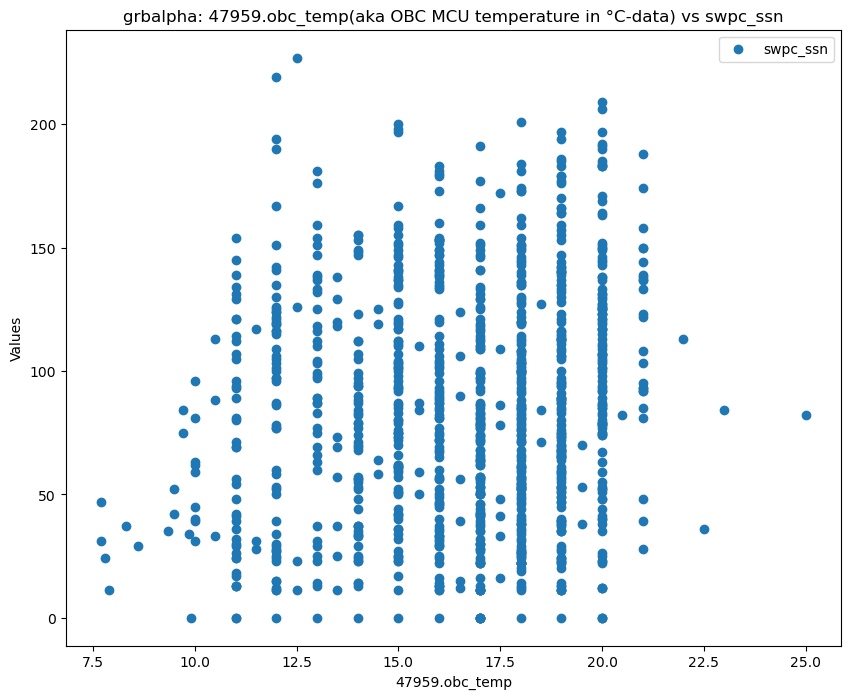

2024-02-11 18:21:37,705 - DEBUG - Processing file: [../data/grbalpha/OBC Uptime total-data-2024-02-11 02 26 28.csv]


+---------+--------------------------+---------------+
|         |   47959.obc_uptime_total |      swpc_ssn |
|---------+--------------------------+---------------|
| count   |           1012           |   1012        |
| mean    |              4.61661e+07 |     84.3458   |
| std     |              2.52258e+07 |     47.5542   |
| min     |              2.40802e+06 |      0        |
| 25%     |              2.43341e+07 |     46        |
| 50%     |              4.61619e+07 |     82        |
| 75%     |              6.79935e+07 |    119.25     |
| max     |              8.98209e+07 |    227        |
| Chi2    |         183172           | 183172        |
| P-value |              0.382014    |      0.382014 |
+---------+--------------------------+---------------+
Correlation [47959.obc_uptime_total] vs [swpc_ssn]: pearson=[0.6417320382218976], spearman=[0.6564475957291203], kendal_tau=[0.4656836466869805]


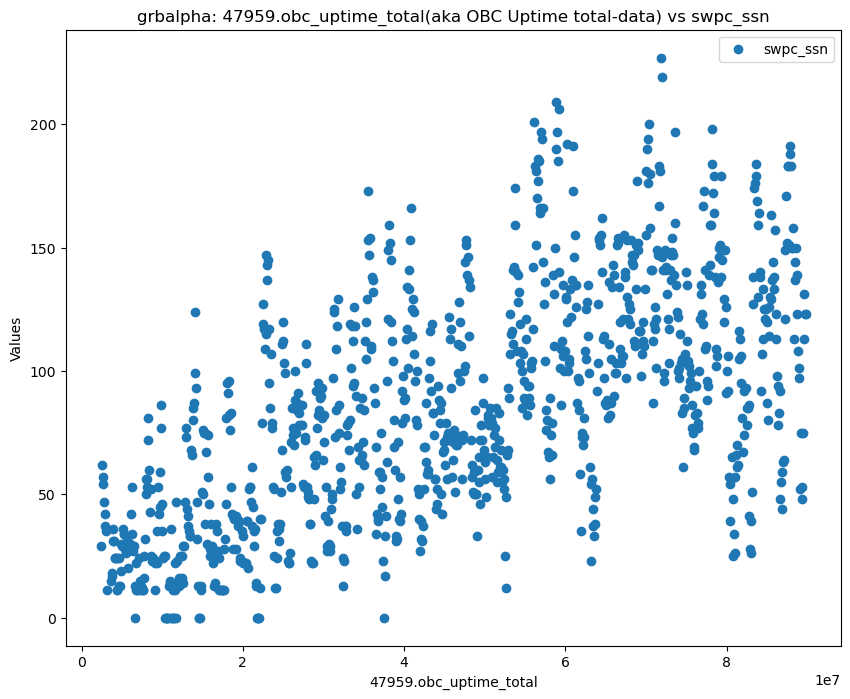

In [210]:
analyze_satellite('grbalpha')

2024-02-11 18:21:37,916 - DEBUG - Processing file: [../data/ledsat/Last Frame Rcvd By-data-2024-02-11 02 19 24.csv]
2024-02-11 18:21:37,936 - DEBUG - Processing file: [../data/ledsat/Last Frame Rcvd By-data-2024-02-11 02 21 47.csv]
2024-02-11 18:21:37,955 - DEBUG - Processing file: [../data/ledsat/Solar Panel Temperatures-data-2024-02-11 02 19 39.csv]
2024-02-11 18:21:37,973 - WARNING - Column '+X solar panel' is nearly constant, skipping.
2024-02-11 18:21:37,975 - DEBUG - Processing file: [../data/ledsat/Solar Panel Temperatures-data-2024-02-11 02 22 03.csv]
2024-02-11 18:21:37,993 - WARNING - Column '+X solar panel' is nearly constant, skipping.
2024-02-11 18:21:37,995 - DEBUG - Processing file: [../data/ledsat/System Temperatures (C)-data-2024-02-11 02 19 34.csv]


+---------+---------------+---------------+
|         |   MPPT X (°C) |      swpc_ssn |
|---------+---------------+---------------|
| count   |  403          |  403          |
| mean    |    2.15385    |   75.2035     |
| std     |    2.38176    |   41.9554     |
| min     |    0          |    0          |
| 25%     |    0          |   39          |
| 50%     |    2          |   75          |
| 75%     |    3          |  103          |
| max     |   15          |  184          |
| Chi2    | 1978.03       | 1978.03       |
| P-value |    0.00279515 |    0.00279515 |
+---------+---------------+---------------+
Correlation [MPPT X (°C)] vs [swpc_ssn]: pearson=[0.19803837403739197], spearman=[0.24113078533366528], kendal_tau=[0.1765768272482411]


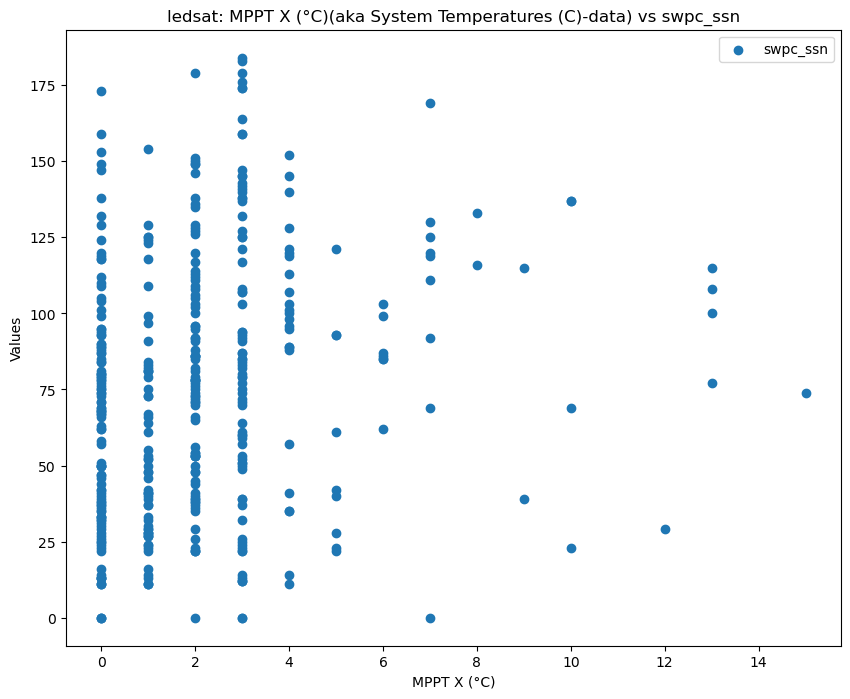

2024-02-11 18:21:38,171 - DEBUG - Processing file: [../data/ledsat/System Temperatures (C)-data-2024-02-11 02 21 57.csv]


+---------+---------------+---------------+
|         |   MPPT X (°C) |      swpc_ssn |
|---------+---------------+---------------|
| count   |  403          |  403          |
| mean    |    2.15385    |   75.2035     |
| std     |    2.38176    |   41.9554     |
| min     |    0          |    0          |
| 25%     |    0          |   39          |
| 50%     |    2          |   75          |
| 75%     |    3          |  103          |
| max     |   15          |  184          |
| Chi2    | 1978.03       | 1978.03       |
| P-value |    0.00279515 |    0.00279515 |
+---------+---------------+---------------+
Correlation [MPPT X (°C)] vs [swpc_ssn]: pearson=[0.19803837403739197], spearman=[0.24113078533366528], kendal_tau=[0.1765768272482411]


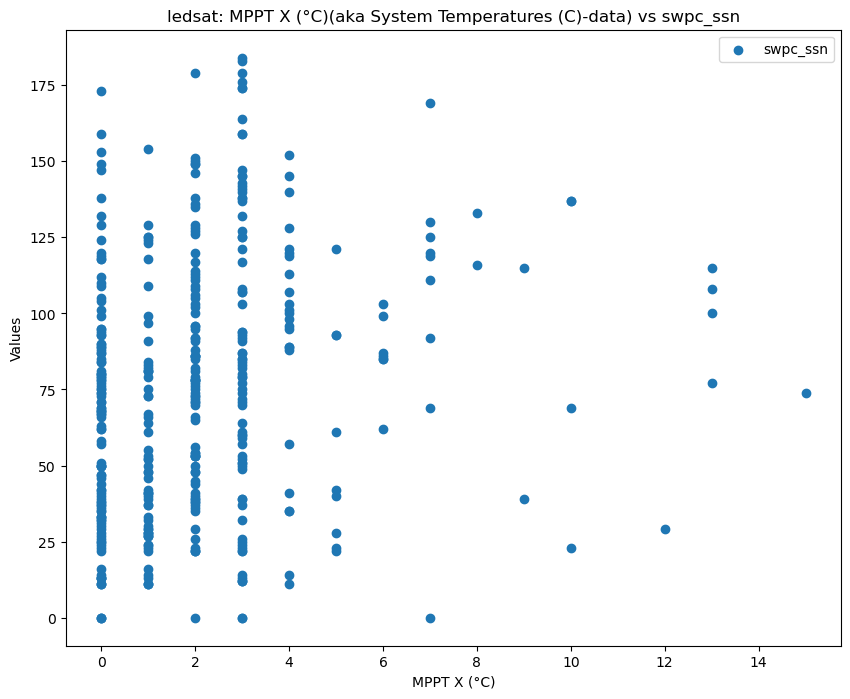

2024-02-11 18:21:38,360 - DEBUG - Processing file: [../data/ledsat/Temperatures-data-2024-02-11 02 19 22.csv]


+---------+---------------+---------------+
|         |   X axis MPPT |      swpc_ssn |
|---------+---------------+---------------|
| count   |  403          |  403          |
| mean    |    2.15385    |   75.2035     |
| std     |    2.38176    |   41.9554     |
| min     |    0          |    0          |
| 25%     |    0          |   39          |
| 50%     |    2          |   75          |
| 75%     |    3          |  103          |
| max     |   15          |  184          |
| Chi2    | 1978.03       | 1978.03       |
| P-value |    0.00279515 |    0.00279515 |
+---------+---------------+---------------+
Correlation [X axis MPPT] vs [swpc_ssn]: pearson=[0.19803837403739197], spearman=[0.24113078533366528], kendal_tau=[0.1765768272482411]


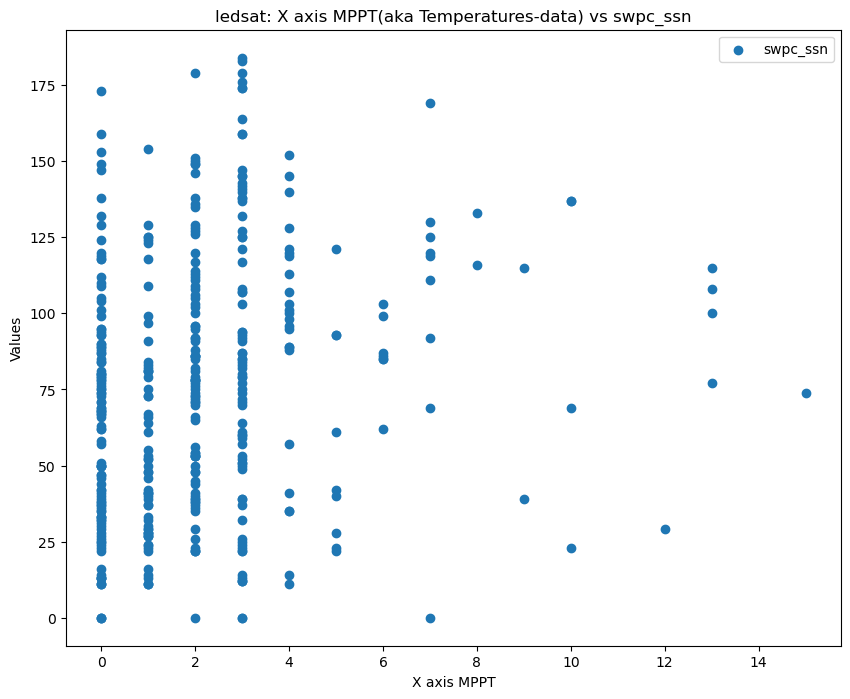

2024-02-11 18:21:38,555 - DEBUG - Processing file: [../data/ledsat/Voltages-data-2024-02-11 02 18 53.csv]


+---------+---------------------+------------+
|         |   Battery Voltage V |   swpc_ssn |
|---------+---------------------+------------|
| count   |         403         | 403        |
| mean    |           8.29777   |  75.2035   |
| std     |           0.0216249 |  41.9554   |
| min     |           8.2       |   0        |
| 25%     |           8.3       |  39        |
| 50%     |           8.3       |  75        |
| 75%     |           8.3       | 103        |
| max     |           8.4       | 184        |
| Chi2    |         247.29      | 247.29     |
| P-value |           0.907442  |   0.907442 |
+---------+---------------------+------------+
Correlation [Battery Voltage V] vs [swpc_ssn]: pearson=[-0.11547506375709894], spearman=[-0.11701318595193114], kendal_tau=[-0.09515639123885228]


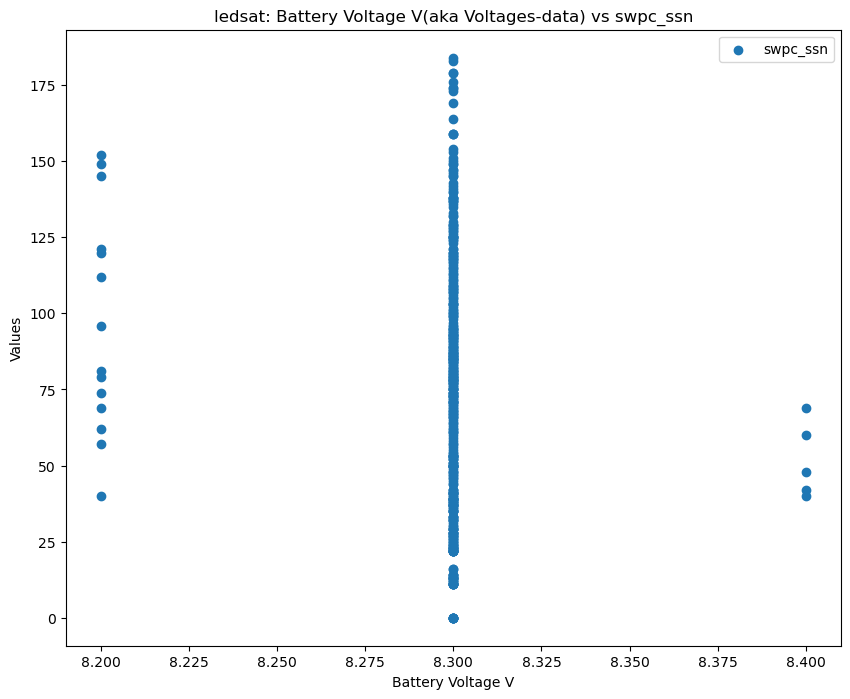

2024-02-11 18:21:38,785 - DEBUG - Processing file: [../data/ledsat/Battery Current-data-2024-02-11 02 19 26.csv]


+---------+------------------------------------------+--------------+
|         |   Total current coming from solar panels |     swpc_ssn |
|---------+------------------------------------------+--------------|
| count   |                              403         |  403         |
| mean    |                               22.2258    |   75.2035    |
| std     |                               64.7521    |   41.9554    |
| min     |                                0         |    0         |
| 25%     |                                0         |   39         |
| 50%     |                                0         |   75         |
| 75%     |                                5         |  103         |
| max     |                              426         |  184         |
| Chi2    |                             3033.56      | 3033.56      |
| P-value |                                0.0682691 |    0.0682691 |
+---------+------------------------------------------+--------------+
Correlation [Total c

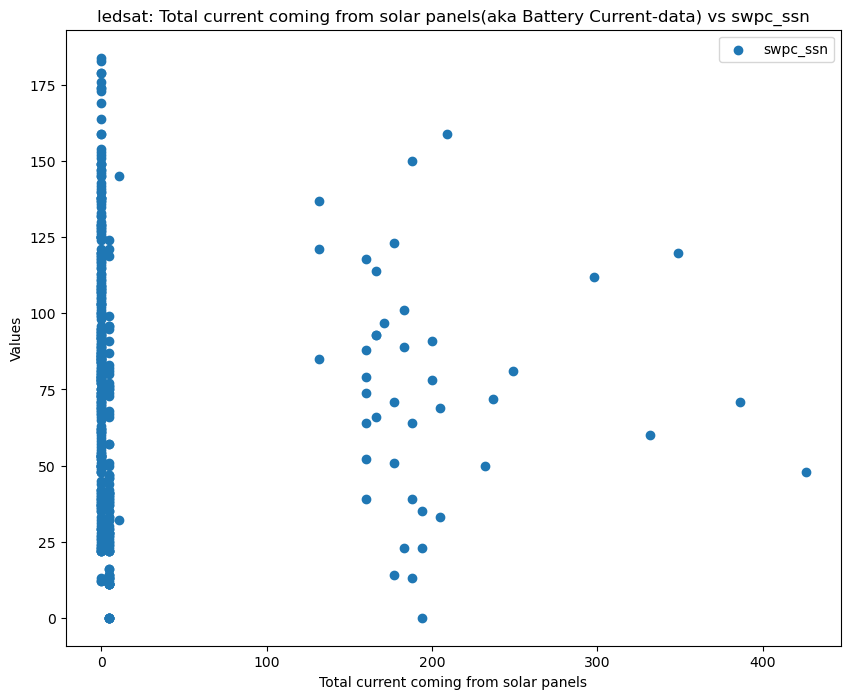

2024-02-11 18:21:38,958 - DEBUG - Processing file: [../data/ledsat/Battery Current-data-2024-02-11 02 21 49.csv]


+---------+------------------------------------------+--------------+
|         |   Total current coming from solar panels |     swpc_ssn |
|---------+------------------------------------------+--------------|
| count   |                              403         |  403         |
| mean    |                               22.2258    |   75.2035    |
| std     |                               64.7521    |   41.9554    |
| min     |                                0         |    0         |
| 25%     |                                0         |   39         |
| 50%     |                                0         |   75         |
| 75%     |                                5         |  103         |
| max     |                              426         |  184         |
| Chi2    |                             3033.56      | 3033.56      |
| P-value |                                0.0682691 |    0.0682691 |
+---------+------------------------------------------+--------------+
Correlation [Total c

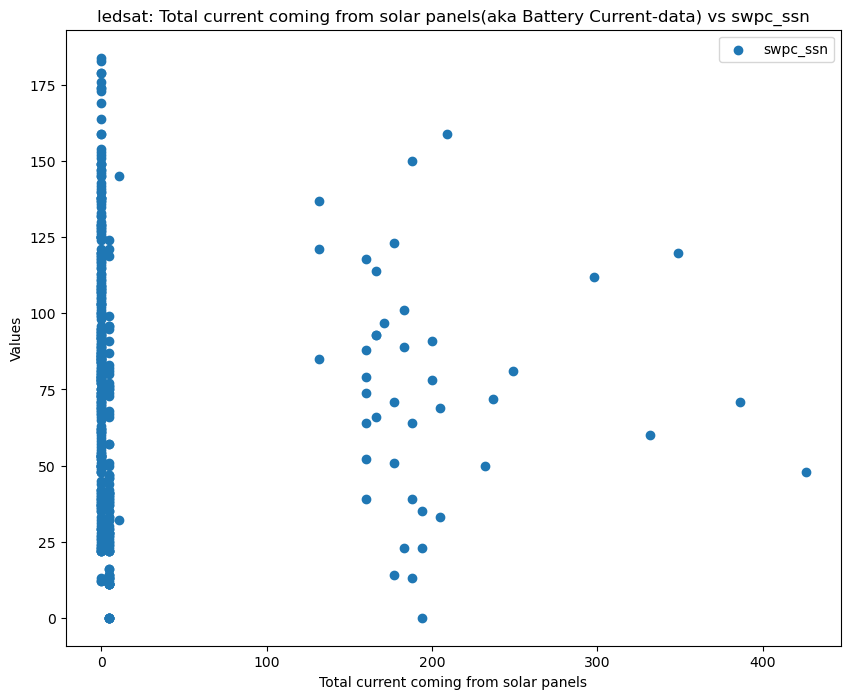

2024-02-11 18:21:39,129 - DEBUG - Processing file: [../data/ledsat/Battery Voltage-data-2024-02-11 02 19 06.csv]


+---------+----------------+-------------+
|         |   49069.mode V |    swpc_ssn |
|---------+----------------+-------------|
| count   |     74         |  74         |
| mean    |      8.30905   |  80.0405    |
| std     |      0.0265438 |  44.4758    |
| min     |      8.16      |   0         |
| 25%     |      8.3       |  44.25      |
| 50%     |      8.31      |  84         |
| 75%     |      8.33      | 113         |
| max     |      8.34      | 179         |
| Chi2    |    616.769     | 616.769     |
| P-value |      0.0726354 |   0.0726354 |
+---------+----------------+-------------+
Correlation [49069.mode V] vs [swpc_ssn]: pearson=[0.1624826166777552], spearman=[0.16795207858376093], kendal_tau=[0.1292288541557749]


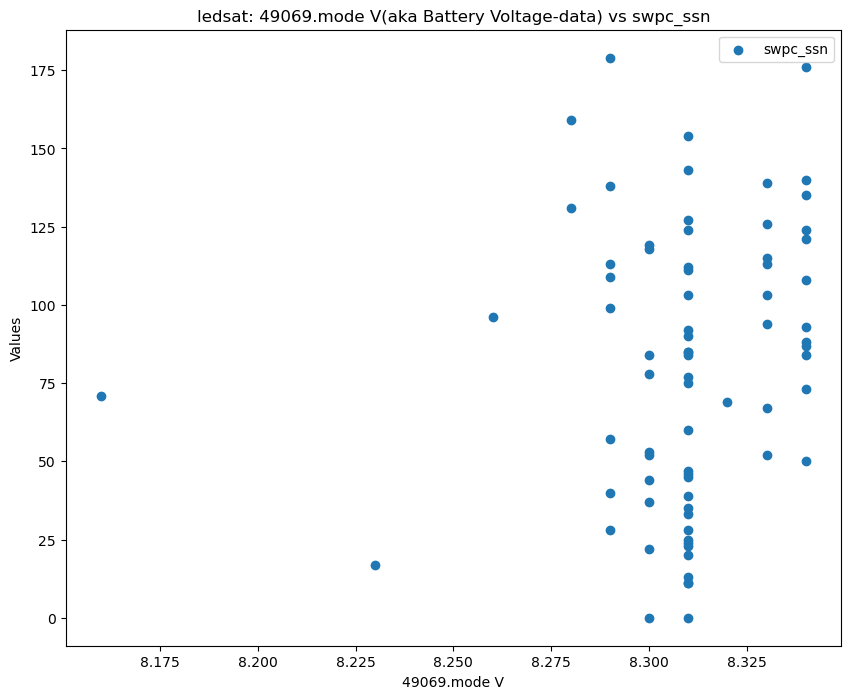

2024-02-11 18:21:39,290 - DEBUG - Processing file: [../data/ledsat/Battery Voltage-data-2024-02-11 02 21 33.csv]


+---------+----------------+-------------+
|         |   49069.mode V |    swpc_ssn |
|---------+----------------+-------------|
| count   |     74         |  74         |
| mean    |      8.30905   |  80.0405    |
| std     |      0.0265438 |  44.4758    |
| min     |      8.16      |   0         |
| 25%     |      8.3       |  44.25      |
| 50%     |      8.31      |  84         |
| 75%     |      8.33      | 113         |
| max     |      8.34      | 179         |
| Chi2    |    616.769     | 616.769     |
| P-value |      0.0726354 |   0.0726354 |
+---------+----------------+-------------+
Correlation [49069.mode V] vs [swpc_ssn]: pearson=[0.1624826166777552], spearman=[0.16795207858376093], kendal_tau=[0.1292288541557749]


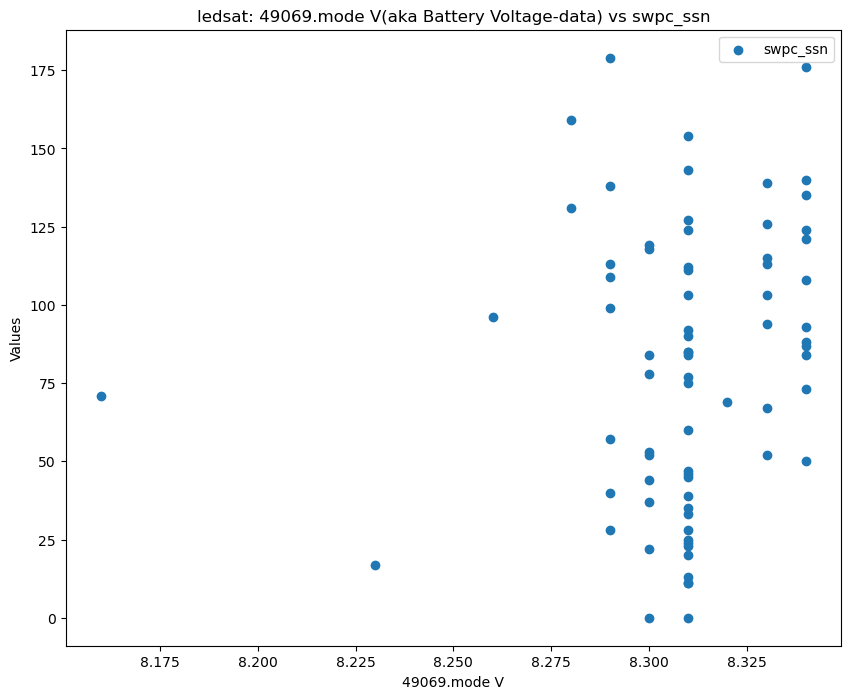

2024-02-11 18:21:39,452 - DEBUG - Processing file: [../data/ledsat/Ground Stations Leaderboard By Observed Frames-data-2024-02-11 02 18 48.csv]


+---------+----------------------+----------------+
|         |   -----OE6EUR15----- |       swpc_ssn |
|---------+----------------------+----------------|
| count   |       1449           | 1449           |
| mean    |          0.690131    |   62.7481      |
| std     |          0.951108    |   52.0369      |
| min     |          0           |    0           |
| 25%     |          0           |   14           |
| 50%     |          0           |   52           |
| 75%     |          2           |  101           |
| max     |          2           |  227           |
| Chi2    |        815.593       |  815.593       |
| P-value |          2.77906e-81 |    2.77906e-81 |
+---------+----------------------+----------------+
Correlation [-----OE6EUR15-----] vs [swpc_ssn]: pearson=[0.6901219008281757], spearman=[0.6770402694666079], kendal_tau=[0.559014424635535]


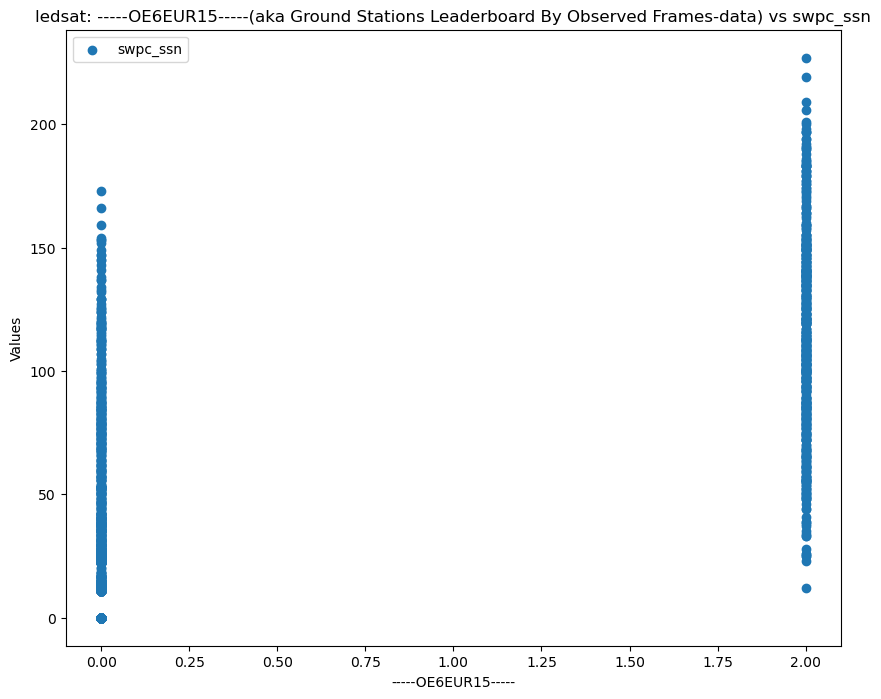

In [211]:
analyze_satellite('ledsat')

2024-02-11 18:21:39,638 - DEBUG - Processing file: [../data/ramsat/Elevation-data-2024-02-11 02 21 27.csv]


+---------+----------------------------------+------------------+
|         |   Elevation (onboard prediction) |         swpc_ssn |
|---------+----------------------------------+------------------|
| count   |                   484            |   484            |
| mean    |                   326.969        |    62.1322       |
| std     |                   125.551        |    38.5939       |
| min     |                     0            |     0            |
| 25%     |                   330            |    31            |
| 50%     |                   377            |    56.5          |
| 75%     |                   400            |    87            |
| max     |                   417            |   173            |
| Chi2    |                 23251.6          | 23251.6          |
| P-value |                     2.03977e-152 |     2.03977e-152 |
+---------+----------------------------------+------------------+
Correlation [Elevation (onboard prediction)] vs [swpc_ssn]: pearson=[0.02981

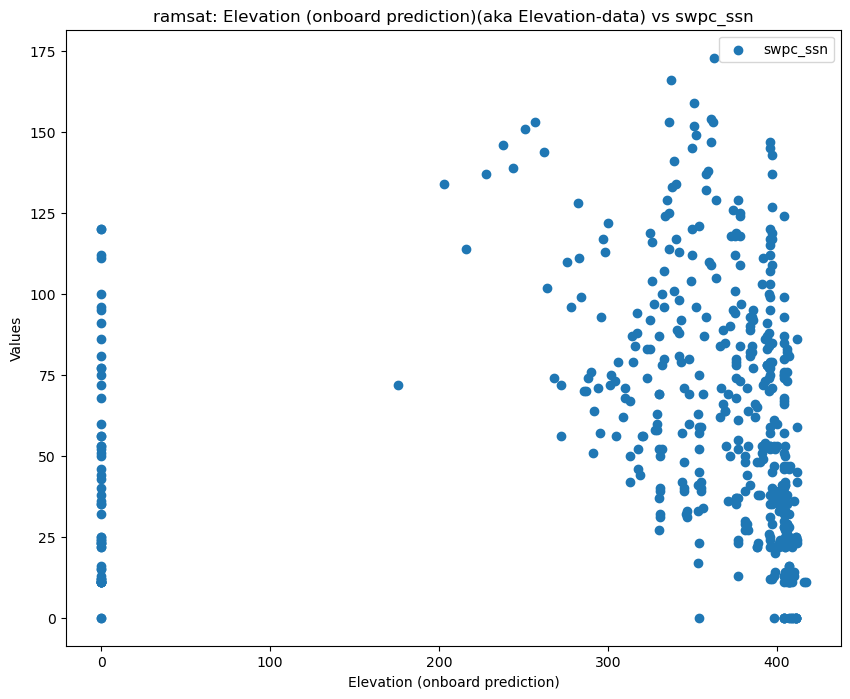

In [212]:
analyze_satellite('ramsat')

2024-02-11 18:21:39,816 - DEBUG - Processing file: [../data/ops-sat/RSSI Levels-data-2024-02-11 02 22 31.csv]
2024-02-11 18:21:39,836 - WARNING - Column 'Background RSSI Level' is nearly constant, skipping.
2024-02-11 18:21:39,838 - DEBUG - Processing file: [../data/ops-sat/Total RX Packets-data-2024-02-11 02 23 05.csv]


+---------+--------------+------------+
|         |   44878.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |       188    |   188      |
| mean    |     21452    |    68.9043 |
| std     |      3259.85 |    50.199  |
| min     |      5129    |     0      |
| 25%     |     20756.8  |    24      |
| 50%     |     22126    |    60.5    |
| 75%     |     23118    |   112      |
| max     |     24600    |   179      |
| Chi2    |     12334.6  | 12334.6    |
| P-value |         1    |     1      |
+---------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.5748628313476977], spearman=[0.7857285673694304], kendal_tau=[0.5786804345788774]


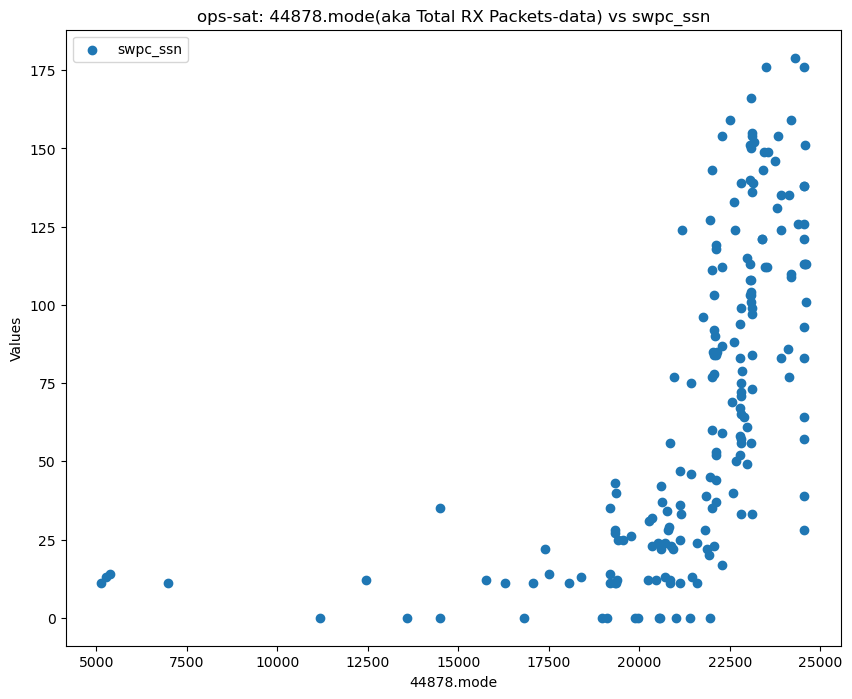

2024-02-11 18:21:40,007 - DEBUG - Processing file: [../data/ops-sat/Total TX Bytes-data-2024-02-11 02 23 09.csv]


+---------+-----------------+--------------+
|         |      44878.mode |     swpc_ssn |
|---------+-----------------+--------------|
| count   |   188           |   188        |
| mean    |     2.89948e+09 |    68.9043   |
| std     |     5.94793e+08 |    50.199    |
| min     |     1.42965e+07 |     0        |
| 25%     |     2.91416e+09 |    24        |
| 50%     |     3.06149e+09 |    60.5      |
| 75%     |     3.20752e+09 |   112        |
| max     |     3.34178e+09 |   179        |
| Chi2    | 18424           | 18424        |
| P-value |     0.303465    |     0.303465 |
+---------+-----------------+--------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.5353106560668386], spearman=[0.7858898612127606], kendal_tau=[0.5767193747435023]


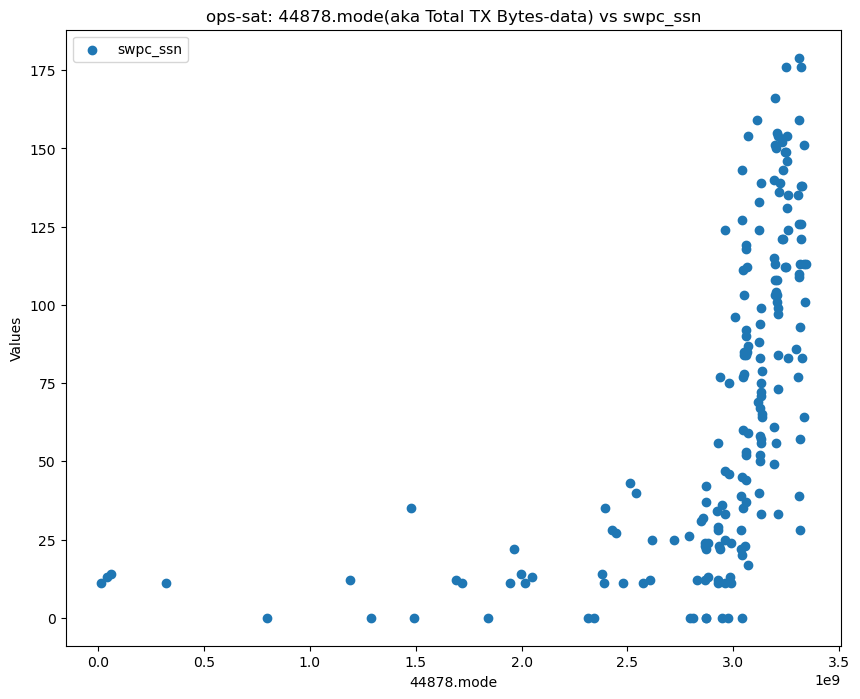

2024-02-11 18:21:40,181 - DEBUG - Processing file: [../data/ops-sat/Total TX duty time since reboot-data-2024-02-11 02 22 24.csv]


+---------+--------------+------------+
|         |   44878.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |    188       |   188      |
| mean    |      2.46277 |    68.9043 |
| std     |      5.21861 |    50.199  |
| min     |      0       |     0      |
| 25%     |      0       |    24      |
| 50%     |      0       |    60.5    |
| 75%     |      2       |   112      |
| max     |     35       |   179      |
| Chi2    |   1182.93    |  1182.93   |
| P-value |      1       |     1      |
+---------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.3204786726051506], spearman=[-0.4292673343841385], kendal_tau=[-0.33004813384919396]


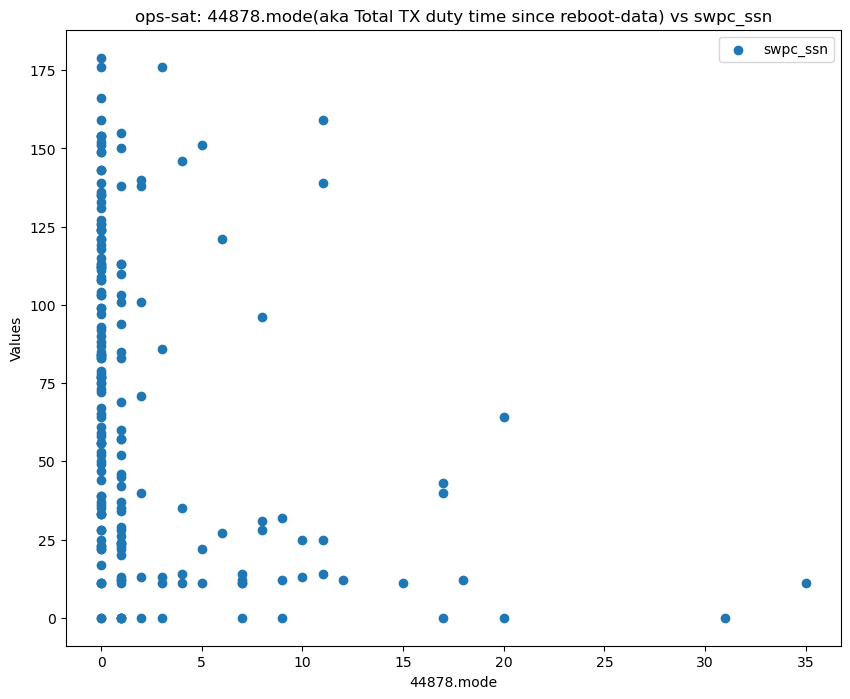

2024-02-11 18:21:40,355 - DEBUG - Processing file: [../data/ops-sat/Total TX Packets-data-2024-02-11 02 23 12.csv]


+---------+------------------+--------------+
|         |       44878.mode |     swpc_ssn |
|---------+------------------+--------------|
| count   |    188           |   188        |
| mean    |      1.6614e+07  |    68.9043   |
| std     |      3.55207e+06 |    50.199    |
| min     | 176553           |     0        |
| 25%     |      1.66055e+07 |    24        |
| 50%     |      1.75827e+07 |    60.5      |
| 75%     |      1.85426e+07 |   112        |
| max     |      1.9407e+07  |   179        |
| Chi2    |  18424           | 18424        |
| P-value |      0.303465    |     0.303465 |
+---------+------------------+--------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.5561946696013134], spearman=[0.7858898612127606], kendal_tau=[0.5767193747435023]


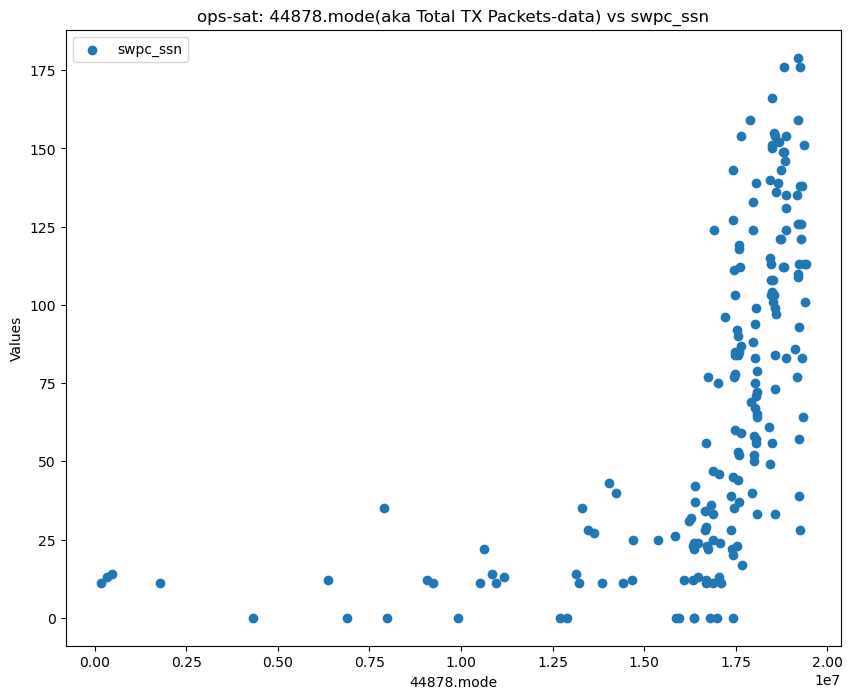

2024-02-11 18:21:40,525 - DEBUG - Processing file: [../data/ops-sat/TX bytes since reboot-data-2024-02-11 02 22 51.csv]


+---------+------------------+--------------+
|         |       44878.mode |     swpc_ssn |
|---------+------------------+--------------|
| count   |    188           |   188        |
| mean    |      1.2581e+07  |    68.9043   |
| std     |      4.53865e+07 |    50.199    |
| min     |   3008           |     0        |
| 25%     |  79537.8         |    24        |
| 50%     | 546839           |    60.5      |
| 75%     |      3.14044e+06 |   112        |
| max     |      3.70719e+08 |   179        |
| Chi2    |  17844.3         | 17844.3      |
| P-value |      0.138466    |     0.138466 |
+---------+------------------+--------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.2918840914794443], spearman=[-0.27982887225292064], kendal_tau=[-0.18135307800557543]


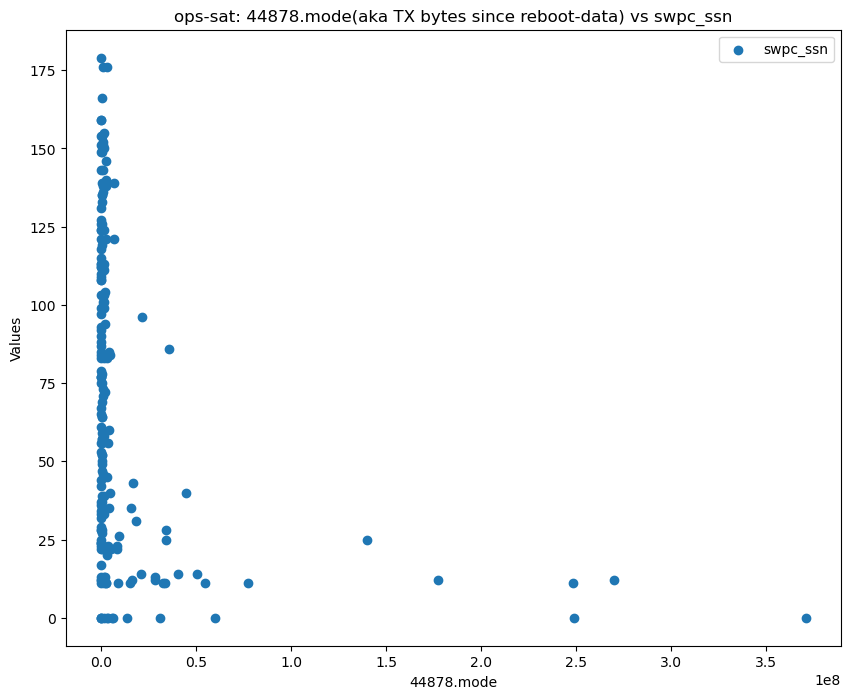

2024-02-11 18:21:40,696 - DEBUG - Processing file: [../data/ops-sat/TX packets since reboot-data-2024-02-11 02 22 55.csv]


+---------+------------------+-----------------+
|         |       44878.mode |        swpc_ssn |
|---------+------------------+-----------------|
| count   |   1289           |   1289          |
| mean    |  74049.3         |     67.5679     |
| std     | 222726           |     51.1105     |
| min     |      1           |      0          |
| 25%     |   1069           |     23          |
| 50%     |   5386           |     59          |
| 75%     |  22765           |    106          |
| max     |      1.71596e+06 |    227          |
| Chi2    | 212417           | 212417          |
| P-value |      0.00592803  |      0.00592803 |
+---------+------------------+-----------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.32635194664806416], spearman=[-0.2839994754465362], kendal_tau=[-0.18962512401888412]


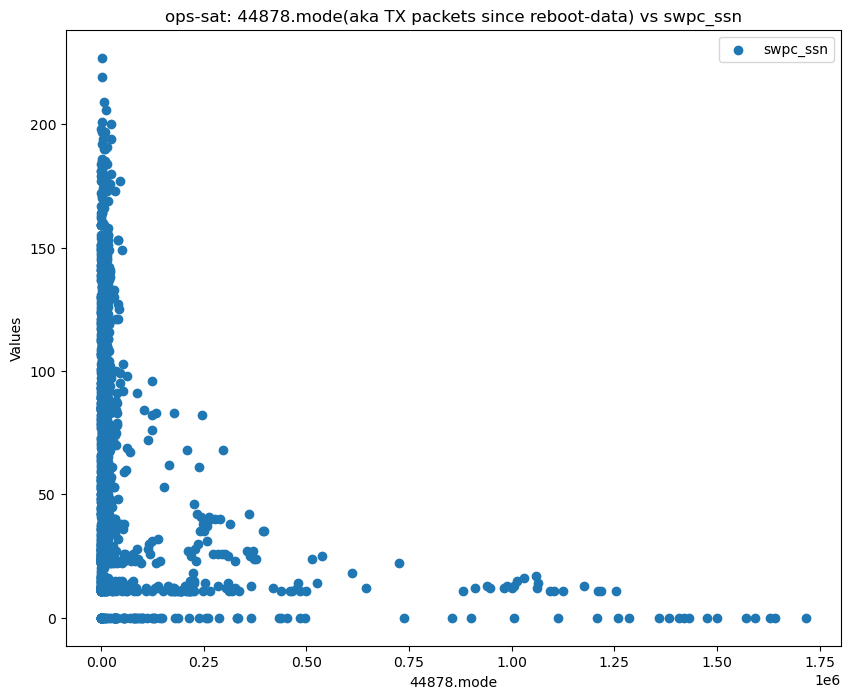

2024-02-11 18:21:40,897 - DEBUG - Processing file: [../data/ops-sat/Active Transceiver Configuration-data-2024-02-11 02 22 36.csv]


+---------+--------------+------------+
|         |   44878.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |   188        | 188        |
| mean    |     1.82447  |  68.9043   |
| std     |     0.381437 |  50.199    |
| min     |     1        |   0        |
| 25%     |     2        |  24        |
| 50%     |     2        |  60.5      |
| 75%     |     2        | 112        |
| max     |     2        | 179        |
| Chi2    |    84.3761   |  84.3761   |
| P-value |     0.834989 |   0.834989 |
+---------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.15328036522496197], spearman=[0.1725486775668712], kendal_tau=[0.14217416584584225]


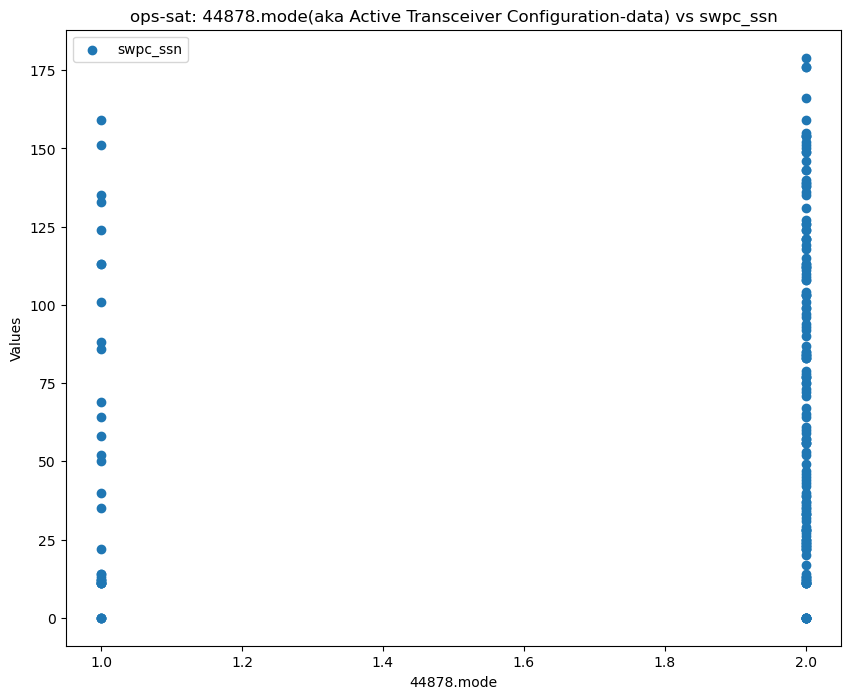

2024-02-11 18:21:41,086 - DEBUG - Processing file: [../data/ops-sat/Last Frame Rcvd By-data-2024-02-11 02 22 33.csv]


+-------+--------------------------+------------+
|       |   last where 0 is DP0OPS |   swpc_ssn |
|-------+--------------------------+------------|
| count |                        0 |          0 |
| mean  |                      nan |        nan |
| std   |                      nan |        nan |
| min   |                      nan |        nan |
| 25%   |                      nan |        nan |
| 50%   |                      nan |        nan |
| 75%   |                      nan |        nan |
| max   |                      nan |        nan |
+-------+--------------------------+------------+
Correlation [last where 0 is DP0OPS] vs [swpc_ssn]: pearson=[nan], spearman=[nan], kendal_tau=[nan]


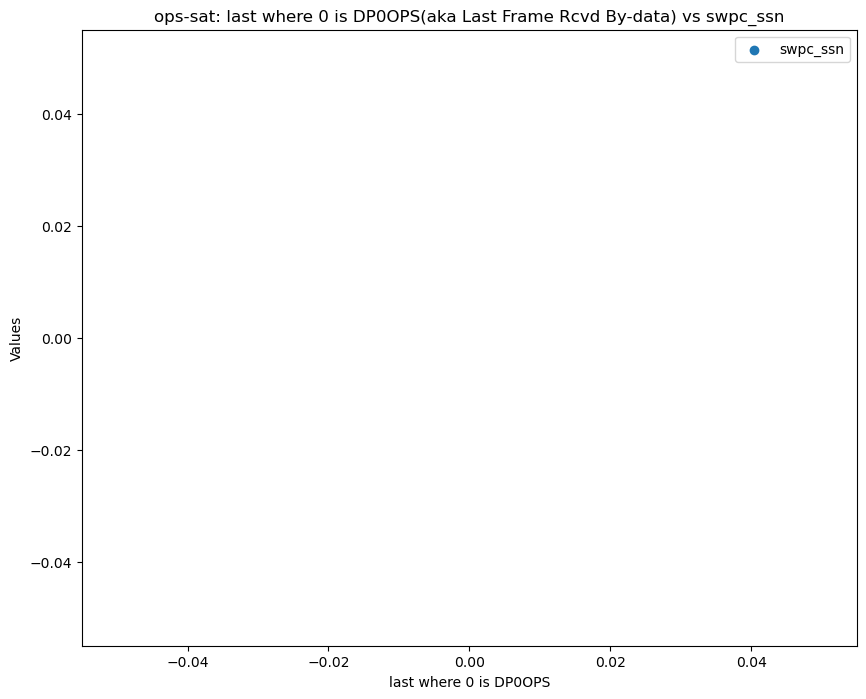

+-------+------------------------------------+------------+
|       |   observer where 0 is EA6TC-JM19jn |   swpc_ssn |
|-------+------------------------------------+------------|
| count |                                  0 |          0 |
| mean  |                                nan |        nan |
| std   |                                nan |        nan |
| min   |                                nan |        nan |
| 25%   |                                nan |        nan |
| 50%   |                                nan |        nan |
| 75%   |                                nan |        nan |
| max   |                                nan |        nan |
+-------+------------------------------------+------------+
Correlation [observer where 0 is EA6TC-JM19jn] vs [swpc_ssn]: pearson=[nan], spearman=[nan], kendal_tau=[nan]


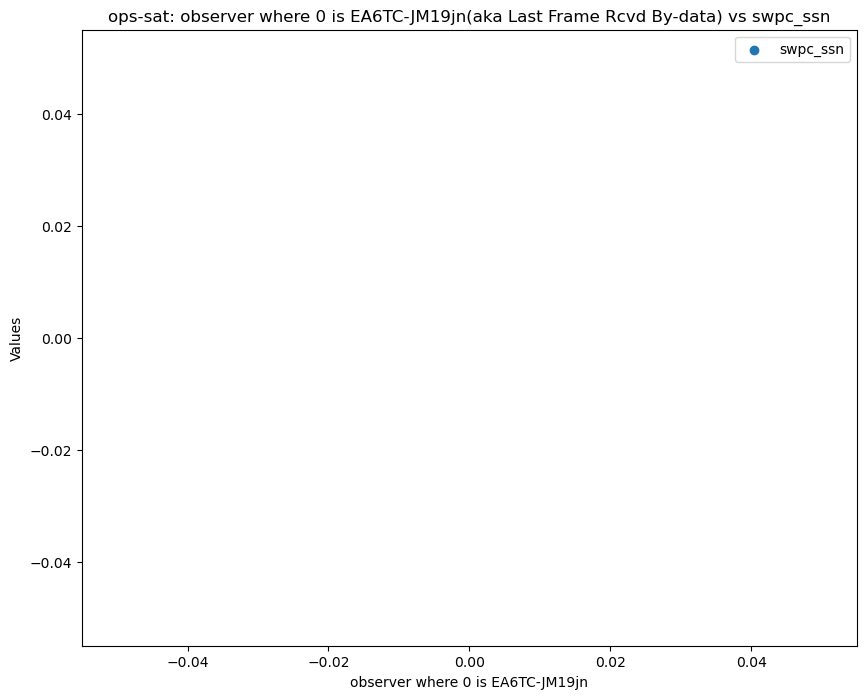

2024-02-11 18:21:41,328 - DEBUG - Processing file: [../data/ops-sat/Last frame-data-2024-02-11 02 22 26.csv]
2024-02-11 18:21:41,398 - WARNING - Column '44878.last' is nearly constant, skipping.
2024-02-11 18:21:41,401 - DEBUG - Processing file: [../data/ops-sat/Last RX Frequency Offset-data-2024-02-11 02 22 40.csv]


+---------+--------------+------------+
|         |   44878.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |    1289      |  1289      |
| mean    |      59.9108 |    67.5679 |
| std     |    1063.59   |    51.1105 |
| min     |  -10471      |     0      |
| 25%     |       0      |    23      |
| 50%     |     212      |    59      |
| 75%     |     446      |   106      |
| max     |    4810      |   227      |
| Chi2    |   48612.2    | 48612.2    |
| P-value |       1      |     1      |
+---------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.1787243752541007], spearman=[-0.3397847873246419], kendal_tau=[-0.2429687701330934]


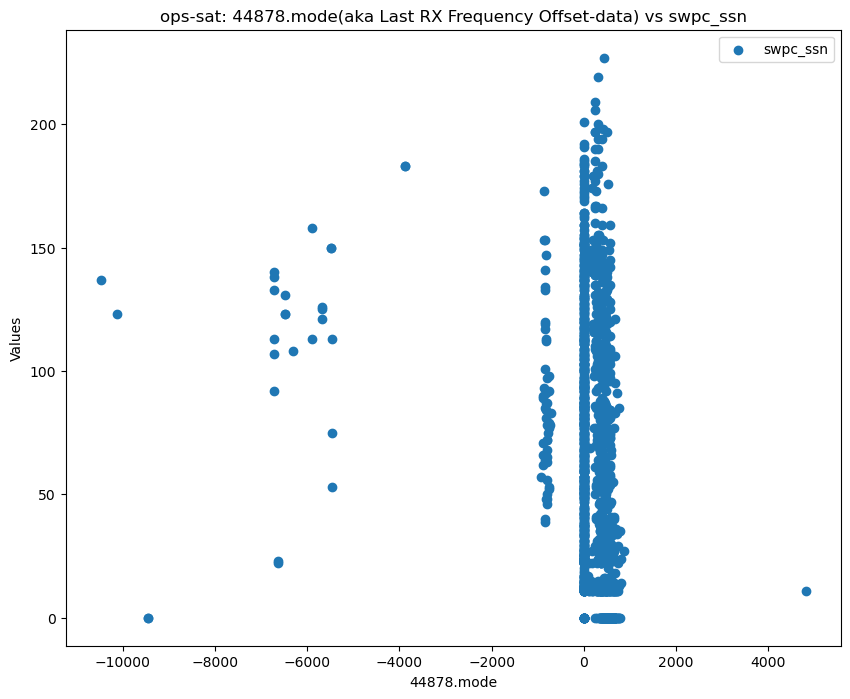

2024-02-11 18:21:41,584 - DEBUG - Processing file: [../data/ops-sat/Last valid RX packet timestamp-data-2024-02-11 02 22 43.csv]


+---------+---------------------+------------+
|         |   Last RX timestamp |   swpc_ssn |
|---------+---------------------+------------|
| count   |       188           |   188      |
| mean    |         1.50759e+09 |    68.9043 |
| std     |         9.2103e+08  |    50.199  |
| min     |         9.47637e+08 |     0      |
| 25%     |         9.55291e+08 |    24      |
| 50%     |         1.03348e+09 |    60.5    |
| 75%     |         1.0365e+09  |   112      |
| max     |         3.12114e+09 |   179      |
| Chi2    |     12334.6         | 12334.6    |
| P-value |         1           |     1      |
+---------+---------------------+------------+
Correlation [Last RX timestamp] vs [swpc_ssn]: pearson=[-0.18111889169521622], spearman=[-0.020300742229652155], kendal_tau=[-0.01649104207369058]


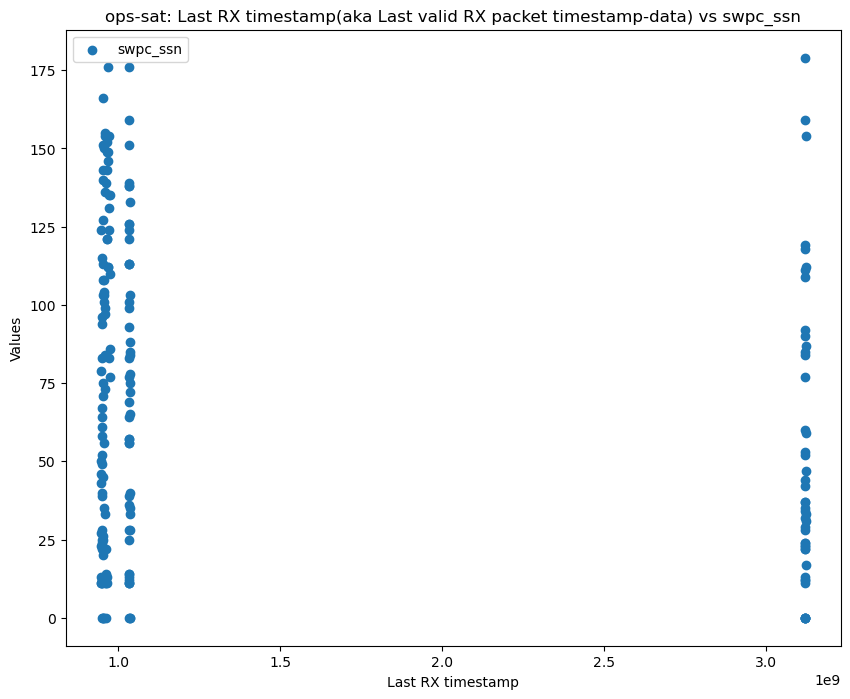

2024-02-11 18:21:41,751 - DEBUG - Processing file: [../data/ops-sat/Number of transceiver reboots-data-2024-02-11 02 22 20.csv]


+---------+--------------+------------+
|         |   44878.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |     1289     |  1289      |
| mean    |     1039.94  |    67.5679 |
| std     |      262.858 |    51.1105 |
| min     |      534     |     0      |
| 25%     |      925     |    23      |
| 50%     |     1161     |    59      |
| 75%     |     1222     |   106      |
| max     |     1305     |   227      |
| Chi2    |    52698.7   | 52698.7    |
| P-value |        1     |     1      |
+---------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.6808436708746547], spearman=[0.803383853194286], kendal_tau=[0.6007578538393359]


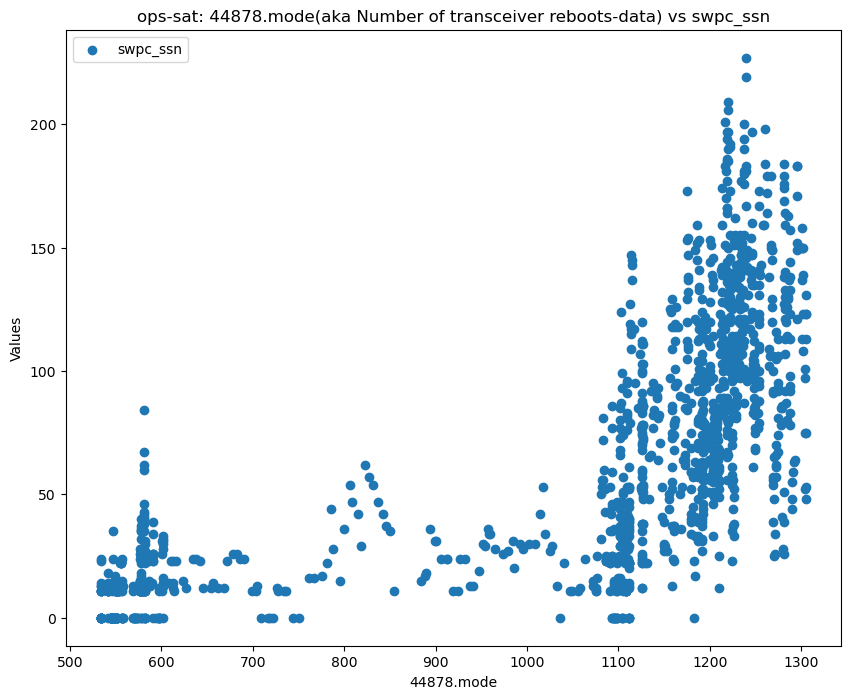

2024-02-11 18:21:41,936 - DEBUG - Processing file: [../data/ops-sat/Reboot cause code-data-2024-02-11 02 23 01.csv]


+---------+---------------+---------------+
|         |    44878.mode |      swpc_ssn |
|---------+---------------+---------------|
| count   | 1289          | 1289          |
| mean    |  169.351      |   67.5679     |
| std     |  120.825      |   51.1105     |
| min     |    1          |    0          |
| 25%     |    1          |   23          |
| 50%     |  256          |   59          |
| 75%     |  256          |  106          |
| max     |  256          |  227          |
| Chi2    |  232.501      |  232.501      |
| P-value |    0.00507706 |    0.00507706 |
+---------+---------------+---------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.12213818030282121], spearman=[0.12378038887956977], kendal_tau=[0.10183854610327941]


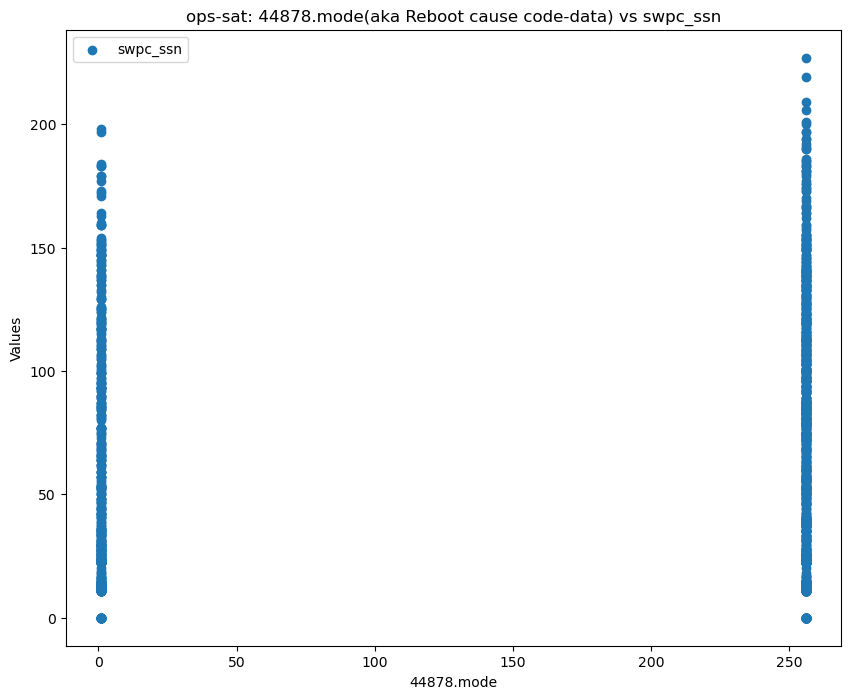

2024-02-11 18:21:42,100 - DEBUG - Processing file: [../data/ops-sat/RX bytes since reboot-data-2024-02-11 02 22 46.csv]


+---------+--------------+------------+
|         |   44878.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |       188    |   188      |
| mean    |      3552.3  |    68.9043 |
| std     |     13749    |    50.199  |
| min     |         0    |     0      |
| 25%     |         0    |    24      |
| 50%     |        82    |    60.5    |
| 75%     |      1040.25 |   112      |
| max     |    125791    |   179      |
| Chi2    |      8028.37 |  8028.37   |
| P-value |         1    |     1      |
+---------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.261793611402168], spearman=[-0.28165869536918936], kendal_tau=[-0.19665418137960228]


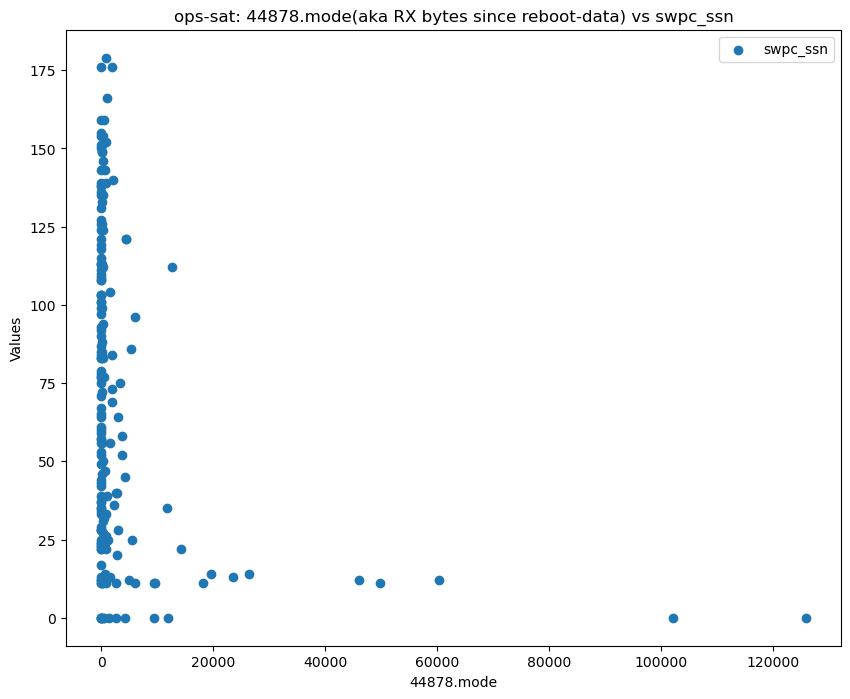

2024-02-11 18:21:42,266 - DEBUG - Processing file: [../data/ops-sat/RX packets since reboot-data-2024-02-11 02 22 49.csv]


+---------+--------------+------------+
|         |   44878.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |    1289      |  1289      |
| mean    |      75.1311 |    67.5679 |
| std     |     246.648  |    51.1105 |
| min     |       0      |     0      |
| 25%     |       0      |    23      |
| 50%     |       5      |    59      |
| 75%     |      29      |   106      |
| max     |    2231      |   227      |
| Chi2    |   23807.7    | 23807.7    |
| P-value |       1      |     1      |
+---------+--------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[-0.2816047057681802], spearman=[-0.2944798008540808], kendal_tau=[-0.21233242876313882]


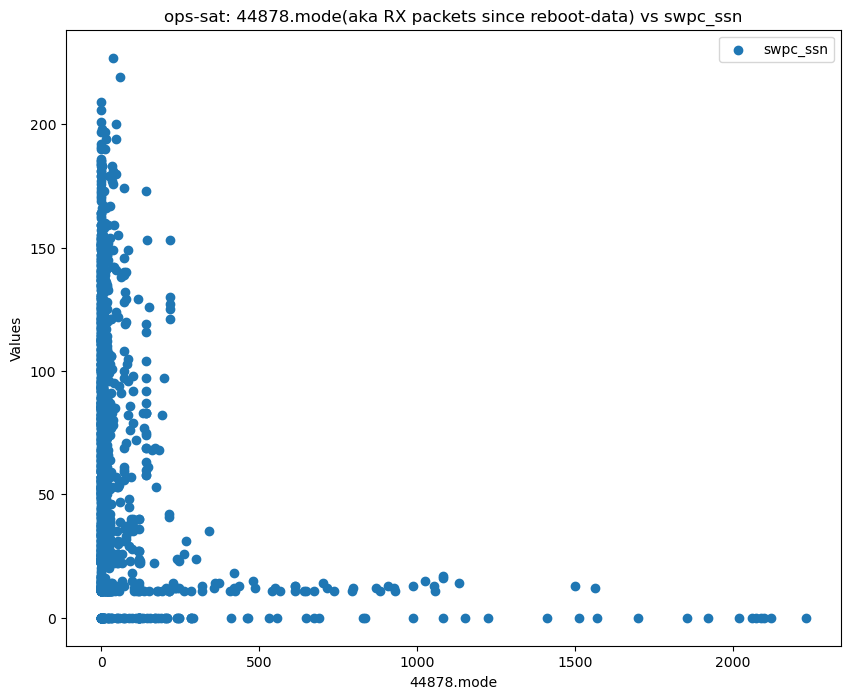

2024-02-11 18:21:42,435 - DEBUG - Processing file: [../data/ops-sat/Selected frames count-data-2024-02-11 02 22 13.csv]


+---------+-------------------+-------------------+
|         |            Frames |          swpc_ssn |
|---------+-------------------+-------------------|
| count   |   1449            |   1449            |
| mean    | 130535            |     62.7481       |
| std     |  62472            |     52.0369       |
| min     |      0            |      0            |
| 25%     | 108054            |     14            |
| 50%     | 134599            |     52            |
| 75%     | 172671            |    101            |
| max     | 225936            |    227            |
| Chi2    | 250306            | 250306            |
| P-value |      5.05279e-128 |      5.05279e-128 |
+---------+-------------------+-------------------+
Correlation [Frames] vs [swpc_ssn]: pearson=[0.7330561930756717], spearman=[0.8333018545991522], kendal_tau=[0.6322657615049996]


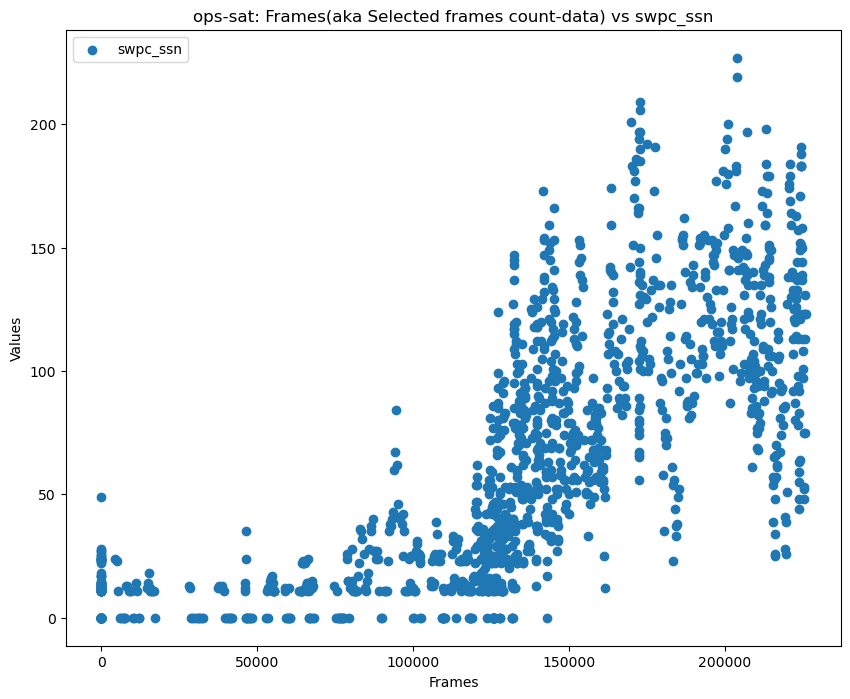

2024-02-11 18:21:42,620 - DEBUG - Processing file: [../data/ops-sat/Total RX Bytes-data-2024-02-11 02 22 57.csv]


+---------+------------------+------------+
|         |       44878.mode |   swpc_ssn |
|---------+------------------+------------|
| count   |    188           |   188      |
| mean    |      1.0835e+06  |    68.9043 |
| std     | 127400           |    50.199  |
| min     | 392180           |     0      |
| 25%     |      1.05803e+06 |    24      |
| 50%     |      1.10793e+06 |    60.5    |
| 75%     |      1.14679e+06 |   112      |
| max     |      1.19440e+06 |   179      |
| Chi2    |  12334.6         | 12334.6    |
| P-value |      1           |     1      |
+---------+------------------+------------+
Correlation [44878.mode] vs [swpc_ssn]: pearson=[0.5380133871877748], spearman=[0.7857285673694304], kendal_tau=[0.5786804345788774]


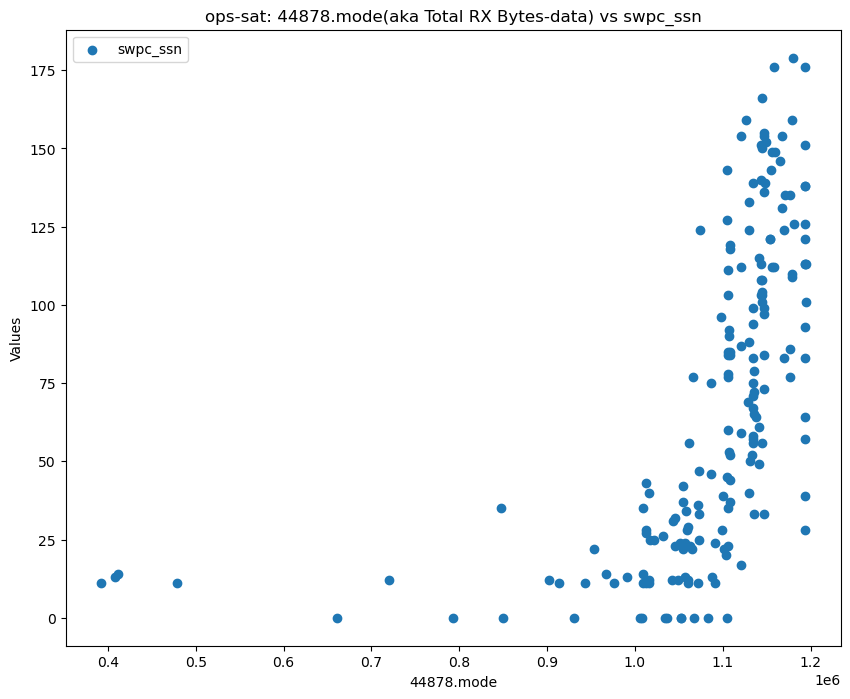

In [213]:
analyze_satellite('ops-sat')

2024-02-11 18:21:42,827 - DEBUG - Processing file: [../data/veronika/UHF Digipeater usage-data-2024-02-11 02 22 38.csv]


+---------+--------------+------------+
|         |   58261.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |     13       |   13       |
| mean    |     28.6154  |  111.154   |
| std     |     16.0963  |   38.6455  |
| min     |      0       |   28       |
| 25%     |     17       |   93       |
| 50%     |     39       |  113       |
| 75%     |     42       |  138       |
| max     |     43       |  176       |
| Chi2    |     87.75    |   87.75    |
| P-value |      0.25905 |    0.25905 |
+---------+--------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[0.21471666569320857], spearman=[0.015235515517624728], kendal_tau=[-0.026669037353133248]


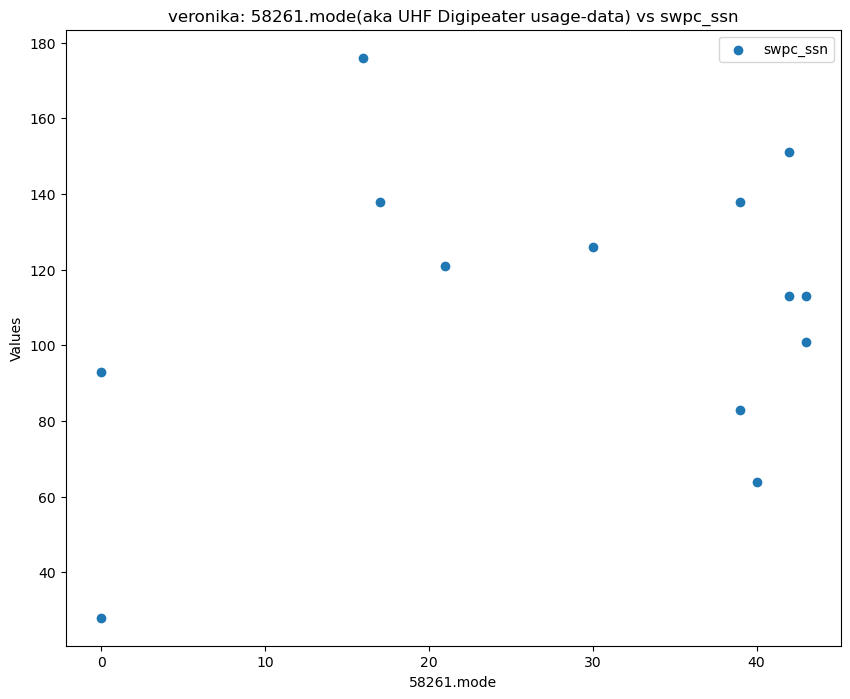

2024-02-11 18:21:42,975 - DEBUG - Processing file: [../data/veronika/UHF Temperatures-data-2024-02-11 02 23 07.csv]


+---------+--------------+--------------+
|         |     MCU (°C) |     swpc_ssn |
|---------+--------------+--------------|
| count   |   85         |   85         |
| mean    |    2.04588   |  117.176     |
| std     |    4.15496   |   42.2862    |
| min     |   -3         |   26         |
| 25%     |   -1         |   86         |
| 50%     |    0.54      |  123         |
| 75%     |    4.9       |  149         |
| max     |   15         |  191         |
| Chi2    | 2498.29      | 2498.29      |
| P-value |    0.0047717 |    0.0047717 |
+---------+--------------+--------------+
Correlation [MCU (°C)] vs [swpc_ssn]: pearson=[-0.057043332723949264], spearman=[-0.07386560505897043], kendal_tau=[-0.05313741753683994]


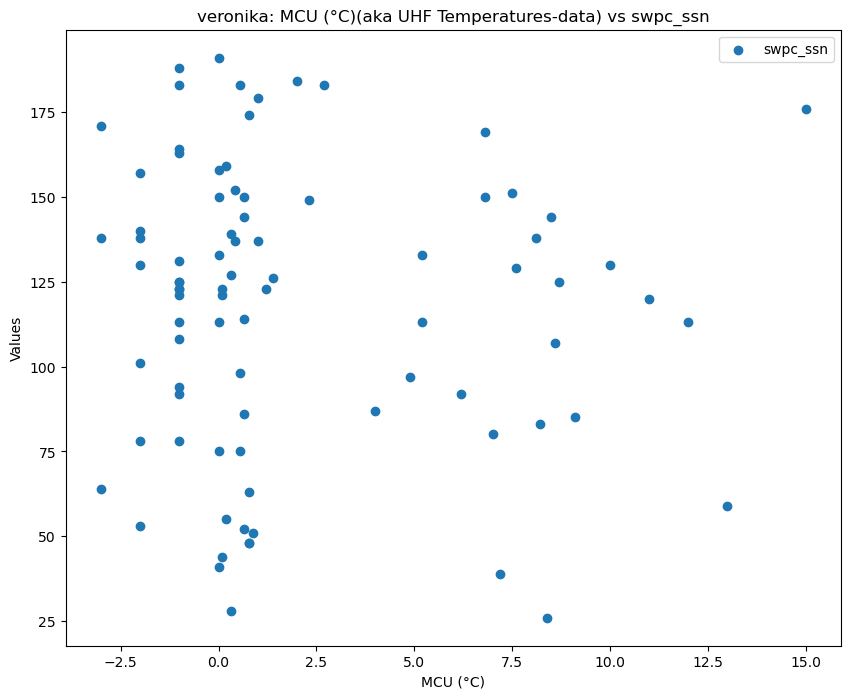

2024-02-11 18:21:43,133 - DEBUG - Processing file: [../data/veronika/UHF Transmitted packets-data-2024-02-11 02 23 22.csv]


+---------+---------------+------------+
|         |    58261.mode |   swpc_ssn |
|---------+---------------+------------|
| count   |     13        |  13        |
| mean    | 451529        | 111.154    |
| std     | 313169        |  38.6455   |
| min     |  11665        |  28        |
| 25%     | 176553        |  93        |
| 50%     | 474357        | 113        |
| 75%     | 744778        | 138        |
| max     | 868583        | 176        |
| Chi2    |    130        | 130        |
| P-value |      0.251062 |   0.251062 |
+---------+---------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[0.04947440917428154], spearman=[-0.024793482509275887], kendal_tau=[-0.0519524333466131]


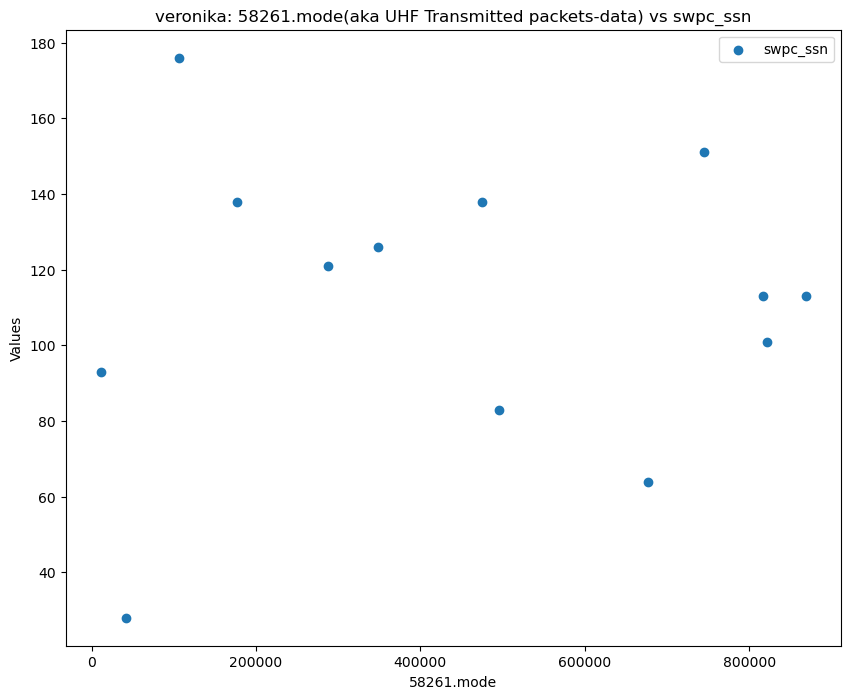

2024-02-11 18:21:43,283 - DEBUG - Processing file: [../data/veronika/UHF Uptime (s)-data-2024-02-11 02 22 42.csv]


+---------+------------------+------------+
|         |       58261.mode |   swpc_ssn |
|---------+------------------+------------|
| count   |     13           |  13        |
| mean    |      3.64372e+06 | 111.154    |
| std     |      2.31573e+06 |  38.6455   |
| min     | 178201           |  28        |
| 25%     |      1.73195e+06 |  93        |
| 50%     |      3.94287e+06 | 113        |
| 75%     |      5.27738e+06 | 138        |
| max     |      7.09168e+06 | 176        |
| Chi2    |    130           | 130        |
| P-value |      0.251062    |   0.251062 |
+---------+------------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[0.06104289922773398], spearman=[-0.024793482509275887], kendal_tau=[-0.0519524333466131]


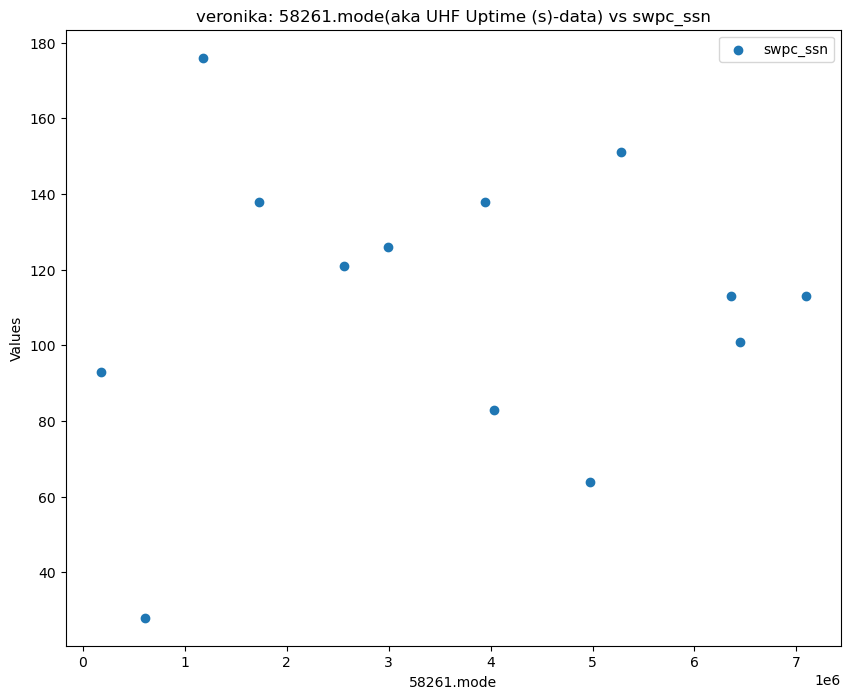

2024-02-11 18:21:43,443 - DEBUG - Processing file: [../data/veronika/UHF Uptime Tot. (s)-data-2024-02-11 02 22 48.csv]


+---------+------------------+------------+
|         |       58261.mode |   swpc_ssn |
|---------+------------------+------------|
| count   |     13           |  13        |
| mean    |      3.64374e+06 | 111.154    |
| std     |      2.31573e+06 |  38.6455   |
| min     | 178224           |  28        |
| 25%     |      1.73197e+06 |  93        |
| 50%     |      3.94289e+06 | 113        |
| 75%     |      5.27740e+06 | 138        |
| max     |      7.0917e+06  | 176        |
| Chi2    |    130           | 130        |
| P-value |      0.251062    |   0.251062 |
+---------+------------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[0.06104289922773398], spearman=[-0.024793482509275887], kendal_tau=[-0.0519524333466131]


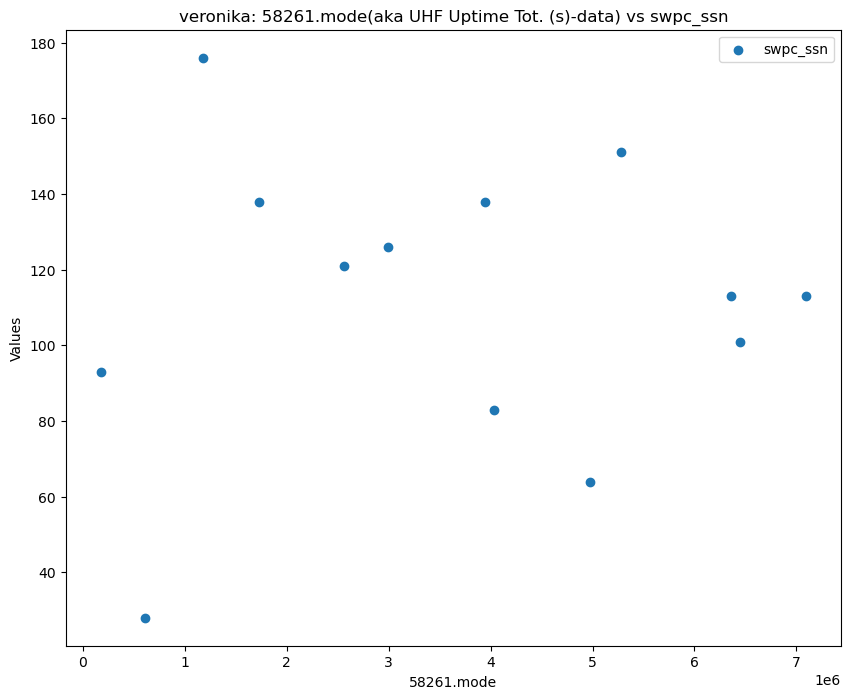

2024-02-11 18:21:43,604 - DEBUG - Processing file: [../data/veronika/UHF Uptime Tot.-data-2024-02-11 02 22 58.csv]


+---------+-------------------------+------------+
|         |   58261.mode week (day) |   swpc_ssn |
|---------+-------------------------+------------|
| count   |               13        |  13        |
| mean    |                6.16038  | 111.154    |
| std     |                3.63519  |  38.6455   |
| min     |                1.012    |  28        |
| 25%     |                2.864    |  93        |
| 50%     |                6.519    | 113        |
| 75%     |                8.726    | 138        |
| max     |               11.726    | 176        |
| Chi2    |              130        | 130        |
| P-value |                0.251062 |   0.251062 |
+---------+-------------------------+------------+
Correlation [58261.mode week (day)] vs [swpc_ssn]: pearson=[0.04530430387259429], spearman=[-0.05785145918831041], kendal_tau=[-0.0519524333466131]


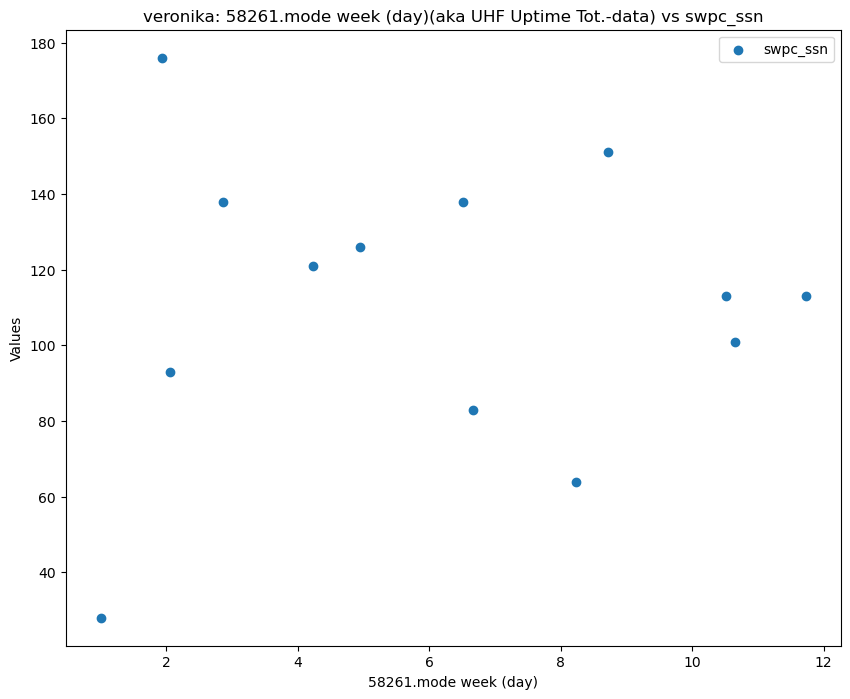

2024-02-11 18:21:43,852 - DEBUG - Processing file: [../data/veronika/UHF Uptime-data-2024-02-11 02 22 52.csv]


+---------+-------------------------+------------+
|         |   58261.mode week (day) |   swpc_ssn |
|---------+-------------------------+------------|
| count   |               13        |  13        |
| mean    |                6.16038  | 111.154    |
| std     |                3.63519  |  38.6455   |
| min     |                1.012    |  28        |
| 25%     |                2.864    |  93        |
| 50%     |                6.519    | 113        |
| 75%     |                8.726    | 138        |
| max     |               11.726    | 176        |
| Chi2    |              130        | 130        |
| P-value |                0.251062 |   0.251062 |
+---------+-------------------------+------------+
Correlation [58261.mode week (day)] vs [swpc_ssn]: pearson=[0.04530430387259429], spearman=[-0.05785145918831041], kendal_tau=[-0.0519524333466131]


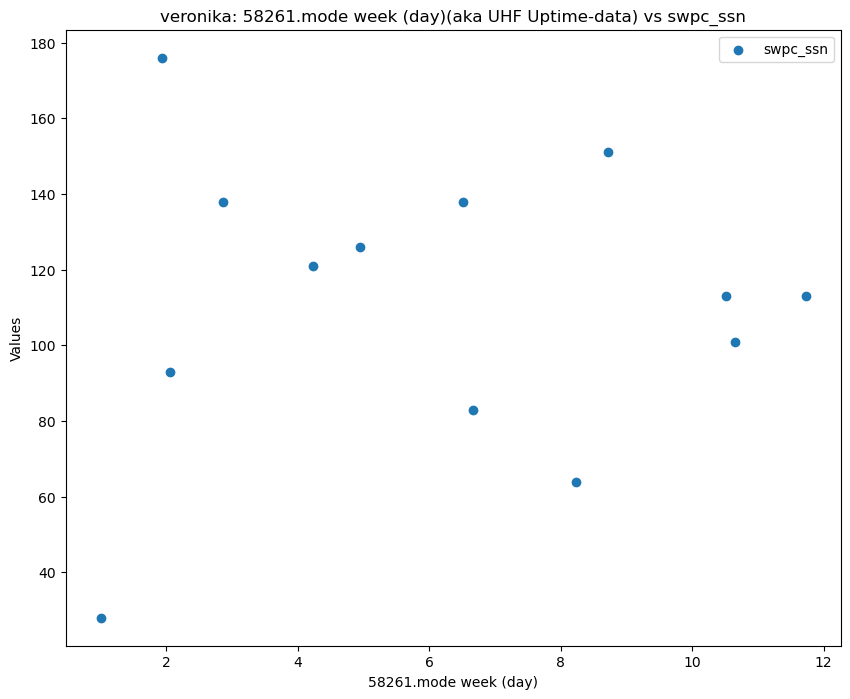

2024-02-11 18:21:44,028 - DEBUG - Processing file: [../data/veronika/Internal Magnetometer-data-2024-02-11 02 23 43.csv]


+---------+--------------+-------------+
|         |            X |    swpc_ssn |
|---------+--------------+-------------|
| count   |    85        |   85        |
| mean    |  8772.72     |  117.176    |
| std     |  2854.7      |   42.2862   |
| min     | -1436        |   26        |
| 25%     |  8582        |   86        |
| 50%     |  9436        |  123        |
| 75%     | 10091        |  149        |
| max     | 17179        |  191        |
| Chi2    |  5100        | 5100        |
| P-value |     0.354418 |    0.354418 |
+---------+--------------+-------------+
Correlation [X] vs [swpc_ssn]: pearson=[0.10656617888267522], spearman=[0.07785607654783727], kendal_tau=[0.055165208946249426]


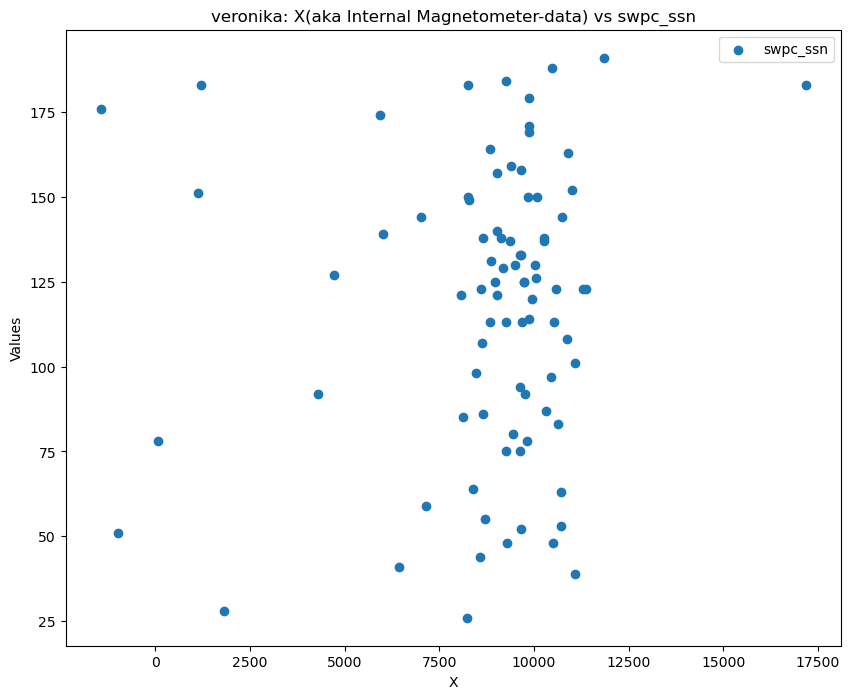

2024-02-11 18:21:44,204 - DEBUG - Processing file: [../data/veronika/Last Frame Received-data-2024-02-11 02 23 24.csv]
/tmp/ipykernel_12372/3774865929.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


+-------+-------------+------------+
|       |   58261.pid |   swpc_ssn |
|-------+-------------+------------|
| count |           0 |          0 |
| mean  |         nan |        nan |
| std   |         nan |        nan |
| min   |         nan |        nan |
| 25%   |         nan |        nan |
| 50%   |         nan |        nan |
| 75%   |         nan |        nan |
| max   |         nan |        nan |
+-------+-------------+------------+
Correlation [58261.pid] vs [swpc_ssn]: pearson=[nan], spearman=[nan], kendal_tau=[nan]


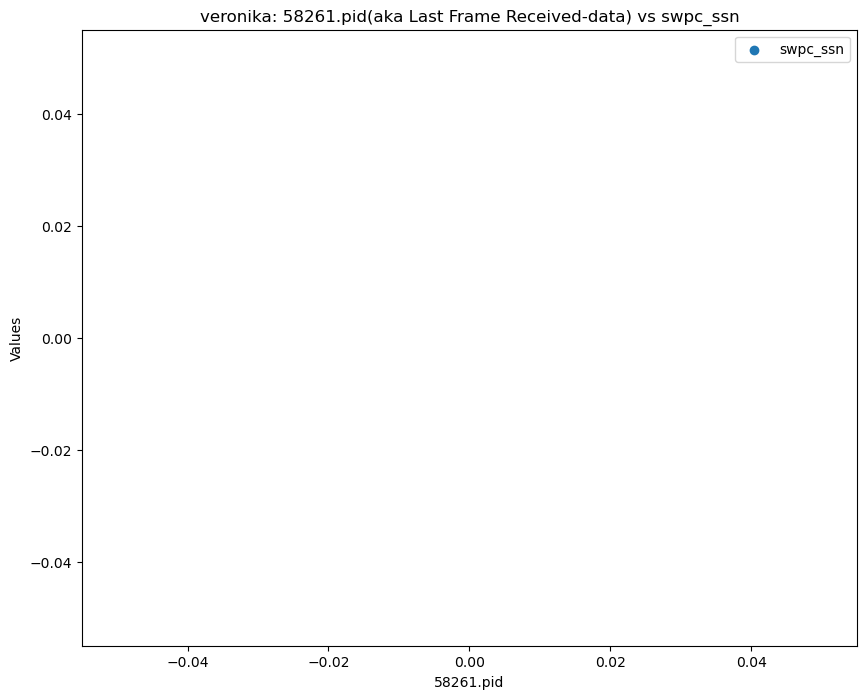

2024-02-11 18:21:44,342 - DEBUG - Processing file: [../data/veronika/OBC Uptime Tot.-data-2024-02-11 02 22 35.csv]


+---------+-------------------------+------------+
|         |   58261.mode week (day) |   swpc_ssn |
|---------+-------------------------+------------|
| count   |               13        |  13        |
| mean    |                6.28238  | 111.154    |
| std     |                3.70936  |  38.6455   |
| min     |                1.012    |  28        |
| 25%     |                2.722    |  93        |
| 50%     |                5.724    | 113        |
| 75%     |                8.659    | 138        |
| max     |               12.515    | 176        |
| Chi2    |              130        | 130        |
| P-value |                0.251062 |   0.251062 |
+---------+-------------------------+------------+
Correlation [58261.mode week (day)] vs [swpc_ssn]: pearson=[0.041200604541361034], spearman=[-0.00826449416975863], kendal_tau=[-0.02597621667330655]


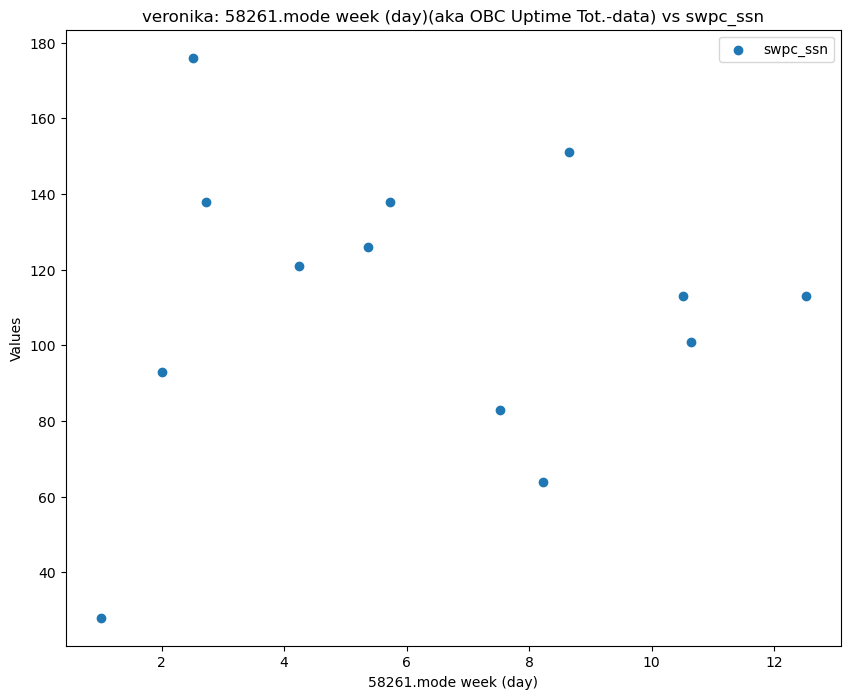

2024-02-11 18:21:44,496 - DEBUG - Processing file: [../data/veronika/OBC Uptime-data-2024-02-11 02 22 31.csv]
2024-02-11 18:21:44,516 - DEBUG - Processing file: [../data/veronika/PSU GWD Timeout-data-2024-02-11 02 23 39.csv]


+---------+------------------+------------+
|         |   58261.mode day |   swpc_ssn |
|---------+------------------+------------|
| count   |        13        |  13        |
| mean    |         3.88438  | 111.154    |
| std     |         0.253359 |  38.6455   |
| min     |         3.042    |  28        |
| 25%     |         3.958    |  93        |
| 50%     |         3.958    | 113        |
| 75%     |         3.958    | 138        |
| max     |         3.958    | 176        |
| Chi2    |        26        |  26        |
| P-value |         0.165812 |   0.165812 |
+---------+------------------+------------+
Correlation [58261.mode day] vs [swpc_ssn]: pearson=[-0.49921487354042293], spearman=[-0.2102353324910547], kendal_tau=[-0.16742770563222895]


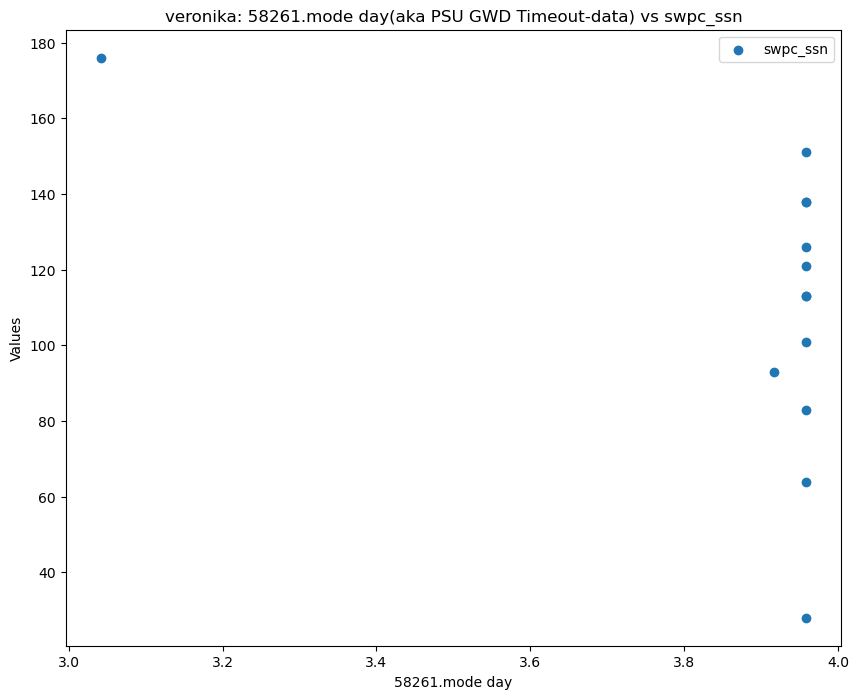

2024-02-11 18:21:44,667 - DEBUG - Processing file: [../data/veronika/PSU Uptime Tot.-data-2024-02-11 02 22 26.csv]


+---------+-------------------------+------------+
|         |   58261.mode week (day) |   swpc_ssn |
|---------+-------------------------+------------|
| count   |               13        |  13        |
| mean    |                6.43869  | 111.154    |
| std     |                3.72289  |  38.6455   |
| min     |                1.011    |  28        |
| 25%     |                3.05     |  93        |
| 50%     |                6.37     | 113        |
| 75%     |                9.508    | 138        |
| max     |               12.493    | 176        |
| Chi2    |              130        | 130        |
| P-value |                0.251062 |   0.251062 |
+---------+-------------------------+------------+
Correlation [58261.mode week (day)] vs [swpc_ssn]: pearson=[0.06972682906356296], spearman=[-0.09366426725726446], kendal_tau=[-0.07792865001991965]


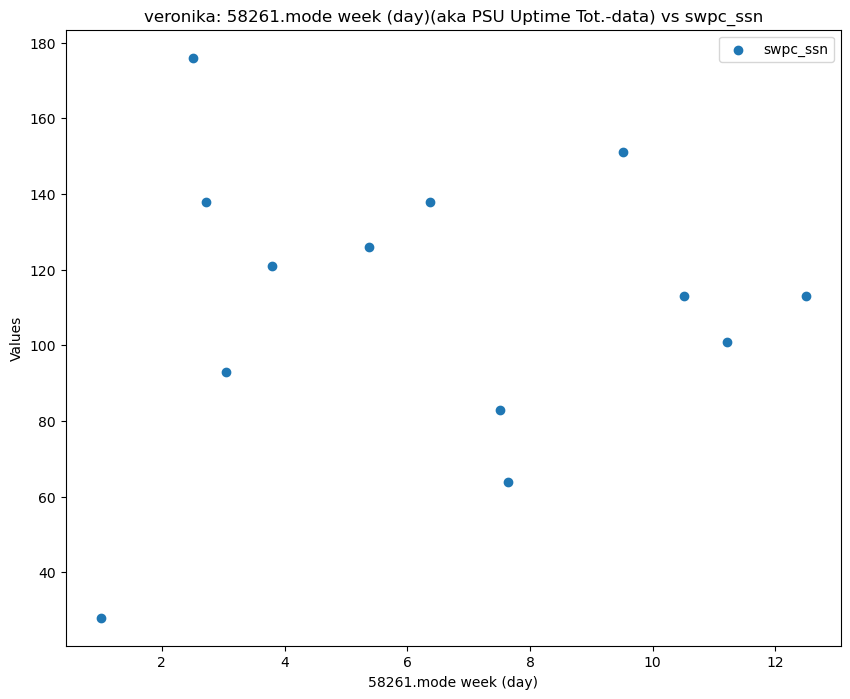

2024-02-11 18:21:44,829 - DEBUG - Processing file: [../data/veronika/PSU Uptime-data-2024-02-11 02 22 23.csv]


+---------+-------------------------+------------+
|         |   58261.mode week (day) |   swpc_ssn |
|---------+-------------------------+------------|
| count   |               13        |  13        |
| mean    |                6.43862  | 111.154    |
| std     |                3.72291  |  38.6455   |
| min     |                1.011    |  28        |
| 25%     |                3.05     |  93        |
| 50%     |                6.37     | 113        |
| 75%     |                9.508    | 138        |
| max     |               12.493    | 176        |
| Chi2    |              130        | 130        |
| P-value |                0.251062 |   0.251062 |
+---------+-------------------------+------------+
Correlation [58261.mode week (day)] vs [swpc_ssn]: pearson=[0.0697177822007228], spearman=[-0.09366426725726446], kendal_tau=[-0.07792865001991965]


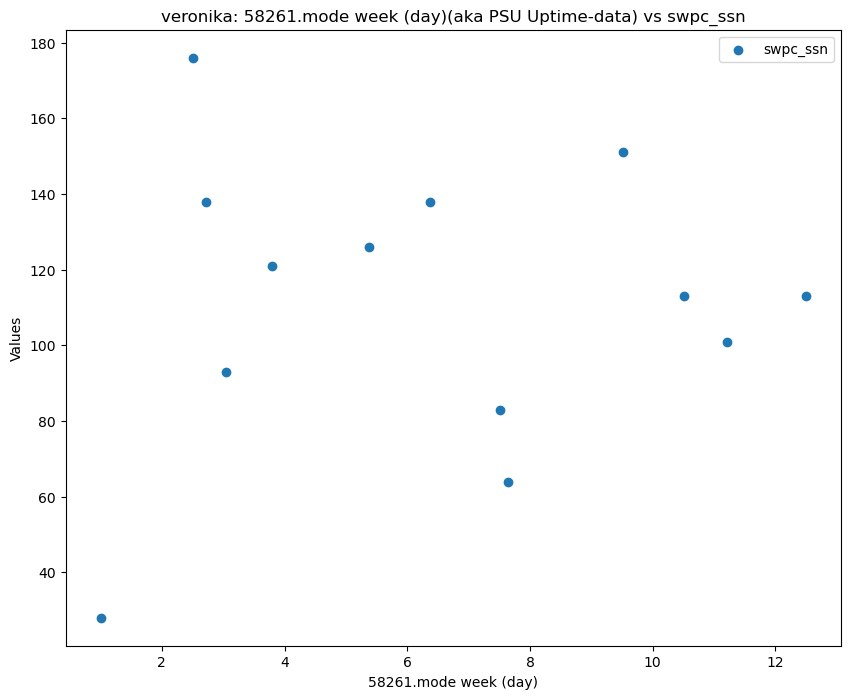

2024-02-11 18:21:44,987 - DEBUG - Processing file: [../data/veronika/Radio RSSI-data-2024-02-11 02 22 20.csv]
2024-02-11 18:21:45,010 - WARNING - Column 'UHF Act' is nearly constant, skipping.
2024-02-11 18:21:45,012 - DEBUG - Processing file: [../data/veronika/Transmitted message-data-2024-02-11 02 23 29.csv]
2024-02-11 18:21:45,035 - DEBUG - Processing file: [../data/veronika/UHF last digipeater user-data-2024-02-11 02 23 32.csv]
2024-02-11 18:21:45,054 - DEBUG - Processing file: [../data/veronika/UHF Last temperatures-data-2024-02-11 02 23 03.csv]


+---------+------------+------------+
|         |   MCU (°C) |   swpc_ssn |
|---------+------------+------------|
| count   |  13        |  13        |
| mean    |   7.33077  | 111.154    |
| std     |   3.94575  |  38.6455   |
| min     |  -1        |  28        |
| 25%     |   5.1      |  93        |
| 50%     |   7.5      | 113        |
| 75%     |  10        | 138        |
| max     |  15        | 176        |
| Chi2    | 117        | 117        |
| P-value |   0.306071 |   0.306071 |
+---------+------------+------------+
Correlation [MCU (°C)] vs [swpc_ssn]: pearson=[-0.22519147552737345], spearman=[-0.40000038049994835], kendal_tau=[-0.3006600167292012]


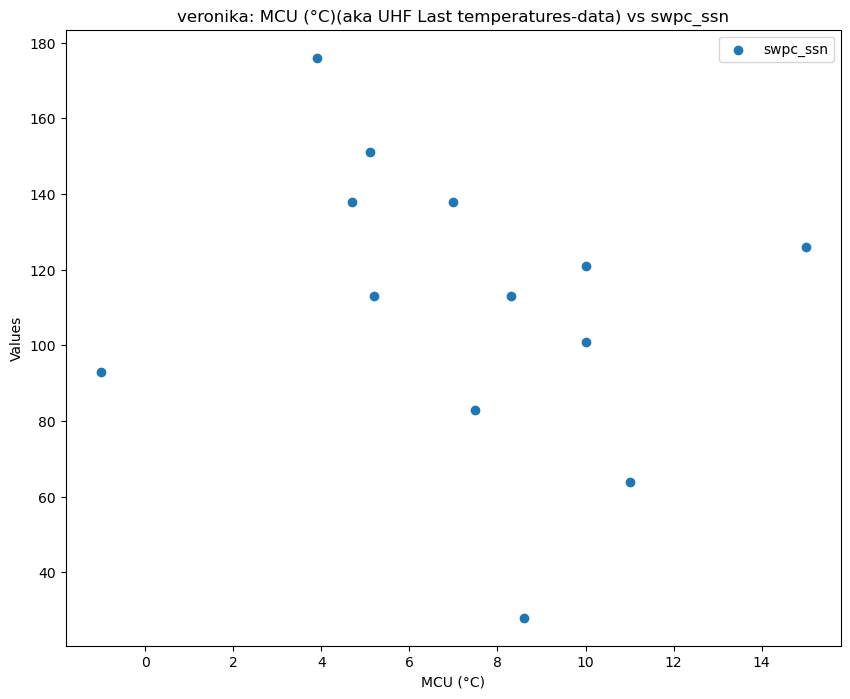

+---------+----------------+------------+
|         |   RF Chip (°C) |   swpc_ssn |
|---------+----------------+------------|
| count   |      13        |  13        |
| mean    |       7.24615  | 111.154    |
| std     |       4.82141  |  38.6455   |
| min     |      -2        |  28        |
| 25%     |       4.4      |  93        |
| 50%     |       6.6      | 113        |
| 75%     |       9.7      | 138        |
| max     |      18        | 176        |
| Chi2    |     123.5      | 123.5      |
| P-value |       0.178808 |   0.178808 |
+---------+----------------+------------+
Correlation [RF Chip (°C)] vs [swpc_ssn]: pearson=[-0.2097544734859616], spearman=[-0.3365520442827152], kendal_tau=[-0.24837131816760094]


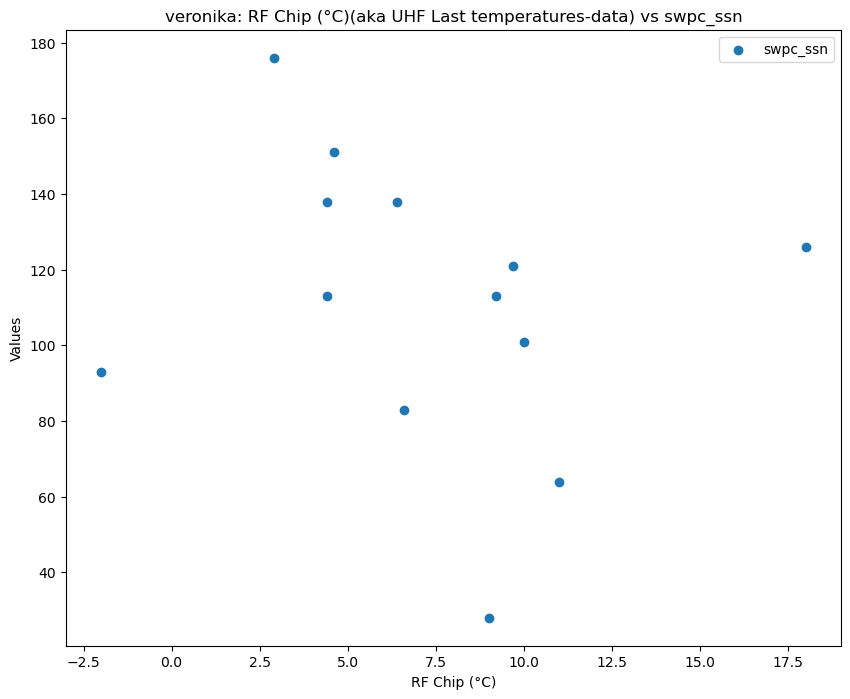

+---------+------------+------------+
|         |    PA (°C) |   swpc_ssn |
|---------+------------+------------|
| count   |  13        |  13        |
| mean    |   8.12308  | 111.154    |
| std     |   6.86151  |  38.6455   |
| min     |  -2        |  28        |
| 25%     |   4.3      |  93        |
| 50%     |   6        | 113        |
| 75%     |  10        | 138        |
| max     |  25        | 176        |
| Chi2    | 130        | 130        |
| P-value |   0.251062 |   0.251062 |
+---------+------------+------------+
Correlation [PA (°C)] vs [swpc_ssn]: pearson=[-0.10711711237073555], spearman=[-0.32231527262058657], kendal_tau=[-0.23378595005975894]


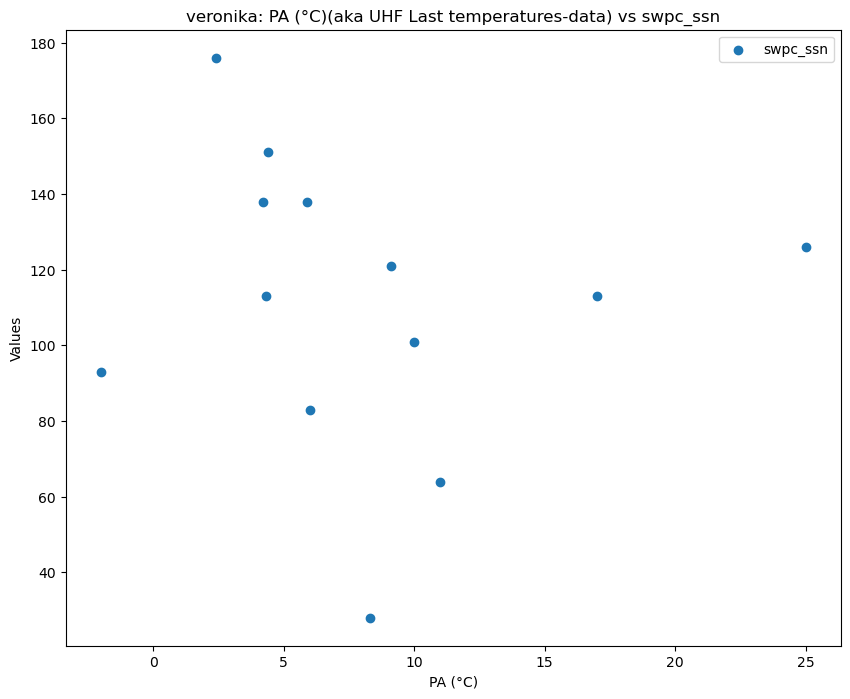

2024-02-11 18:21:45,476 - DEBUG - Processing file: [../data/veronika/UHF Received packets-data-2024-02-11 02 23 18.csv]


+---------+--------------+------------+
|         |   58261.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |    13        |  13        |
| mean    |   235.385    | 111.154    |
| std     |   107.868    |  38.6455   |
| min     |     0        |  28        |
| 25%     |   270        |  93        |
| 50%     |   293        | 113        |
| 75%     |   296        | 138        |
| max     |   299        | 176        |
| Chi2    |   100.75     | 100.75     |
| P-value |     0.205923 |   0.205923 |
+---------+--------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[0.3324105676753036], spearman=[0.006915635937205746], kendal_tau=[-0.039735970711951306]


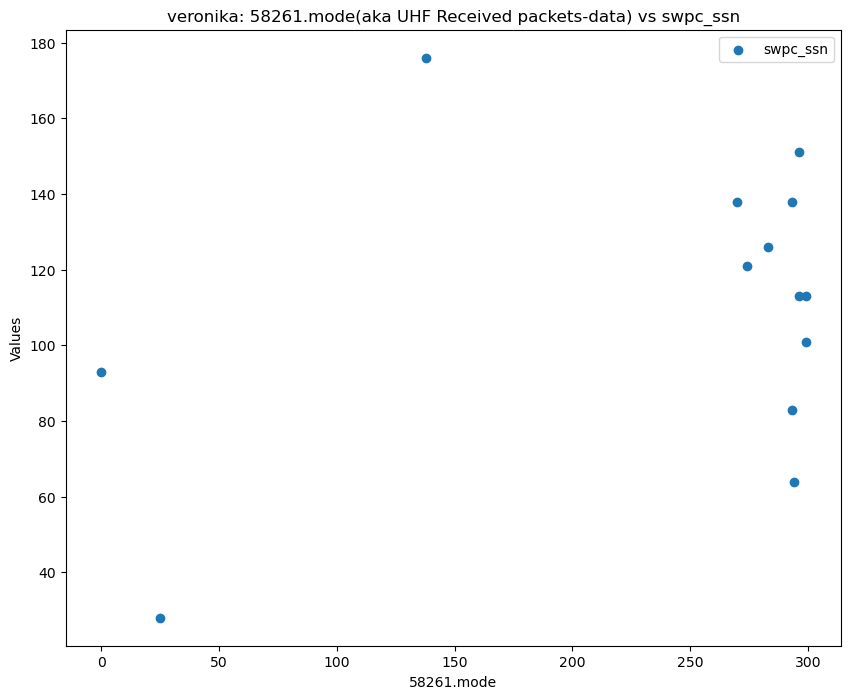

2024-02-11 18:21:45,638 - DEBUG - Processing file: [../data/veronika/UHF Resets-data-2024-02-11 02 23 11.csv]
2024-02-11 18:21:45,666 - WARNING - Column '58261.mode' is nearly constant, skipping.
2024-02-11 18:21:45,669 - DEBUG - Processing file: [../data/veronika/UHF RF Resets-data-2024-02-11 02 23 37.csv]


+---------+--------------+------------+
|         |   58261.mode |   swpc_ssn |
|---------+--------------+------------|
| count   |           13 |    13      |
| mean    |            0 |   111.154  |
| std     |            0 |    38.6455 |
| min     |            0 |    28      |
| 25%     |            0 |    93      |
| 50%     |            0 |   113      |
| 75%     |            0 |   138      |
| max     |            0 |   176      |
| Chi2    |            0 |     0      |
| P-value |            1 |     1      |
+---------+--------------+------------+
Correlation [58261.mode] vs [swpc_ssn]: pearson=[nan], spearman=[nan], kendal_tau=[nan]


/home/geugenm/anaconda3/envs/course/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


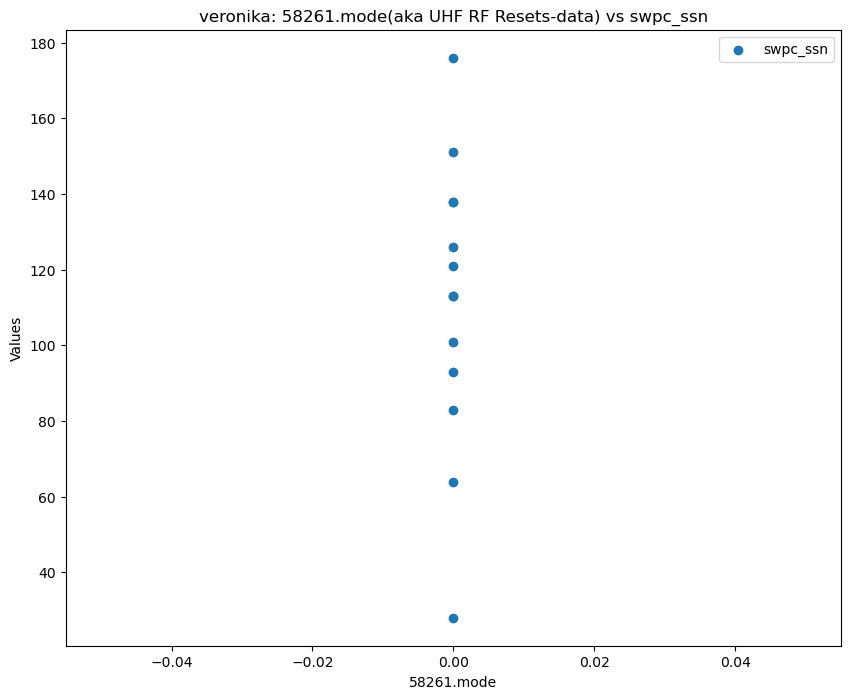

In [214]:
analyze_satellite('veronika')

2024-02-11 18:21:45,847 - DEBUG - Processing file: [../data/vzlusat-2/Battery Temperature-data-2024-02-11 02 21 24.csv]


+---------+-------------------+-------------+
|         |   51085.last (°C) |    swpc_ssn |
|---------+-------------------+-------------|
| count   |        107        |  107        |
| mean    |          6.41121  |  100.037    |
| std     |          4.01637  |   38.8752   |
| min     |         -3        |   17        |
| 25%     |          3.5      |   70        |
| 50%     |          6        |  101        |
| 75%     |         10        |  132        |
| max     |         17        |  179        |
| Chi2    |       1366.52     | 1366.52     |
| P-value |          0.152881 |    0.152881 |
+---------+-------------------+-------------+
Correlation [51085.last (°C)] vs [swpc_ssn]: pearson=[-0.02759095642049777], spearman=[-0.019451876656504323], kendal_tau=[-0.011751687937229124]


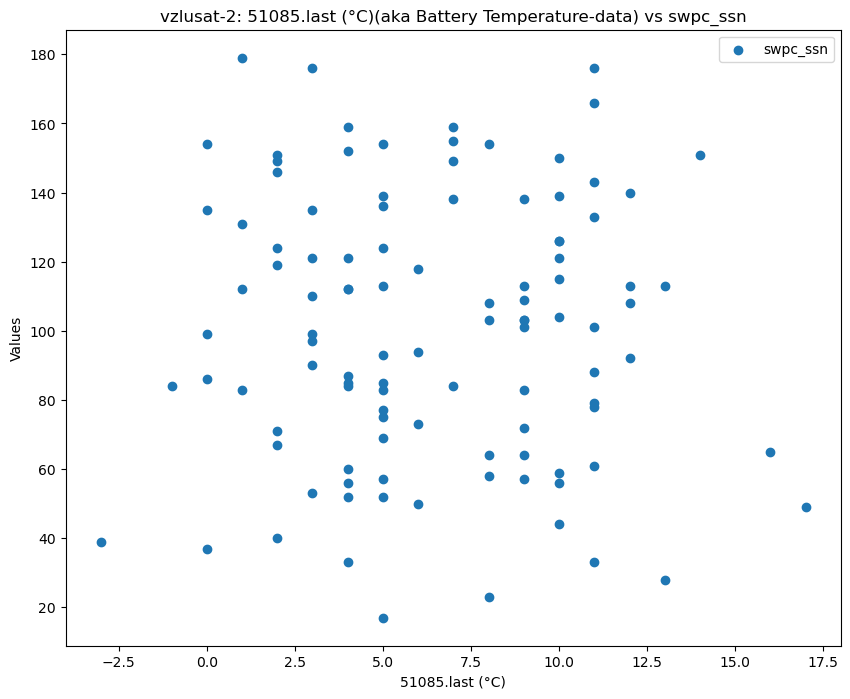

2024-02-11 18:21:46,051 - DEBUG - Processing file: [../data/vzlusat-2/Last Beacon Received By-data-2024-02-11 02 21 26.csv]
2024-02-11 18:21:46,070 - WARNING - Column 'last' is nearly constant, skipping.


In [215]:
analyze_satellite('vzlusat-2')